# Recurrent Neural Networks

Recurrent Neural Networks are designed to learn sequence data with temporal dependencies such as speech and other time series. Recurrent Neural Networks take the time dimension into account by introducing a recursive connection with a time delay of -1.


The idea behind RNNs is to use sequential information. In a feedforward neural network we assume that all inputs (and outputs) are independent of each other, but especially in finance that is a bad assumption. If you want to predict future returns it is probably better to know previous information about past returns of the same security. RNNs are called recurrent because they perform the same task for every element of a sequence, with the output being depended on the previous computations and you already know that they have a *memory* which captures information about what has been calculated so far. A RNN module is presented in the figure below

<img src="images/unrolledRNN.png" width="500">

One can implement this module either with `tensorflow` or `pytorch`. The unit can be considered as a replacement for a single neuron that have a feedback loop in addition. *This way the model is able to consider the time*.

The core reason that recurrent nets are more exciting is that they allow us to operate over sequences of vectors: Sequences in the input, the output, or in the most general case both. There are different examples of RNNs:

<img src="images/rnntypes.png" width="500">


However, there are different recurrent units that are known to perform better in practice. Why is that? We can find a detailed answer about drawbacks of RNN module and its extensions [here](http://colah.github.io/posts/2015-08-Understanding-LSTMs/).

Any references for Recurrent Neural Networks can be found in Goodfellow's book, which has a dedicate chapter to this neural network family.

Let's now dive into the code, to see how we need to prepare data to be ingested by a RNN and what are the pros and cons of it.

# Time series forecasting using Pytorch

In [7]:
import yfinance as yf
import numpy as np
import matplotlib.pyplot as plt

import random,os
import torch
import torch.optim as optim
import torch.nn as nn
from torch.utils.data import Dataset, TensorDataset, DataLoader, Subset
from collections import OrderedDict


from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler

device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [3]:
def create_input_data(series, n_lags=1, n_leads=1):
    '''
    Function for transforming time series into input acceptable by a multilayer perceptron.
    
    Parameters
    ----------
    series : np.array
        The time series to be transformed
    n_lags : int
        The number of lagged observations to consider as features
    n_leads : int
        The number of future periods we want to forecast for
        
    Returns
    -------
    X : np.array
        Array of features
    y : np.array
        Array of target
    '''
    X = []
    y = []
    for step in range(len(series) - n_lags - n_leads + 1):
        end_step = step + n_lags
        forward_end = end_step + n_leads
        X.append(series[step:end_step])
        y.append(series[end_step:forward_end])
    return np.array(X), np.array(y)

# custom function for reproducibility


def custom_set_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    np.random.seed(seed)
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)


Define the parameters:

In [9]:
# data
TICKER = 'AAPL'
START_DATE = '2010-01-02'
END_DATE = '2019-12-31'
VALID_START = '2019-07-01'
N_LAGS = 12

# neural network 
BATCH_SIZE = 16
N_EPOCHS = 100

Download and prepare the data:

In [10]:
df = yf.download(TICKER, 
                 start=START_DATE, 
                 end=END_DATE,
                 progress=False)

df = df.resample('W-MON').last() # weekly frequency from Monday
valid_size = df.loc[VALID_START:END_DATE].shape[0]
prices = df['Adj Close'].values.reshape(-1, 1)

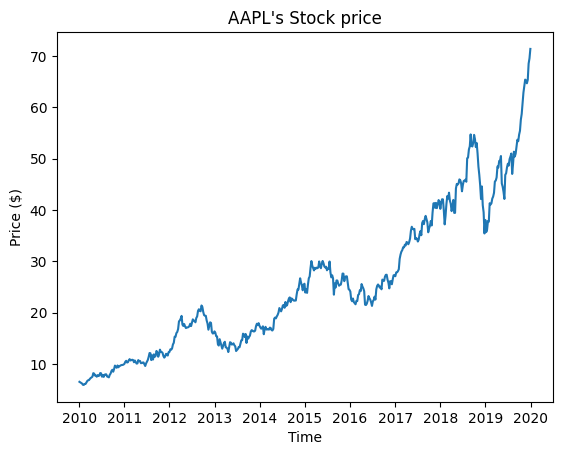

In [11]:
fig, ax = plt.subplots()

ax.plot(df.index, prices)
ax.set(title=f"{TICKER}'s Stock price", 
       xlabel='Time', 
       ylabel='Price ($)');

Scale the time series of prices:

In [12]:
valid_ind = len(prices) - valid_size

minmax = MinMaxScaler(feature_range=(0, 1))

prices_train = prices[:valid_ind]
prices_valid = prices[valid_ind:]

minmax.fit(prices_train)

prices_train = minmax.transform(prices_train)
prices_valid = minmax.transform(prices_valid)

prices_scaled = np.concatenate((prices_train, 
                                prices_valid)).flatten()
#plt.plot(prices_scaled)

In [13]:
prices_scaled.shape

(522,)

Transform the time series into input for the RNN:

In [14]:
X, y = create_input_data(prices_scaled, N_LAGS)

In [15]:
X.shape

(510, 12)

In [16]:
X[0]

array([0.01240187, 0.00997014, 0.00736381, 0.00558053, 0.00038034,
       0.        , 0.00390329, 0.00392822, 0.00927182, 0.01556312,
       0.0185311 , 0.01909851])

Obtain the naïve forecast:

In [17]:
naive_pred = prices[len(prices)-valid_size-1:-1]
y_valid = prices[len(prices)-valid_size:]

naive_mse = mean_squared_error(y_valid, naive_pred)
naive_rmse = np.sqrt(naive_mse)
print(f"Naive forecast - MSE: {naive_mse:.4f}, RMSE: {naive_rmse:.4f}")

Naive forecast - MSE: 2.5317, RMSE: 1.5911


Prepare the `DataLoader` objects:

In [18]:
# set seed for reproducibility
custom_set_seed(42)

valid_ind = len(X) - valid_size

X_tensor = torch.from_numpy(X).float().reshape(X.shape[0], 
                                               X.shape[1], 
                                               1)
y_tensor = torch.from_numpy(y).float().reshape(X.shape[0], 1)

dataset = TensorDataset(X_tensor, y_tensor)

train_dataset = Subset(dataset, list(range(valid_ind)))
valid_dataset = Subset(dataset, list(range(valid_ind, len(X))))

train_loader = DataLoader(dataset=train_dataset, 
                          batch_size=BATCH_SIZE, 
                          shuffle=True)
valid_loader = DataLoader(dataset=valid_dataset, 
                          batch_size=BATCH_SIZE)

In [19]:
X_tensor.shape

torch.Size([510, 12, 1])

Check the size of the datasets:

In [20]:
print(f'Size of datasets - training: {len(train_loader.dataset)} | validation: {len(valid_loader.dataset)}')

Size of datasets - training: 483 | validation: 27


Define the model:

In [21]:
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, n_layers, output_size):
        super(RNN, self).__init__()
        self.rnn = nn.RNN(input_size, hidden_size, 
                          n_layers, batch_first=True,
                          nonlinearity='relu')
        self.fc = nn.Linear(hidden_size, output_size)
    
    def forward(self, x):
        output, _ = self.rnn(x)
        output = self.fc(output[:,-1,:]) 
        return output

Instantiate the model, the loss function and the optimizer:

In [22]:
model = RNN(input_size=1, hidden_size=6, 
            n_layers=1, output_size=1).to(device)
loss_fn = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

Train the network:

In [24]:
PRINT_EVERY = 10
train_losses, valid_losses = [], []

for epoch in range(N_EPOCHS):
    running_loss_train = 0
    running_loss_valid = 0

    model.train()
    
    for x_batch, y_batch in train_loader:
        
        optimizer.zero_grad()
        
        x_batch = x_batch.to(device)
        y_batch = y_batch.to(device)
        y_hat = model(x_batch)
        loss = torch.sqrt(loss_fn(y_batch, y_hat))
        loss.backward()
        optimizer.step()
        running_loss_train += loss.item() * x_batch.size(0)
        
    epoch_loss_train = running_loss_train / len(train_loader.dataset)
    train_losses.append(epoch_loss_train)

    with torch.no_grad():
        model.eval()
        for x_val, y_val in valid_loader:
            x_val = x_val.to(device)
            y_val = y_val.to(device)
            y_hat = model(x_val)
            loss = torch.sqrt(loss_fn(y_val, y_hat))
            running_loss_valid += loss.item() * x_val.size(0)
            
        epoch_loss_valid = running_loss_valid / len(valid_loader.dataset)
            
        if epoch > 0 and epoch_loss_valid < min(valid_losses):
            best_epoch = epoch
            torch.save(model.state_dict(), './outputs/rnn_checkpoint.pth')
            
        valid_losses.append(epoch_loss_valid)

    if epoch % PRINT_EVERY == 0:
        print(f"<{epoch}> - Train. loss: {epoch_loss_train:.4f} \t Valid. loss: {epoch_loss_valid:.4f}")
        
print(f'Lowest loss recorded in epoch: {best_epoch}')

<0> - Train. loss: 0.1899 	 Valid. loss: 0.4869
<10> - Train. loss: 0.0282 	 Valid. loss: 0.0534
<20> - Train. loss: 0.0269 	 Valid. loss: 0.0359
<30> - Train. loss: 0.0255 	 Valid. loss: 0.0512
<40> - Train. loss: 0.0244 	 Valid. loss: 0.0432
<50> - Train. loss: 0.0238 	 Valid. loss: 0.0489
<60> - Train. loss: 0.0235 	 Valid. loss: 0.0408
<70> - Train. loss: 0.0227 	 Valid. loss: 0.0466
<80> - Train. loss: 0.0236 	 Valid. loss: 0.0457
<90> - Train. loss: 0.0226 	 Valid. loss: 0.0430
Lowest loss recorded in epoch: 93


Plot the losses over epochs:

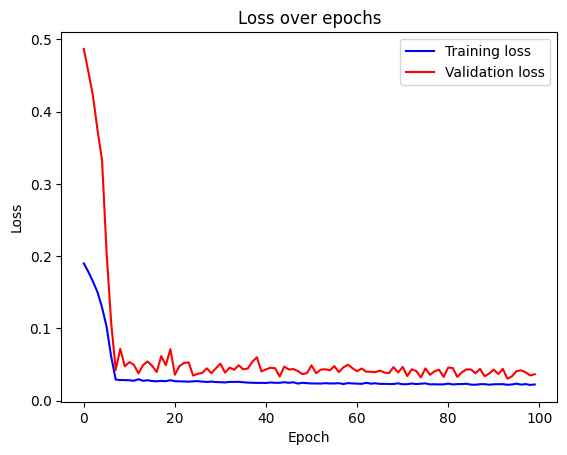

In [25]:
train_losses = np.array(train_losses)
valid_losses = np.array(valid_losses)

fig, ax = plt.subplots()

ax.plot(train_losses, color='blue', label='Training loss')
ax.plot(valid_losses, color='red', label='Validation loss')

ax.set(title="Loss over epochs", 
       xlabel='Epoch', 
       ylabel='Loss')
ax.legend()

# plt.tight_layout()
# plt.savefig('images/ch10_im14.png')
plt.show()

Load the best model (with the lowest validation loss):

In [26]:
state_dict = torch.load('outputs/rnn_checkpoint.pth')
model.load_state_dict(state_dict)

<All keys matched successfully>

Obtain the predictions:

In [27]:
y_pred = []

with torch.no_grad():
    
    model.eval()
    
    for x_val, y_val in valid_loader:
        x_val = x_val.to(device)
        y_hat = model(x_val)
        y_pred.append(y_hat)
        
y_pred = torch.cat(y_pred).numpy()
y_pred = minmax.inverse_transform(y_pred).flatten()

Evaluate the predictions:

RNN's forecast - MSE: 2.2152, RMSE: 1.4884


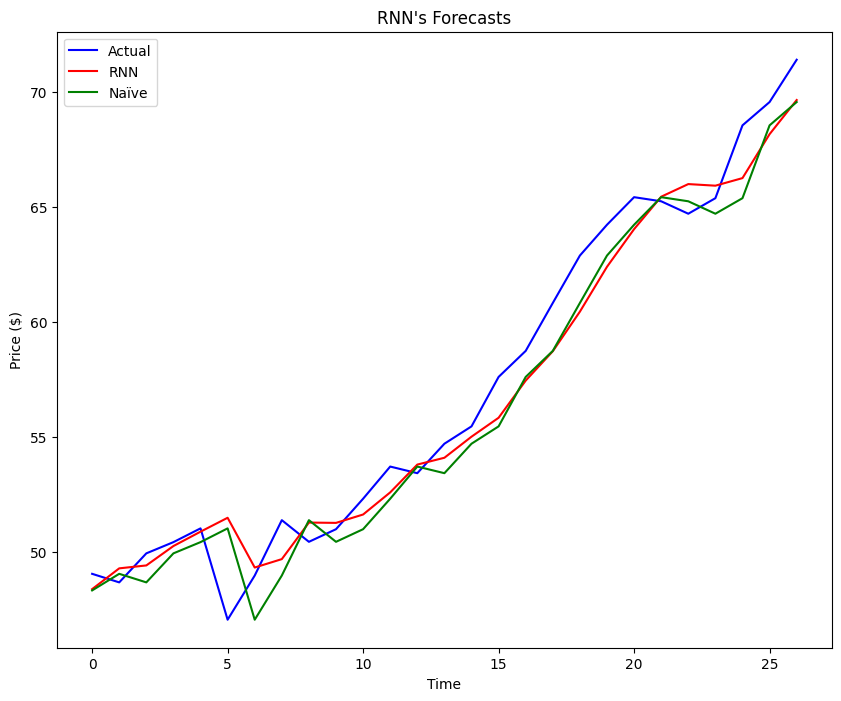

In [28]:
rnn_mse = mean_squared_error(y_valid, y_pred)
rnn_rmse = np.sqrt(rnn_mse)
print(f"RNN's forecast - MSE: {rnn_mse:.4f}, RMSE: {rnn_rmse:.4f}")

fig, ax = plt.subplots(figsize=(10,8))

ax.plot(y_valid, color='blue', label='Actual')
ax.plot(y_pred, color='red', label='RNN')
ax.plot(naive_pred, color='green', label='Naïve')

ax.set(title="RNN's Forecasts", 
       xlabel='Time', 
       ylabel='Price ($)')
ax.legend()

# plt.tight_layout()
plt.show()

# Time series forecasting using Tensorflow

In [29]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from IPython.display import Image
import sys, os


import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler, StandardScaler, QuantileTransformer
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer

In [30]:
def to_tensor(data,
              date_features=None,
              add_cyclic_date=False,
              lookback=30,
              transformer_x=None,
              use_transformer=False,
              # return_time_idx=False,
              rolling_split=False,
              verbose=False):
    """
    Transform inputs to 3-D tensors
    and y as the one time step ahead.


    Args:
        * data: data to create time series targets and features for
        LSTM.
        * lookback:

    ---
    Shape of data:
        features: (total trading days, history for regression, no of features)
        labels: (total trading days, no of features)

    Return:
    """

    if add_cyclic_date:
        x = np.concatenate((data, date_features), axis=1)
    # just do a copy of same data
    else:
        x = data
    y = data

    # repeat this for train-val-test
    xtrain, xval, ytrain, yval = train_test_split(
        x, y, shuffle=False, random_state=42, test_size=0.25)

    xval, xtest, yval, ytest = train_test_split(
        xval, yval, shuffle=False, random_state=42, test_size=0.5)

    imputer_x = SimpleImputer(strategy='median')
    xtrain = imputer_x.fit_transform(xtrain)
    xval = imputer_x.transform(xval)
    xtest = imputer_x.transform(xtest)

    imputer_y = SimpleImputer(strategy='median')
    ytrain = imputer_y.fit_transform(ytrain)
    yval = imputer_y.transform(yval)
    ytest = imputer_y.transform(ytest)

    if use_transformer:
        if transformer_x is None:
            transformer_x = MinMaxScaler()
            xtrain = transformer_x.fit_transform(xtrain)
            xval = transformer_x.transform(xval)
            xtest = transformer_x.transform(xtest)

    xtrain, ytrain = helper_train_test(xtrain, ytrain, lookback)
    xval, yval = helper_train_test(xval, yval, lookback)
    xtest, ytest = helper_train_test(xtest, ytest, lookback)

    return xtrain, xval, xtest, ytrain, yval, ytest


def data_pipe(df,
              transformer_x=None,
              use_transformer=False,
              # return_time_idx=True,
              use_tf_data=False,
              add_cyclic_date=False):
    """Data pipe splits data in train-val-test, then
    it does preprocessing on it. This logic might be implemented
    on the layes itself.

    Args:
        * df: dataframe with data to train.
        * transformer: use a data transformer for
        preprocessing.
        * use_tf_data: if True use the tf-data-set class.
    ---


    Return
    ---
    A dictionary with each of train, val and test sets.

    """


    """ split should be done in the to_tensor function """
    # df_train, df_val, df_test = time_series_split(df)
    # TODO: get time indexes here
    # concat those inside the to_tensor function
    # transform to sine
    if add_cyclic_date:
        data_datefeatures = add_cyclic_datepart(add_datefeatures(df))

        xtrain, xval, xtest, ytrain, yval, ytest = to_tensor(
            df, data_datefeatures, use_transformer=use_transformer)
    else:
        xtrain, xval, xtest, ytrain, yval, ytest = to_tensor(
            df, use_transformer=use_transformer)

    if use_tf_data:
        data_train, data_val, data_test = train_val_tf(
            xtrain, ytrain, xval, yval, xtest, ytest)

        return dict(data_train=data_train,
                    data_val=data_val,
                    data_test=data_test)

    return dict(xtrain=xtrain, ytrain=ytrain,
                xval=xval, yval=yval,
                xtest=xtest, ytest=ytest)

def helper_train_test(data_x, data_y, lookback):
    """Helper function for the creation of time series data"""
    x, y = [], []

    time_length = len(data_x)

    for i in range(time_length - lookback):
        x.append(data_x[i: i + lookback])
        y.append(data_y[i + lookback])

    return np.array(x), np.array(y)

In [32]:
df = pd.read_csv('data/closing_prices.csv')
df['date'] = pd.to_datetime(df['date'])
df.set_index('date', inplace=True)


# df.index.rename('Date', inplace=True)
# df.rename(columns={'Unnamed: 0', 'Date'}, inplace=True)
df.head()

AAPL  ABBV        ABT       AMGN    AMZN       AVGO  \
date                                                                   
2010-01-04  27.294495   NaN  21.129273  49.792737  133.90  16.673423   
2010-01-05  27.341684   NaN  20.958563  49.365427  134.69  16.797192   
2010-01-06  26.906778   NaN  21.074956  48.994453  132.25  16.929801   
2010-01-07  26.857038   NaN  21.249546  48.545833  130.00  16.823714   
2010-01-08  27.035592   NaN  21.358180  48.977198  133.52  16.947483   

                   BA        BAC        BMY          C  ...        PFE  \
date                                                    ...              
2010-01-04  45.640616  14.639460  19.648366  32.843185  ...  13.934719   
2010-01-05  47.135432  15.115313  19.341720  34.098954  ...  13.735967   
2010-01-06  48.565255  15.292591  19.334054  35.161528  ...  13.691800   
2010-01-07  50.531263  15.796435  19.349386  35.258126  ...  13.640272   
2010-01-08  50.043823  15.656478  19.027407  34.678540  ...  13.750689   

                   PG         PM          T        UNH          V         VZ  \
date                                                                           
2010-01-04  47.114847  34.709530  18.323770  27.878733  20.694802  20.828887   
2010-01-05  47.130264  34.407096  18.234010  27.834524  20.457660  20.566022   
2010-01-06  46.906716  34.407096  17.971143  28.108625  20.182950  20.274994   
2010-01-07  46.652332  34.836130  17.769366  29.187345  20.370786  20.154309   
2010-01-08  46.590664  34.646230  17.639188  28.913244  20.427137  20.167013   

                  WFC        WMT        XOM  
date                                         
2010-01-04  22.385830  43.935552  53.998112  
2010-01-05  23.000375  43.498060  54.208950  
2010-01-06  23.033151  43.400840  54.677481  
2010-01-07  23.868932  43.425145  54.505686  
2010-01-08  23.647696  43.206399  54.287039  

[5 rows x 49 columns]

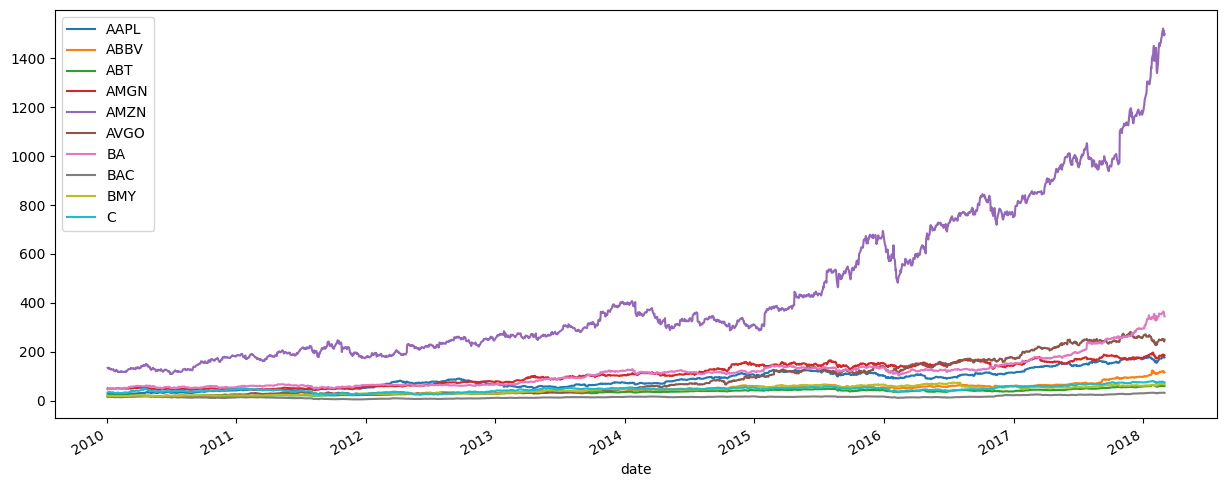

In [33]:
df.iloc[:, :10].plot(figsize=(15, 6));

Train model on 10 stocks.

## RNN

In [34]:
def two_layered_rnn(
    units=20, 
    input_shape=1, 
    output_shape=1, 
    learning_rate=0.01
):
    model = tf.keras.models.Sequential()
    
    model.add(tf.keras.layers.SimpleRNN(
        units,
        return_sequences=True,
        input_shape=[None, input_shape])
             )
    
    model.add(tf.keras.layers.SimpleRNN(units))
    model.add(tf.keras.layers.Dense(output_shape))
    
    model.compile(
        optimizer=tf.keras.optimizers.RMSprop(learning_rate),
        loss='mse')
    
    return model

In [35]:
def training_loop(model):
    metrics_df = pd.DataFrame()

    optim_param_dict = {}

    for c in df.columns:
        optim_param = pd.DataFrame()
        if df.loc[:, c].isnull().sum()/len(df) < 0.5:
            df.loc[:, c].plot(title=f'{c}');
            plt.show();
            print(c)
            print(df[c].shape)
            
            first_valid = df.loc[:, c].first_valid_index()
            
            data_dict = data_pipe(
                df.loc[first_valid:, c].values.reshape(-1, 1), 
                use_tf_data=False,
                use_transformer=True
            )

            xtrain, ytrain, xval, yval, xtest, ytest = (
                data_dict['xtrain'], data_dict['ytrain'], 
                data_dict['xval'], data_dict['yval'],  
                data_dict['xtest'], data_dict['ytest']
            )

            num_outputs = ytrain.shape[-1]
            hyper_lstm = None
            model = None
            model = two_layered_rnn()

            history = model.fit(xtrain,
                            ytrain,
                            batch_size=128,
                            epochs=20,
                            validation_data=(xval, yval),
                            verbose=1)
            
            pd.DataFrame(history.history).plot(figsize=(8, 5))
            # plt.gca().set_ylim(0, 500)
            plt.show();

            print('#' * 50)




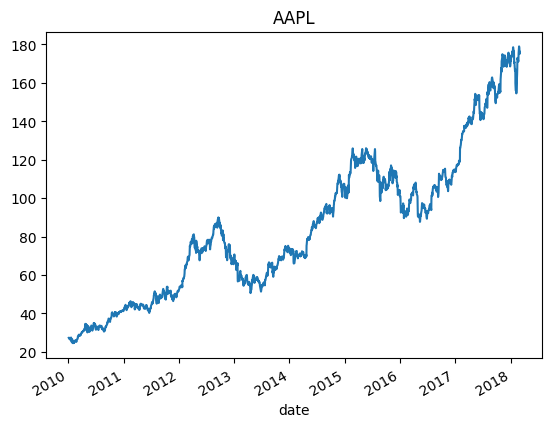

AAPL
(2055,)
Epoch 1/20
12/12 [==============================] - 1s 29ms/step - loss: 5079.9199 - val_loss: 9944.6279
Epoch 2/20
12/12 [==============================] - 0s 8ms/step - loss: 4553.4419 - val_loss: 9358.5371
Epoch 3/20
12/12 [==============================] - 0s 8ms/step - loss: 4220.9678 - val_loss: 8869.0908
Epoch 4/20
12/12 [==============================] - 0s 8ms/step - loss: 3929.9172 - val_loss: 8411.1738
Epoch 5/20
12/12 [==============================] - 0s 9ms/step - loss: 3657.9971 - val_loss: 7974.5483
Epoch 6/20
12/12 [==============================] - 0s 8ms/step - loss: 3400.8247 - val_loss: 7547.3423
Epoch 7/20
12/12 [==============================] - 0s 8ms/step - loss: 3155.7805 - val_loss: 7135.6387
Epoch 8/20
12/12 [==============================] - 0s 8ms/step - loss: 2923.0984 - val_loss: 6735.0244
Epoch 9/20
12/12 [==============================] - 0s 8ms/step - loss: 2702.2690 - val_loss: 6346.3931
Epoch 10/20
12/12 [==============================]

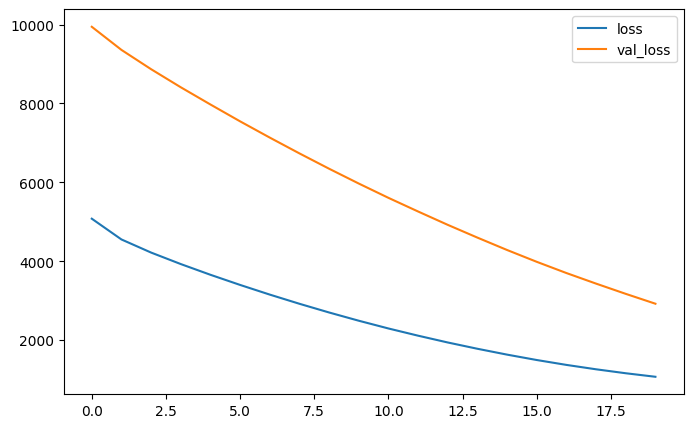

##################################################


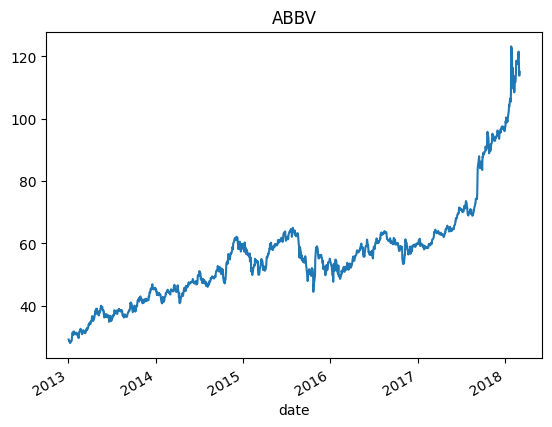

ABBV
(2055,)
Epoch 1/20
8/8 [==============================] - 1s 38ms/step - loss: 2256.2141 - val_loss: 3220.2969
Epoch 2/20
8/8 [==============================] - 0s 9ms/step - loss: 1880.6724 - val_loss: 2966.8860
Epoch 3/20
8/8 [==============================] - 0s 10ms/step - loss: 1711.8510 - val_loss: 2772.9753
Epoch 4/20
8/8 [==============================] - 0s 9ms/step - loss: 1572.9967 - val_loss: 2598.1082
Epoch 5/20
8/8 [==============================] - 0s 9ms/step - loss: 1446.6990 - val_loss: 2434.1860
Epoch 6/20
8/8 [==============================] - 0s 10ms/step - loss: 1328.7499 - val_loss: 2277.5022
Epoch 7/20
8/8 [==============================] - 0s 9ms/step - loss: 1217.3383 - val_loss: 2128.3772
Epoch 8/20
8/8 [==============================] - 0s 9ms/step - loss: 1112.1594 - val_loss: 1984.2986
Epoch 9/20
8/8 [==============================] - 0s 9ms/step - loss: 1012.1243 - val_loss: 1844.3308
Epoch 10/20
8/8 [==============================] - 0s 9ms/step - l

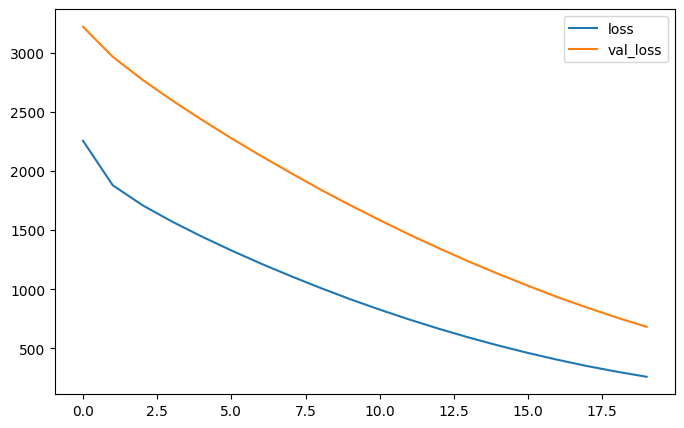

##################################################


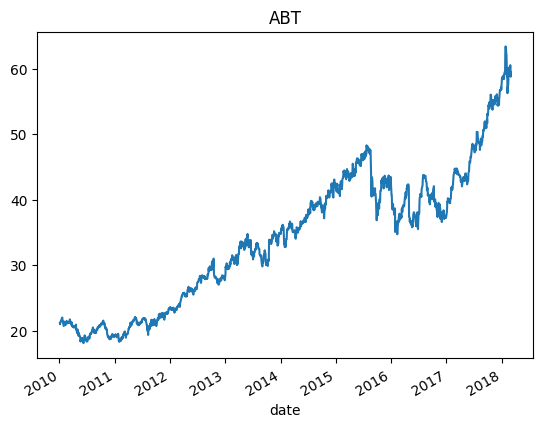

ABT
(2055,)
Epoch 1/20
12/12 [==============================] - 1s 26ms/step - loss: 701.1658 - val_loss: 948.0702
Epoch 2/20
12/12 [==============================] - 0s 8ms/step - loss: 489.8982 - val_loss: 789.1143
Epoch 3/20
12/12 [==============================] - 0s 8ms/step - loss: 393.7946 - val_loss: 661.3707
Epoch 4/20
12/12 [==============================] - 0s 8ms/step - loss: 316.0322 - val_loss: 549.6548
Epoch 5/20
12/12 [==============================] - 0s 8ms/step - loss: 251.4855 - val_loss: 450.3811
Epoch 6/20
12/12 [==============================] - 0s 8ms/step - loss: 197.7972 - val_loss: 363.1299
Epoch 7/20
12/12 [==============================] - 0s 8ms/step - loss: 155.2204 - val_loss: 288.2570
Epoch 8/20
12/12 [==============================] - 0s 8ms/step - loss: 122.8071 - val_loss: 224.4316
Epoch 9/20
12/12 [==============================] - 0s 8ms/step - loss: 100.1770 - val_loss: 173.1138
Epoch 10/20
12/12 [==============================] - 0s 9ms/step - lo

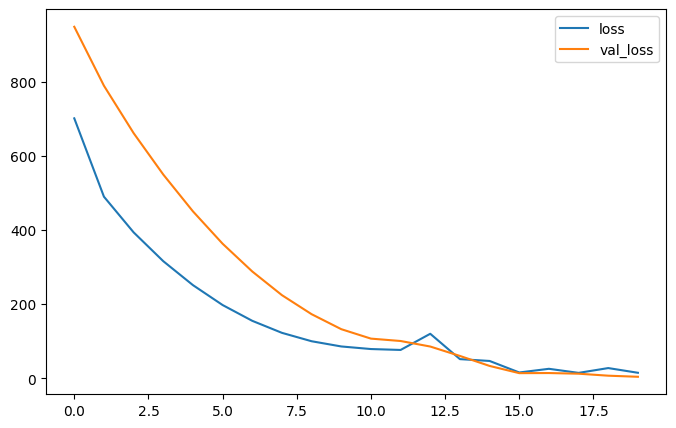

##################################################


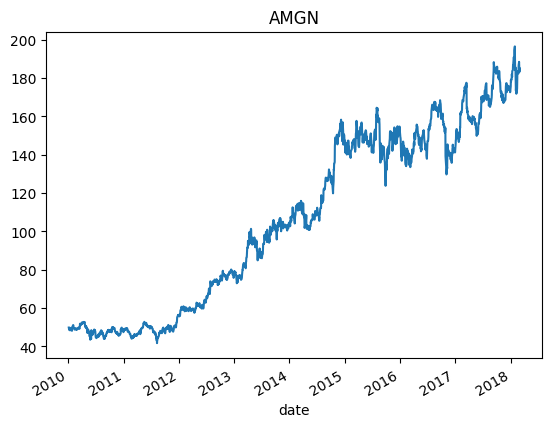

AMGN
(2055,)
Epoch 1/20
12/12 [==============================] - 1s 26ms/step - loss: 8559.0762 - val_loss: 20789.7422
Epoch 2/20
12/12 [==============================] - 0s 8ms/step - loss: 7805.0205 - val_loss: 19967.8496
Epoch 3/20
12/12 [==============================] - 0s 8ms/step - loss: 7383.1436 - val_loss: 19252.4707
Epoch 4/20
12/12 [==============================] - 0s 8ms/step - loss: 7001.2686 - val_loss: 18569.7188
Epoch 5/20
12/12 [==============================] - 0s 8ms/step - loss: 6639.0571 - val_loss: 17906.7734
Epoch 6/20
12/12 [==============================] - 0s 8ms/step - loss: 6292.0366 - val_loss: 17257.6660
Epoch 7/20
12/12 [==============================] - 0s 8ms/step - loss: 5957.4561 - val_loss: 16622.3594
Epoch 8/20
12/12 [==============================] - 0s 8ms/step - loss: 5635.3076 - val_loss: 15997.4629
Epoch 9/20
12/12 [==============================] - 0s 8ms/step - loss: 5325.3818 - val_loss: 15389.2998
Epoch 10/20
12/12 [======================

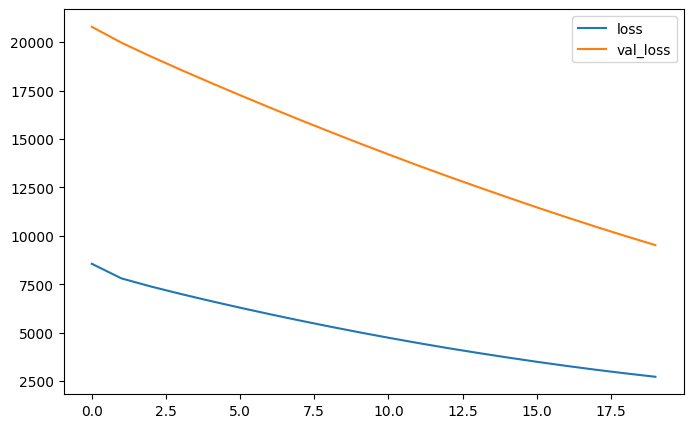

##################################################


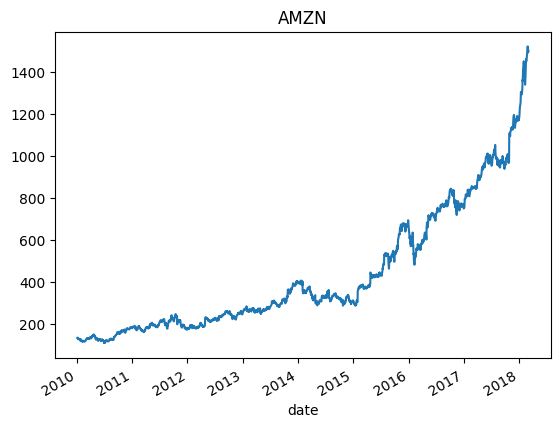

AMZN
(2055,)
Epoch 1/20
12/12 [==============================] - 1s 25ms/step - loss: 95651.2500 - val_loss: 560472.3125
Epoch 2/20
12/12 [==============================] - 0s 8ms/step - loss: 92865.4531 - val_loss: 555640.3125
Epoch 3/20
12/12 [==============================] - 0s 9ms/step - loss: 91276.0703 - val_loss: 551705.3750
Epoch 4/20
12/12 [==============================] - 0s 8ms/step - loss: 89860.3125 - val_loss: 547944.6875
Epoch 5/20
12/12 [==============================] - 0s 8ms/step - loss: 88491.9141 - val_loss: 544234.4375
Epoch 6/20
12/12 [==============================] - 0s 9ms/step - loss: 87147.5859 - val_loss: 540567.5000
Epoch 7/20
12/12 [==============================] - 0s 9ms/step - loss: 85820.2109 - val_loss: 536898.0625
Epoch 8/20
12/12 [==============================] - 0s 9ms/step - loss: 84504.5469 - val_loss: 533262.4375
Epoch 9/20
12/12 [==============================] - 0s 8ms/step - loss: 83205.4219 - val_loss: 529642.5625
Epoch 10/20
12/12 [====

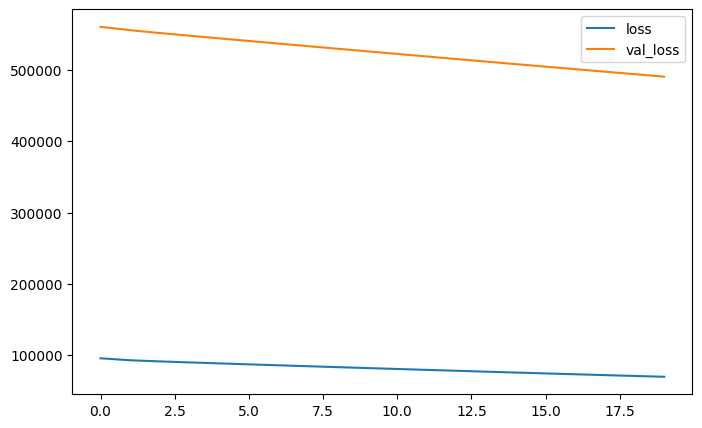

##################################################


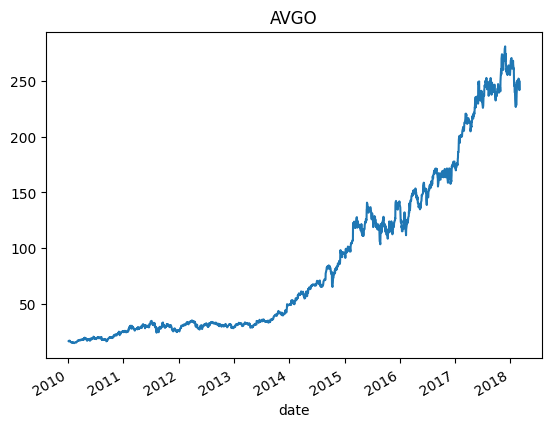

AVGO
(2055,)
Epoch 1/20
12/12 [==============================] - 1s 28ms/step - loss: 3554.5894 - val_loss: 24359.7090
Epoch 2/20
12/12 [==============================] - 0s 9ms/step - loss: 3168.0632 - val_loss: 23512.3906
Epoch 3/20
12/12 [==============================] - 0s 9ms/step - loss: 2951.0193 - val_loss: 22752.4355
Epoch 4/20
12/12 [==============================] - 0s 8ms/step - loss: 2758.7395 - val_loss: 22032.3672
Epoch 5/20
12/12 [==============================] - 0s 9ms/step - loss: 2581.0327 - val_loss: 21323.5684
Epoch 6/20
12/12 [==============================] - 0s 9ms/step - loss: 2417.5999 - val_loss: 20640.2832
Epoch 7/20
12/12 [==============================] - 0s 9ms/step - loss: 2267.2383 - val_loss: 19978.4277
Epoch 8/20
12/12 [==============================] - 0s 9ms/step - loss: 2128.6865 - val_loss: 19318.5547
Epoch 9/20
12/12 [==============================] - 0s 9ms/step - loss: 2001.2346 - val_loss: 18681.8496
Epoch 10/20
12/12 [======================

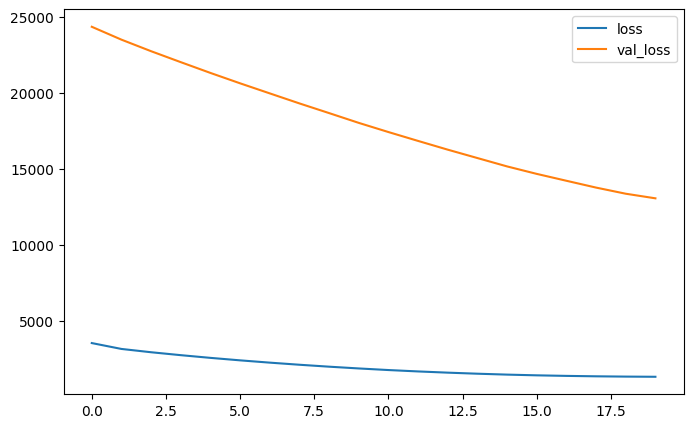

##################################################


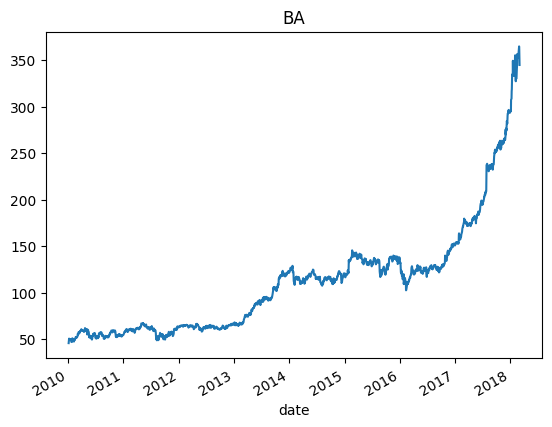

BA
(2055,)
Epoch 1/20
12/12 [==============================] - 1s 26ms/step - loss: 7859.3330 - val_loss: 16354.1084
Epoch 2/20
12/12 [==============================] - 0s 8ms/step - loss: 7105.7451 - val_loss: 15610.3252
Epoch 3/20
12/12 [==============================] - 0s 8ms/step - loss: 6682.4717 - val_loss: 14974.1455
Epoch 4/20
12/12 [==============================] - 0s 8ms/step - loss: 6305.7090 - val_loss: 14375.4102
Epoch 5/20
12/12 [==============================] - 0s 8ms/step - loss: 5949.3936 - val_loss: 13794.0264
Epoch 6/20
12/12 [==============================] - 0s 8ms/step - loss: 5607.7983 - val_loss: 13228.1904
Epoch 7/20
12/12 [==============================] - 0s 8ms/step - loss: 5278.6294 - val_loss: 12673.6172
Epoch 8/20
12/12 [==============================] - 0s 8ms/step - loss: 4962.5762 - val_loss: 12132.9502
Epoch 9/20
12/12 [==============================] - 0s 8ms/step - loss: 4658.1001 - val_loss: 11602.2100
Epoch 10/20
12/12 [========================

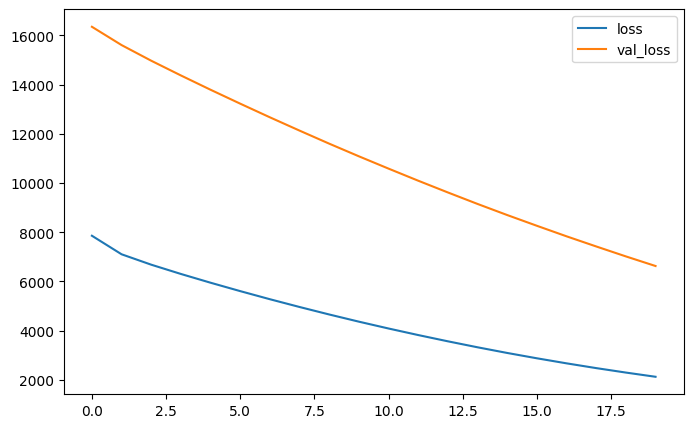

##################################################


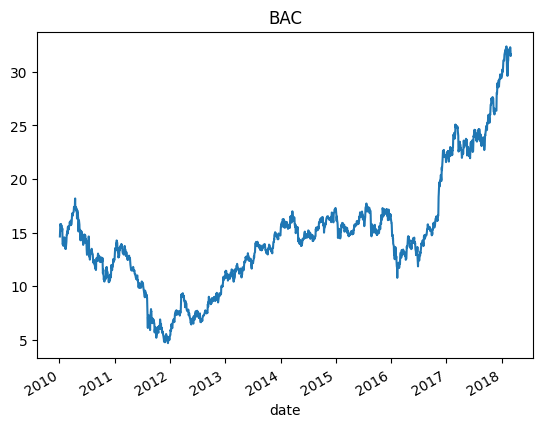

BAC
(2055,)
Epoch 1/20
12/12 [==============================] - 2s 26ms/step - loss: 61.9376 - val_loss: 77.6040
Epoch 2/20
12/12 [==============================] - 0s 8ms/step - loss: 19.3729 - val_loss: 48.3476
Epoch 3/20
12/12 [==============================] - 0s 8ms/step - loss: 12.8920 - val_loss: 36.3309
Epoch 4/20
12/12 [==============================] - 0s 8ms/step - loss: 11.7090 - val_loss: 29.1812
Epoch 5/20
12/12 [==============================] - 0s 8ms/step - loss: 11.8889 - val_loss: 29.4093
Epoch 6/20
12/12 [==============================] - 0s 9ms/step - loss: 11.3513 - val_loss: 30.4127
Epoch 7/20
12/12 [==============================] - 0s 8ms/step - loss: 7.8621 - val_loss: 21.3657
Epoch 8/20
12/12 [==============================] - 0s 8ms/step - loss: 9.3822 - val_loss: 17.0463
Epoch 9/20
12/12 [==============================] - 0s 8ms/step - loss: 2.7449 - val_loss: 17.3301
Epoch 10/20
12/12 [==============================] - 0s 8ms/step - loss: 3.0499 - val_loss

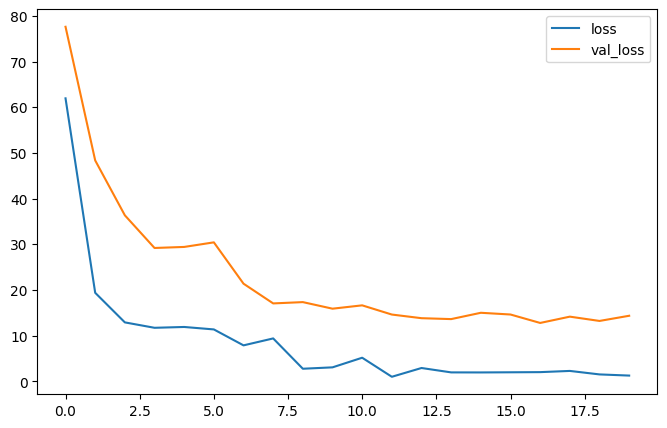

##################################################


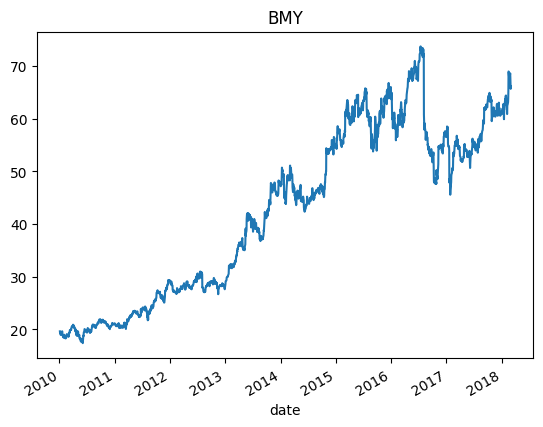

BMY
(2055,)
Epoch 1/20
12/12 [==============================] - 1s 25ms/step - loss: 1186.5751 - val_loss: 2595.9331
Epoch 2/20
12/12 [==============================] - 0s 8ms/step - loss: 943.6616 - val_loss: 2329.7444
Epoch 3/20
12/12 [==============================] - 0s 8ms/step - loss: 811.6450 - val_loss: 2103.3667
Epoch 4/20
12/12 [==============================] - 0s 8ms/step - loss: 700.6506 - val_loss: 1897.3231
Epoch 5/20
12/12 [==============================] - 0s 8ms/step - loss: 603.0234 - val_loss: 1703.6407
Epoch 6/20
12/12 [==============================] - 0s 8ms/step - loss: 517.3880 - val_loss: 1524.1768
Epoch 7/20
12/12 [==============================] - 0s 8ms/step - loss: 443.6987 - val_loss: 1357.6154
Epoch 8/20
12/12 [==============================] - 0s 8ms/step - loss: 381.4216 - val_loss: 1206.1521
Epoch 9/20
12/12 [==============================] - 0s 8ms/step - loss: 330.3094 - val_loss: 1066.7810
Epoch 10/20
12/12 [==============================] - 0s 8ms

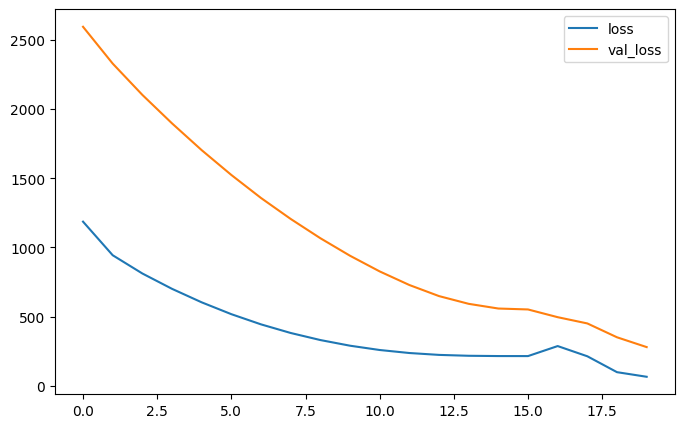

##################################################


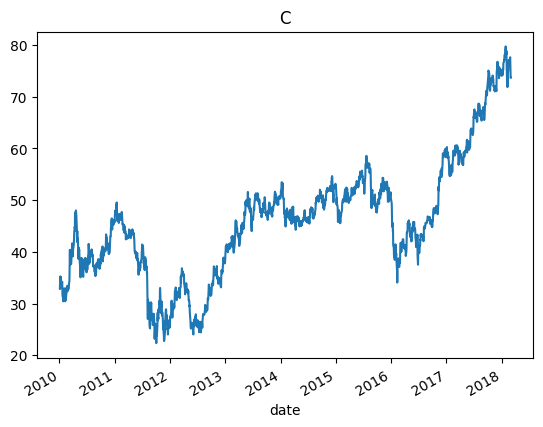

C
(2055,)
Epoch 1/20
12/12 [==============================] - 1s 28ms/step - loss: 1561.5068 - val_loss: 1687.4594
Epoch 2/20
12/12 [==============================] - 0s 9ms/step - loss: 1135.1626 - val_loss: 1407.5171
Epoch 3/20
12/12 [==============================] - 0s 9ms/step - loss: 956.0386 - val_loss: 1226.5336
Epoch 4/20
12/12 [==============================] - 0s 9ms/step - loss: 815.4220 - val_loss: 1066.3105
Epoch 5/20
12/12 [==============================] - 0s 8ms/step - loss: 691.0934 - val_loss: 920.5972
Epoch 6/20
12/12 [==============================] - 0s 8ms/step - loss: 580.1004 - val_loss: 787.7325
Epoch 7/20
12/12 [==============================] - 0s 9ms/step - loss: 480.6809 - val_loss: 666.2701
Epoch 8/20
12/12 [==============================] - 0s 10ms/step - loss: 393.0621 - val_loss: 557.3244
Epoch 9/20
12/12 [==============================] - 0s 10ms/step - loss: 317.0248 - val_loss: 459.6519
Epoch 10/20
12/12 [==============================] - 0s 10ms/st

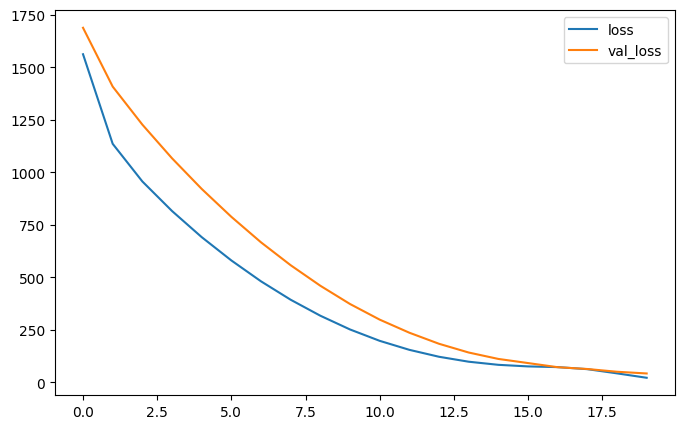

##################################################


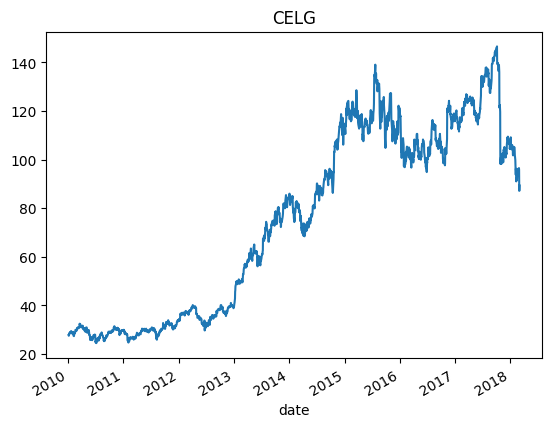

CELG
(2055,)
Epoch 1/20
12/12 [==============================] - 2s 26ms/step - loss: 4423.0220 - val_loss: 10105.4805
Epoch 2/20
12/12 [==============================] - 0s 8ms/step - loss: 3945.9014 - val_loss: 9550.2344
Epoch 3/20
12/12 [==============================] - 0s 8ms/step - loss: 3673.9048 - val_loss: 9063.6240
Epoch 4/20
12/12 [==============================] - 0s 9ms/step - loss: 3431.6353 - val_loss: 8602.4629
Epoch 5/20
12/12 [==============================] - 0s 8ms/step - loss: 3206.2419 - val_loss: 8159.7280
Epoch 6/20
12/12 [==============================] - 0s 8ms/step - loss: 2996.0701 - val_loss: 7734.8589
Epoch 7/20
12/12 [==============================] - 0s 8ms/step - loss: 2797.3530 - val_loss: 7318.3462
Epoch 8/20
12/12 [==============================] - 0s 8ms/step - loss: 2609.5613 - val_loss: 6914.4224
Epoch 9/20
12/12 [==============================] - 0s 8ms/step - loss: 2433.8337 - val_loss: 6522.6597
Epoch 10/20
12/12 [==============================

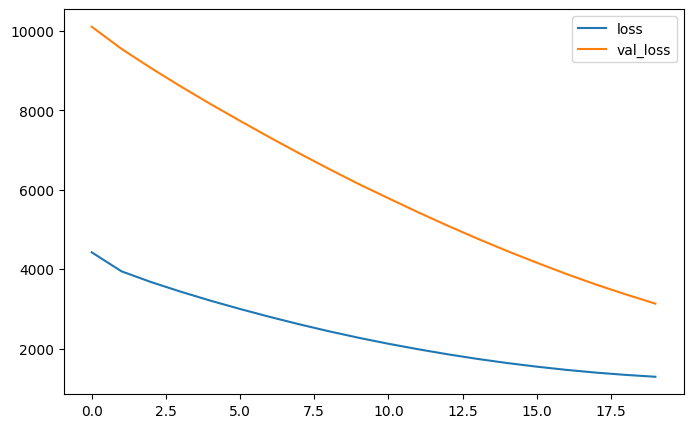

##################################################


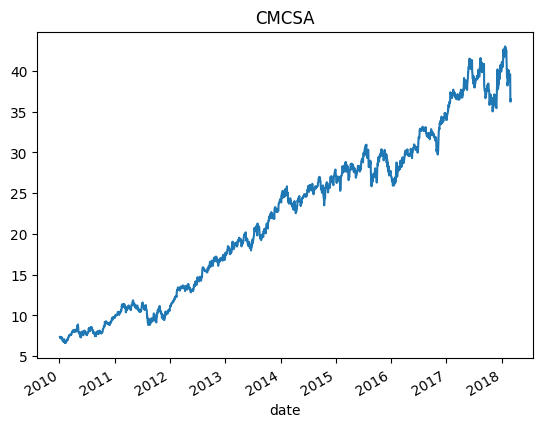

CMCSA
(2055,)
Epoch 1/20
12/12 [==============================] - 2s 26ms/step - loss: 215.1259 - val_loss: 577.5350
Epoch 2/20
12/12 [==============================] - 0s 9ms/step - loss: 126.7985 - val_loss: 467.5649
Epoch 3/20
12/12 [==============================] - 0s 8ms/step - loss: 93.9020 - val_loss: 382.8710
Epoch 4/20
12/12 [==============================] - 0s 8ms/step - loss: 73.3940 - val_loss: 315.5888
Epoch 5/20
12/12 [==============================] - 0s 8ms/step - loss: 61.9417 - val_loss: 264.2767
Epoch 6/20
12/12 [==============================] - 0s 8ms/step - loss: 56.7679 - val_loss: 230.0208
Epoch 7/20
12/12 [==============================] - 0s 9ms/step - loss: 55.1158 - val_loss: 205.4738
Epoch 8/20
12/12 [==============================] - 0s 8ms/step - loss: 38.4019 - val_loss: 156.9526
Epoch 9/20
12/12 [==============================] - 0s 8ms/step - loss: 13.9200 - val_loss: 113.0138
Epoch 10/20
12/12 [==============================] - 0s 8ms/step - loss: 2

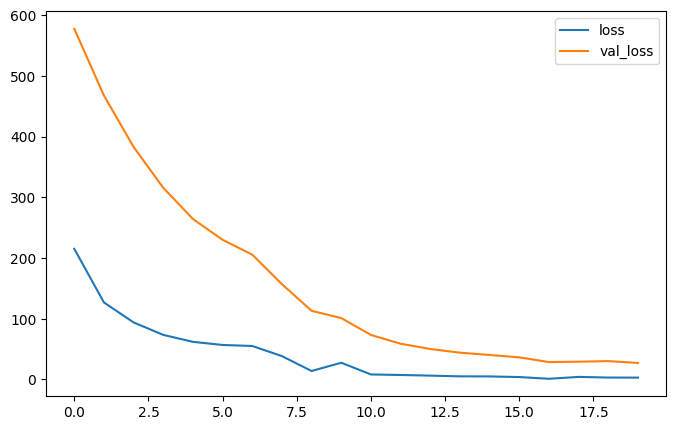

##################################################


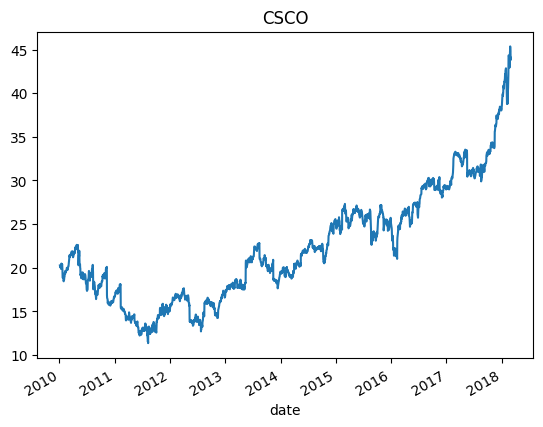

CSCO
(2055,)
Epoch 1/20
12/12 [==============================] - 1s 28ms/step - loss: 221.4613 - val_loss: 434.7843
Epoch 2/20
12/12 [==============================] - 0s 10ms/step - loss: 122.7096 - val_loss: 334.6177
Epoch 3/20
12/12 [==============================] - 0s 11ms/step - loss: 79.3873 - val_loss: 258.9770
Epoch 4/20
12/12 [==============================] - 0s 9ms/step - loss: 50.4981 - val_loss: 199.7511
Epoch 5/20
12/12 [==============================] - 0s 9ms/step - loss: 31.8099 - val_loss: 152.2088
Epoch 6/20
12/12 [==============================] - 0s 10ms/step - loss: 21.3940 - val_loss: 117.9736
Epoch 7/20
12/12 [==============================] - 0s 8ms/step - loss: 17.1903 - val_loss: 98.0378
Epoch 8/20
12/12 [==============================] - 0s 8ms/step - loss: 16.1996 - val_loss: 91.9768
Epoch 9/20
12/12 [==============================] - 0s 8ms/step - loss: 17.5104 - val_loss: 84.2558
Epoch 10/20
12/12 [==============================] - 0s 11ms/step - loss: 1

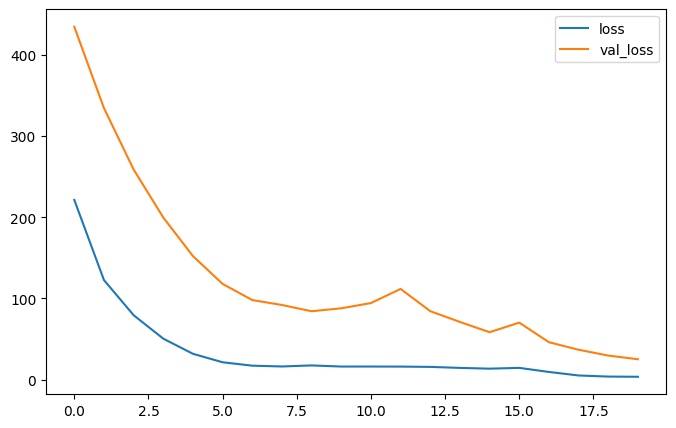

##################################################


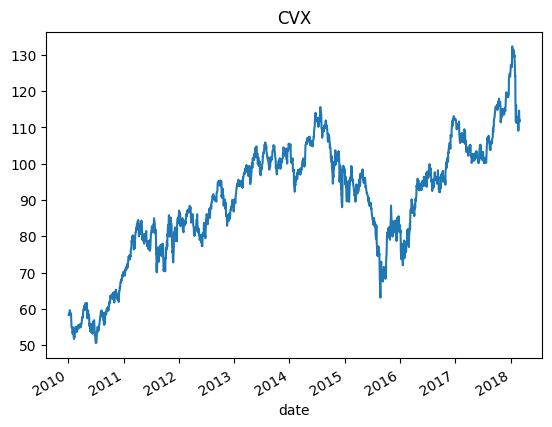

CVX
(2055,)
Epoch 1/20
12/12 [==============================] - 1s 26ms/step - loss: 6961.3330 - val_loss: 8564.5586
Epoch 2/20
12/12 [==============================] - 0s 8ms/step - loss: 6193.6362 - val_loss: 7954.9473
Epoch 3/20
12/12 [==============================] - 0s 8ms/step - loss: 5737.9961 - val_loss: 7475.7114
Epoch 4/20
12/12 [==============================] - 0s 8ms/step - loss: 5353.1016 - val_loss: 7042.3877
Epoch 5/20
12/12 [==============================] - 0s 8ms/step - loss: 4998.1782 - val_loss: 6631.1670
Epoch 6/20
12/12 [==============================] - 0s 8ms/step - loss: 4661.5239 - val_loss: 6236.1006
Epoch 7/20
12/12 [==============================] - 0s 8ms/step - loss: 4339.0210 - val_loss: 5854.7812
Epoch 8/20
12/12 [==============================] - 0s 8ms/step - loss: 4030.3474 - val_loss: 5487.8545
Epoch 9/20
12/12 [==============================] - 0s 8ms/step - loss: 3734.9729 - val_loss: 5133.9062
Epoch 10/20
12/12 [==============================] 

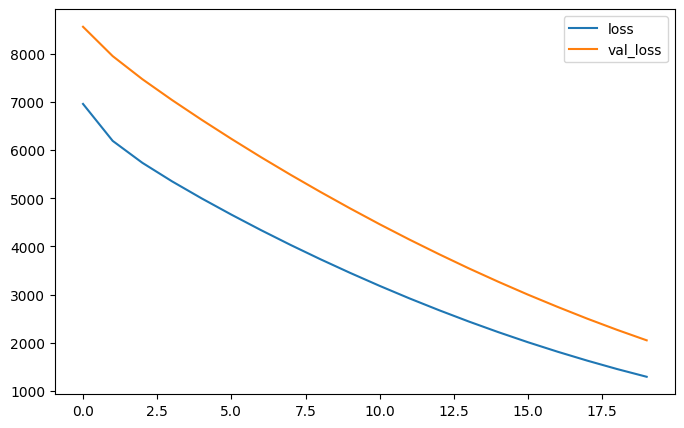

##################################################


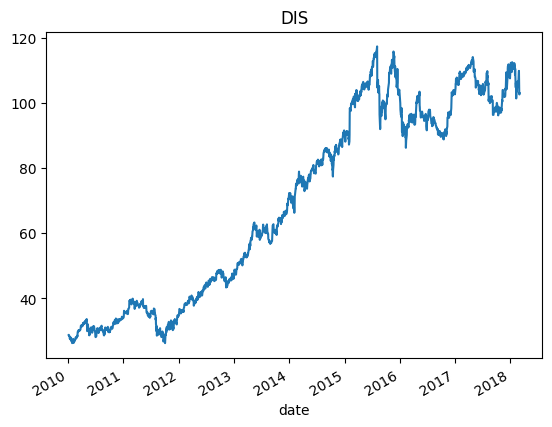

DIS
(2055,)
Epoch 1/20
12/12 [==============================] - 1s 27ms/step - loss: 3778.7334 - val_loss: 8095.5396
Epoch 2/20
12/12 [==============================] - 0s 9ms/step - loss: 3310.0496 - val_loss: 7593.3853
Epoch 3/20
12/12 [==============================] - 0s 8ms/step - loss: 3045.0793 - val_loss: 7157.7632
Epoch 4/20
12/12 [==============================] - 0s 8ms/step - loss: 2810.7046 - val_loss: 6750.7476
Epoch 5/20
12/12 [==============================] - 0s 8ms/step - loss: 2593.5876 - val_loss: 6359.5781
Epoch 6/20
12/12 [==============================] - 0s 8ms/step - loss: 2389.6851 - val_loss: 5980.0967
Epoch 7/20
12/12 [==============================] - 0s 8ms/step - loss: 2197.8479 - val_loss: 5617.2148
Epoch 8/20
12/12 [==============================] - 0s 8ms/step - loss: 2020.4017 - val_loss: 5267.3882
Epoch 9/20
12/12 [==============================] - 0s 8ms/step - loss: 1853.0508 - val_loss: 4925.3745
Epoch 10/20
12/12 [==============================] 

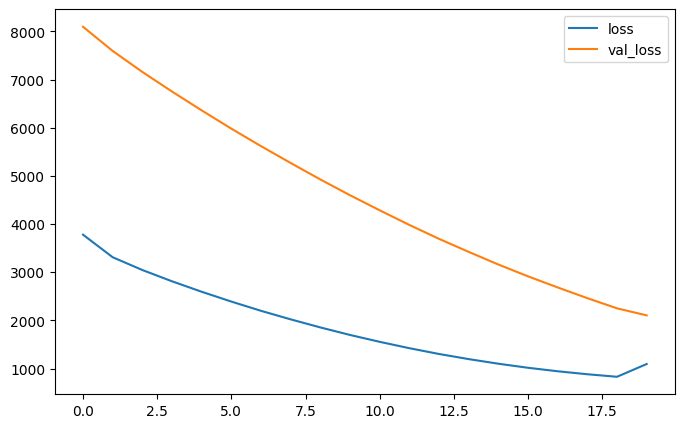

##################################################


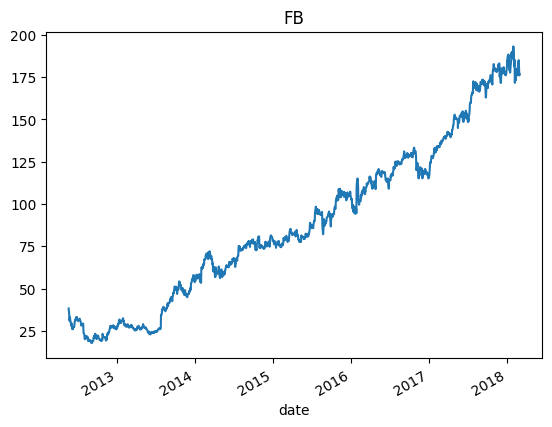

FB
(2055,)
Epoch 1/20
9/9 [==============================] - 1s 32ms/step - loss: 5179.5220 - val_loss: 16426.9531
Epoch 2/20
9/9 [==============================] - 0s 9ms/step - loss: 4675.2998 - val_loss: 15799.2910
Epoch 3/20
9/9 [==============================] - 0s 10ms/step - loss: 4411.4263 - val_loss: 15301.6973
Epoch 4/20
9/9 [==============================] - 0s 9ms/step - loss: 4188.9043 - val_loss: 14841.0117
Epoch 5/20
9/9 [==============================] - 0s 9ms/step - loss: 3982.5042 - val_loss: 14393.2285
Epoch 6/20
9/9 [==============================] - 0s 8ms/step - loss: 3784.7571 - val_loss: 13963.7041
Epoch 7/20
9/9 [==============================] - 0s 9ms/step - loss: 3597.6174 - val_loss: 13536.2598
Epoch 8/20
9/9 [==============================] - 0s 9ms/step - loss: 3416.4646 - val_loss: 13115.6855
Epoch 9/20
9/9 [==============================] - 0s 8ms/step - loss: 3240.5583 - val_loss: 12700.2881
Epoch 10/20
9/9 [==============================] - 0s 8ms/st

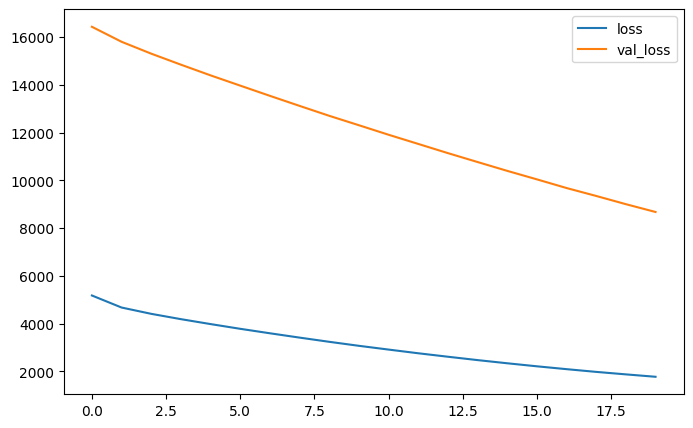

##################################################


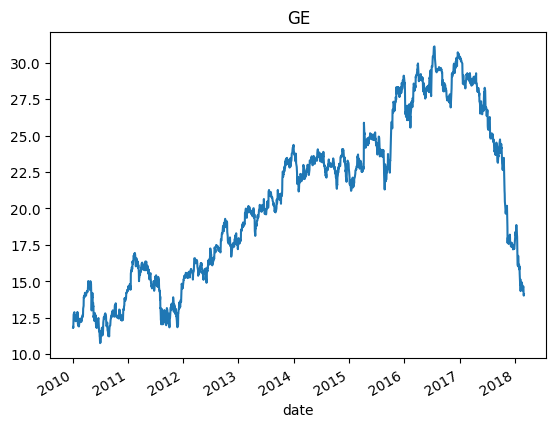

GE
(2055,)
Epoch 1/20
12/12 [==============================] - 1s 25ms/step - loss: 183.5579 - val_loss: 368.6935
Epoch 2/20
12/12 [==============================] - 0s 9ms/step - loss: 84.2502 - val_loss: 279.9377
Epoch 3/20
12/12 [==============================] - 0s 8ms/step - loss: 53.4517 - val_loss: 215.6240
Epoch 4/20
12/12 [==============================] - 0s 8ms/step - loss: 35.1632 - val_loss: 166.1342
Epoch 5/20
12/12 [==============================] - 0s 8ms/step - loss: 25.5177 - val_loss: 131.7753
Epoch 6/20
12/12 [==============================] - 0s 8ms/step - loss: 21.7787 - val_loss: 110.5008
Epoch 7/20
12/12 [==============================] - 0s 8ms/step - loss: 20.9880 - val_loss: 101.4594
Epoch 8/20
12/12 [==============================] - 0s 8ms/step - loss: 20.9570 - val_loss: 102.6023
Epoch 9/20
12/12 [==============================] - 0s 8ms/step - loss: 20.9076 - val_loss: 217.9453
Epoch 10/20
12/12 [==============================] - 0s 8ms/step - loss: 26.55

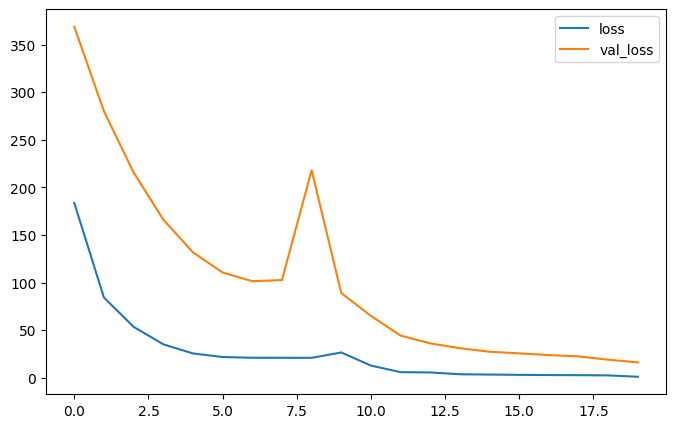

##################################################


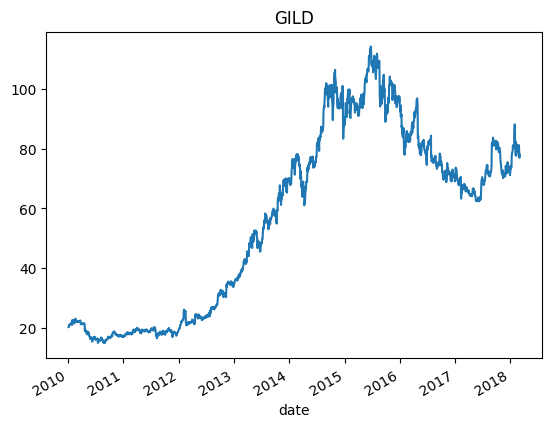

GILD
(2055,)
Epoch 1/20
12/12 [==============================] - 1s 25ms/step - loss: 3238.2476 - val_loss: 4704.9297
Epoch 2/20
12/12 [==============================] - 0s 8ms/step - loss: 2819.0037 - val_loss: 4316.6367
Epoch 3/20
12/12 [==============================] - 0s 8ms/step - loss: 2599.6152 - val_loss: 3989.8767
Epoch 4/20
12/12 [==============================] - 0s 8ms/step - loss: 2413.7903 - val_loss: 3694.4058
Epoch 5/20
12/12 [==============================] - 0s 8ms/step - loss: 2243.7205 - val_loss: 3410.1223
Epoch 6/20
12/12 [==============================] - 0s 8ms/step - loss: 2086.8582 - val_loss: 3141.3123
Epoch 7/20
12/12 [==============================] - 0s 8ms/step - loss: 1942.3146 - val_loss: 2883.6047
Epoch 8/20
12/12 [==============================] - 0s 8ms/step - loss: 1809.3667 - val_loss: 2636.0437
Epoch 9/20
12/12 [==============================] - 0s 8ms/step - loss: 1688.9218 - val_loss: 2408.2400
Epoch 10/20
12/12 [==============================]

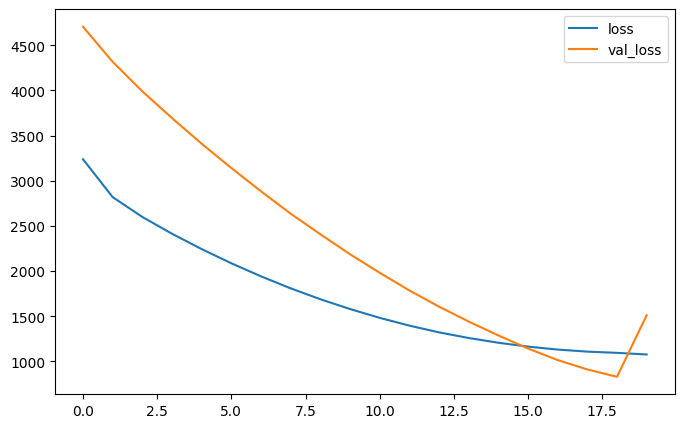

##################################################


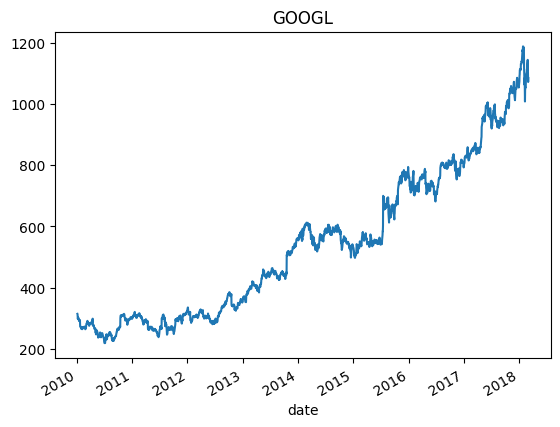

GOOGL
(2055,)
Epoch 1/20
12/12 [==============================] - 1s 25ms/step - loss: 200714.0312 - val_loss: 599667.3750
Epoch 2/20
12/12 [==============================] - 0s 8ms/step - loss: 197123.0000 - val_loss: 595196.8750
Epoch 3/20
12/12 [==============================] - 0s 8ms/step - loss: 194849.3281 - val_loss: 591197.1875
Epoch 4/20
12/12 [==============================] - 0s 8ms/step - loss: 192734.5625 - val_loss: 587332.7500
Epoch 5/20
12/12 [==============================] - 0s 8ms/step - loss: 190655.0312 - val_loss: 583464.6875
Epoch 6/20
12/12 [==============================] - 0s 8ms/step - loss: 188593.9375 - val_loss: 579633.4375
Epoch 7/20
12/12 [==============================] - 0s 9ms/step - loss: 186557.7188 - val_loss: 575837.0625
Epoch 8/20
12/12 [==============================] - 0s 8ms/step - loss: 184534.0938 - val_loss: 572041.6875
Epoch 9/20
12/12 [==============================] - 0s 8ms/step - loss: 182517.3281 - val_loss: 568254.8125
Epoch 10/20
1

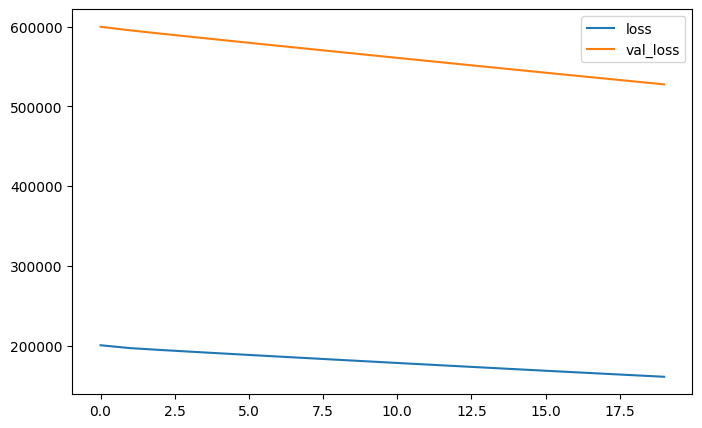

##################################################


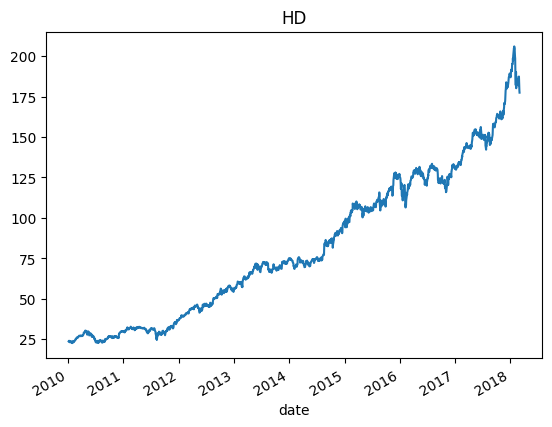

HD
(2055,)
Epoch 1/20
12/12 [==============================] - 1s 25ms/step - loss: 4124.2251 - val_loss: 14314.8809
Epoch 2/20
12/12 [==============================] - 0s 8ms/step - loss: 3636.4087 - val_loss: 13639.8457
Epoch 3/20
12/12 [==============================] - 0s 9ms/step - loss: 3364.6785 - val_loss: 13056.7422
Epoch 4/20
12/12 [==============================] - 0s 8ms/step - loss: 3124.2563 - val_loss: 12506.7227
Epoch 5/20
12/12 [==============================] - 0s 8ms/step - loss: 2900.7241 - val_loss: 11967.3477
Epoch 6/20
12/12 [==============================] - 0s 9ms/step - loss: 2688.7727 - val_loss: 11442.5176
Epoch 7/20
12/12 [==============================] - 0s 8ms/step - loss: 2490.1228 - val_loss: 10933.2451
Epoch 8/20
12/12 [==============================] - 0s 8ms/step - loss: 2305.3479 - val_loss: 10443.8174
Epoch 9/20
12/12 [==============================] - 0s 8ms/step - loss: 2132.9863 - val_loss: 9963.8857
Epoch 10/20
12/12 [=========================

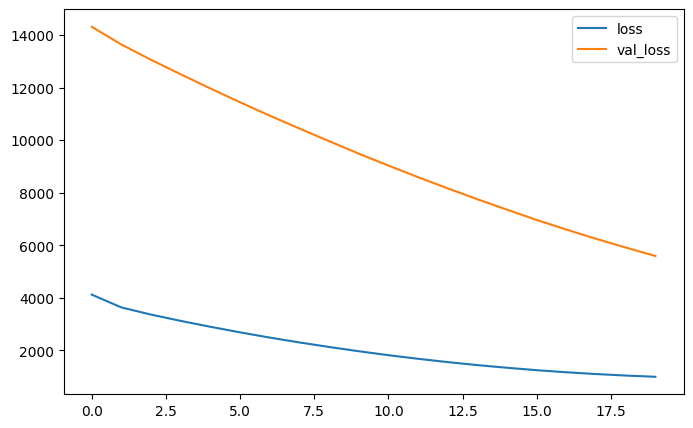

##################################################


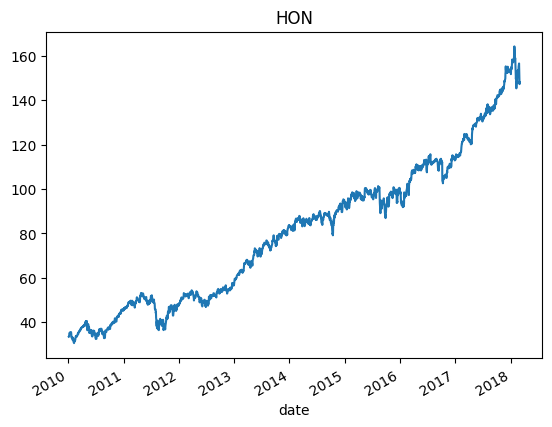

HON
(2055,)
Epoch 1/20
12/12 [==============================] - 2s 26ms/step - loss: 4376.4678 - val_loss: 10958.1621
Epoch 2/20
12/12 [==============================] - 0s 8ms/step - loss: 3863.2532 - val_loss: 10370.7754
Epoch 3/20
12/12 [==============================] - 0s 8ms/step - loss: 3559.7266 - val_loss: 9858.7090
Epoch 4/20
12/12 [==============================] - 0s 8ms/step - loss: 3288.3279 - val_loss: 9376.2275
Epoch 5/20
12/12 [==============================] - 0s 9ms/step - loss: 3034.0662 - val_loss: 8908.0811
Epoch 6/20
12/12 [==============================] - 0s 8ms/step - loss: 2793.4136 - val_loss: 8455.5068
Epoch 7/20
12/12 [==============================] - 0s 8ms/step - loss: 2566.5955 - val_loss: 8018.1396
Epoch 8/20
12/12 [==============================] - 0s 8ms/step - loss: 2351.7175 - val_loss: 7592.2490
Epoch 9/20
12/12 [==============================] - 0s 8ms/step - loss: 2148.6743 - val_loss: 7176.8403
Epoch 10/20
12/12 [==============================

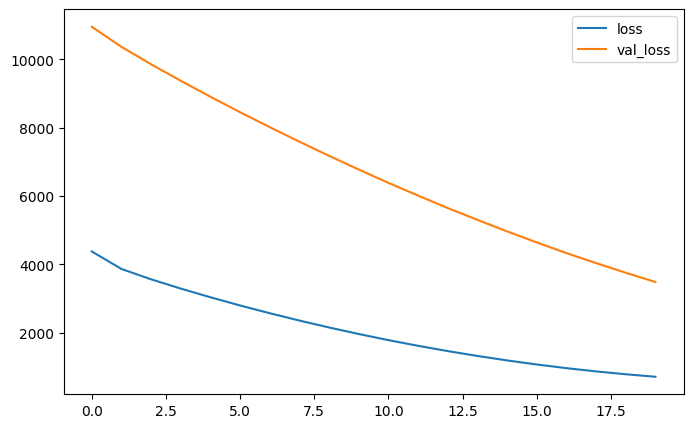

##################################################


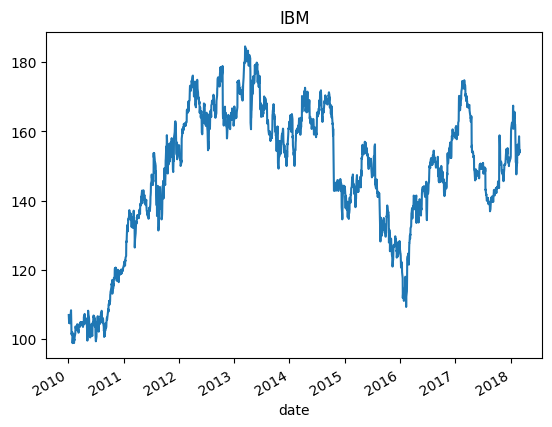

IBM
(2055,)
Epoch 1/20
12/12 [==============================] - 2s 29ms/step - loss: 21144.9023 - val_loss: 20472.8984
Epoch 2/20
12/12 [==============================] - 0s 8ms/step - loss: 19727.7598 - val_loss: 19584.5352
Epoch 3/20
12/12 [==============================] - 0s 8ms/step - loss: 18949.8164 - val_loss: 18857.0801
Epoch 4/20
12/12 [==============================] - 0s 8ms/step - loss: 18256.8770 - val_loss: 18170.8379
Epoch 5/20
12/12 [==============================] - 0s 8ms/step - loss: 17593.0371 - val_loss: 17504.6855
Epoch 6/20
12/12 [==============================] - 0s 8ms/step - loss: 16946.4941 - val_loss: 16854.5391
Epoch 7/20
12/12 [==============================] - 0s 9ms/step - loss: 16315.1807 - val_loss: 16217.7490
Epoch 8/20
12/12 [==============================] - 0s 11ms/step - loss: 15695.7568 - val_loss: 15592.9336
Epoch 9/20
12/12 [==============================] - 0s 10ms/step - loss: 15089.5840 - val_loss: 14981.8789
Epoch 10/20
12/12 [============

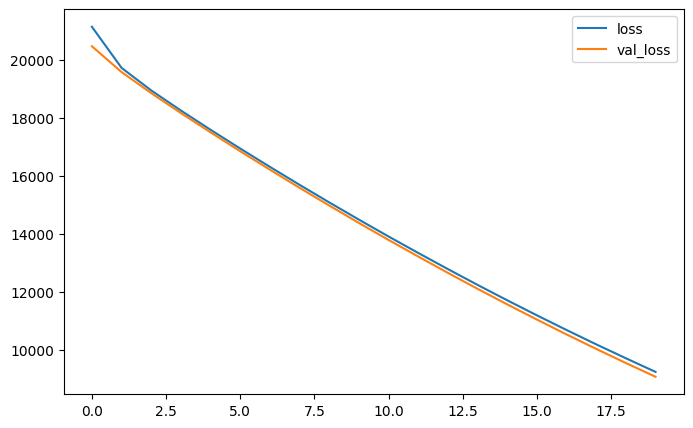

##################################################


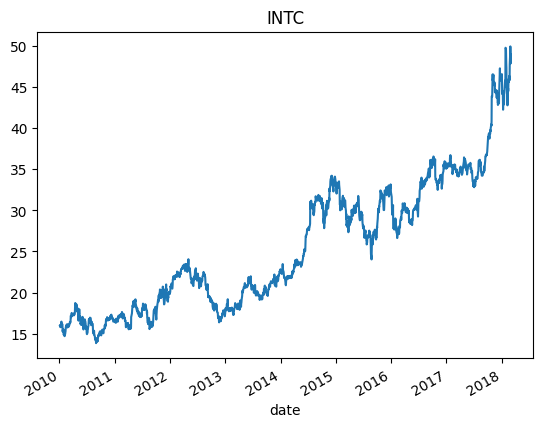

INTC
(2055,)
Epoch 1/20
12/12 [==============================] - 1s 26ms/step - loss: 307.7954 - val_loss: 625.5944
Epoch 2/20
12/12 [==============================] - 0s 8ms/step - loss: 191.9651 - val_loss: 502.7588
Epoch 3/20
12/12 [==============================] - 0s 8ms/step - loss: 135.8117 - val_loss: 406.7859
Epoch 4/20
12/12 [==============================] - 0s 8ms/step - loss: 95.4827 - val_loss: 327.2038
Epoch 5/20
12/12 [==============================] - 0s 8ms/step - loss: 66.4684 - val_loss: 260.5811
Epoch 6/20
12/12 [==============================] - 0s 9ms/step - loss: 46.9446 - val_loss: 206.5289
Epoch 7/20
12/12 [==============================] - 0s 8ms/step - loss: 35.6216 - val_loss: 165.6106
Epoch 8/20
12/12 [==============================] - 0s 8ms/step - loss: 30.5636 - val_loss: 137.4524
Epoch 9/20
12/12 [==============================] - 0s 8ms/step - loss: 29.3018 - val_loss: 129.6889
Epoch 10/20
12/12 [==============================] - 0s 8ms/step - loss: 2

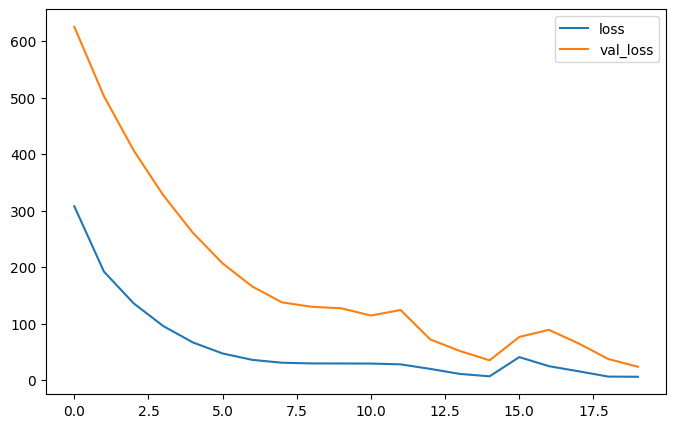

##################################################


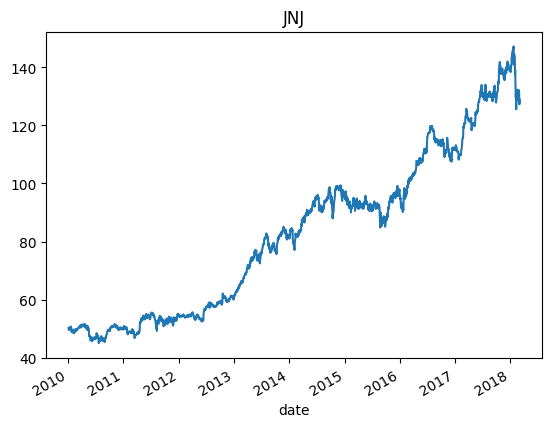

JNJ
(2055,)
Epoch 1/20
12/12 [==============================] - 1s 33ms/step - loss: 4775.1689 - val_loss: 10760.5664
Epoch 2/20
12/12 [==============================] - 0s 11ms/step - loss: 4012.1228 - val_loss: 10117.4424
Epoch 3/20
12/12 [==============================] - 0s 10ms/step - loss: 3673.2952 - val_loss: 9588.9346
Epoch 4/20
12/12 [==============================] - 0s 9ms/step - loss: 3382.4109 - val_loss: 9104.8096
Epoch 5/20
12/12 [==============================] - 0s 9ms/step - loss: 3115.2610 - val_loss: 8642.2549
Epoch 6/20
12/12 [==============================] - 0s 9ms/step - loss: 2863.0820 - val_loss: 8193.6562
Epoch 7/20
12/12 [==============================] - 0s 9ms/step - loss: 2624.3091 - val_loss: 7760.7432
Epoch 8/20
12/12 [==============================] - 0s 9ms/step - loss: 2398.1980 - val_loss: 7338.8105
Epoch 9/20
12/12 [==============================] - 0s 11ms/step - loss: 2184.3857 - val_loss: 6932.2720
Epoch 10/20
12/12 [===========================

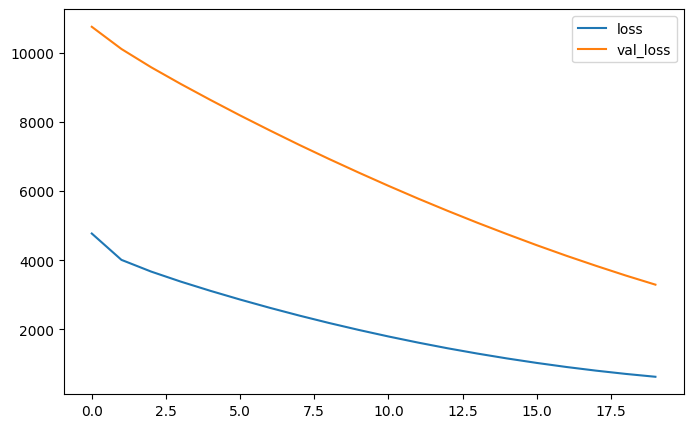

##################################################


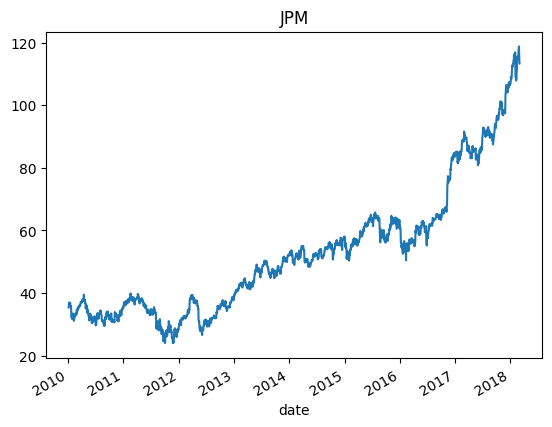

JPM
(2055,)
Epoch 1/20
12/12 [==============================] - 2s 26ms/step - loss: 1606.6453 - val_loss: 3747.1118
Epoch 2/20
12/12 [==============================] - 0s 9ms/step - loss: 1279.6665 - val_loss: 3420.1018
Epoch 3/20
12/12 [==============================] - 0s 8ms/step - loss: 1109.0741 - val_loss: 3140.2837
Epoch 4/20
12/12 [==============================] - 0s 9ms/step - loss: 962.2639 - val_loss: 2882.4983
Epoch 5/20
12/12 [==============================] - 0s 9ms/step - loss: 829.8956 - val_loss: 2636.7588
Epoch 6/20
12/12 [==============================] - 0s 9ms/step - loss: 709.7303 - val_loss: 2406.5703
Epoch 7/20
12/12 [==============================] - 0s 9ms/step - loss: 602.1437 - val_loss: 2188.0959
Epoch 8/20
12/12 [==============================] - 0s 9ms/step - loss: 506.1227 - val_loss: 1982.8461
Epoch 9/20
12/12 [==============================] - 0s 9ms/step - loss: 421.6681 - val_loss: 1790.4285
Epoch 10/20
12/12 [==============================] - 0s 8

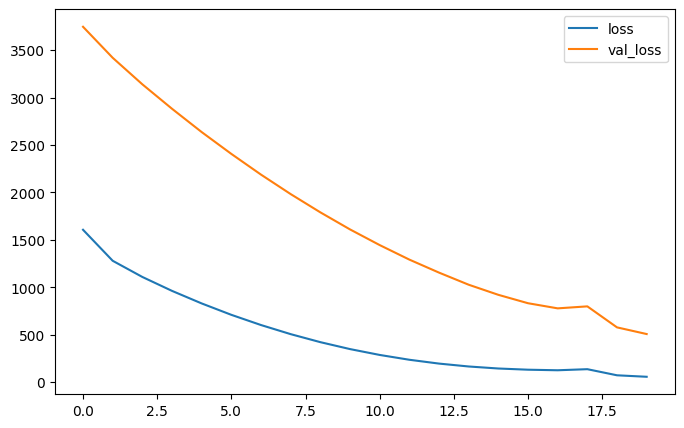

##################################################


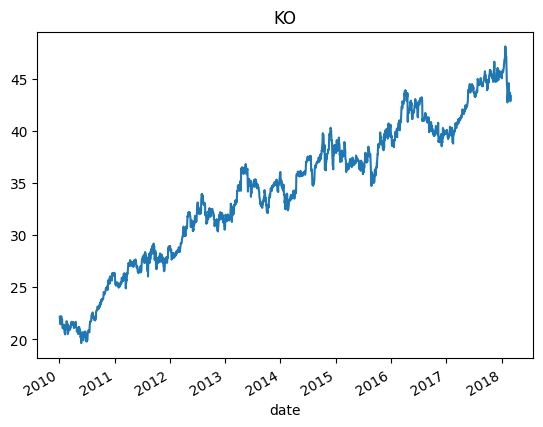

KO
(2055,)
Epoch 1/20
12/12 [==============================] - 1s 26ms/step - loss: 759.2383 - val_loss: 1102.3627
Epoch 2/20
12/12 [==============================] - 0s 8ms/step - loss: 546.5234 - val_loss: 930.0077
Epoch 3/20
12/12 [==============================] - 0s 8ms/step - loss: 437.3346 - val_loss: 788.8479
Epoch 4/20
12/12 [==============================] - 0s 8ms/step - loss: 347.5324 - val_loss: 664.3563
Epoch 5/20
12/12 [==============================] - 0s 9ms/step - loss: 271.1196 - val_loss: 552.6822
Epoch 6/20
12/12 [==============================] - 0s 9ms/step - loss: 206.2689 - val_loss: 452.8979
Epoch 7/20
12/12 [==============================] - 0s 9ms/step - loss: 152.5290 - val_loss: 365.3686
Epoch 8/20
12/12 [==============================] - 0s 8ms/step - loss: 109.7762 - val_loss: 289.9393
Epoch 9/20
12/12 [==============================] - 0s 10ms/step - loss: 77.2785 - val_loss: 225.7354
Epoch 10/20
12/12 [==============================] - 0s 11ms/step - l

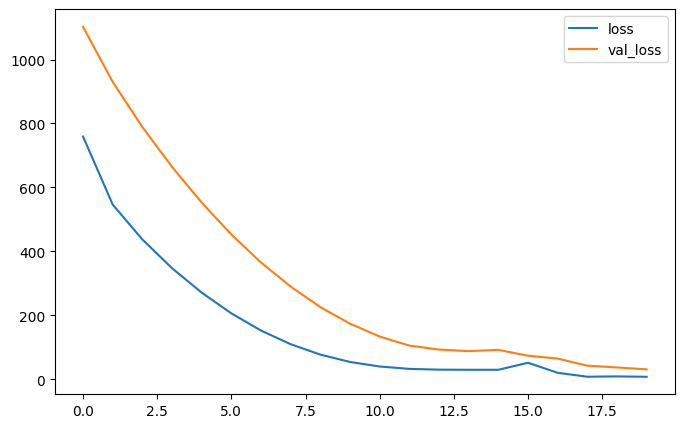

##################################################


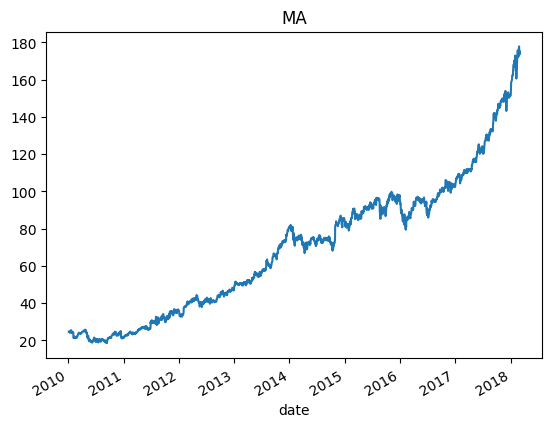

MA
(2055,)
Epoch 1/20
12/12 [==============================] - 2s 47ms/step - loss: 2917.1992 - val_loss: 7988.2334
Epoch 2/20
12/12 [==============================] - 0s 12ms/step - loss: 2523.9373 - val_loss: 7498.3931
Epoch 3/20
12/12 [==============================] - 0s 13ms/step - loss: 2303.3130 - val_loss: 7073.7144
Epoch 4/20
12/12 [==============================] - 0s 12ms/step - loss: 2109.9377 - val_loss: 6676.1553
Epoch 5/20
12/12 [==============================] - 0s 12ms/step - loss: 1932.0306 - val_loss: 6292.9106
Epoch 6/20
12/12 [==============================] - 0s 12ms/step - loss: 1765.6957 - val_loss: 5920.1211
Epoch 7/20
12/12 [==============================] - 0s 12ms/step - loss: 1611.0522 - val_loss: 5560.1147
Epoch 8/20
12/12 [==============================] - 0s 13ms/step - loss: 1469.2988 - val_loss: 5215.5210
Epoch 9/20
12/12 [==============================] - 0s 13ms/step - loss: 1338.9788 - val_loss: 4882.1758
Epoch 10/20
12/12 [=========================

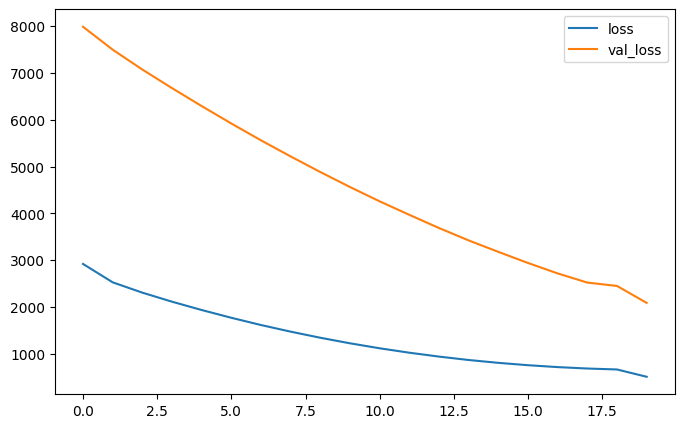

##################################################


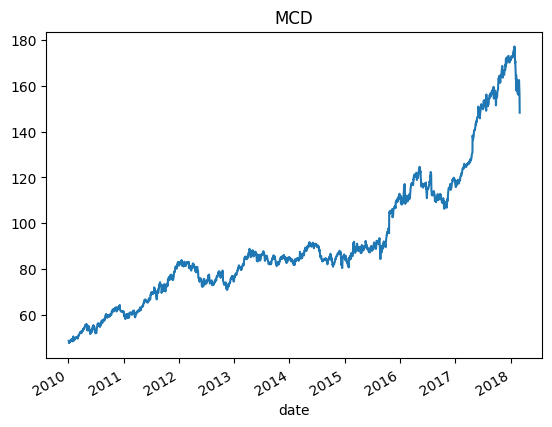

MCD
(2055,)
Epoch 1/20
12/12 [==============================] - 1s 29ms/step - loss: 5604.8115 - val_loss: 11592.1084
Epoch 2/20
12/12 [==============================] - 0s 9ms/step - loss: 4946.4072 - val_loss: 10983.0586
Epoch 3/20
12/12 [==============================] - 0s 9ms/step - loss: 4582.4390 - val_loss: 10453.9014
Epoch 4/20
12/12 [==============================] - 0s 9ms/step - loss: 4255.2070 - val_loss: 9954.1748
Epoch 5/20
12/12 [==============================] - 0s 10ms/step - loss: 3946.6050 - val_loss: 9470.4658
Epoch 6/20
12/12 [==============================] - 0s 10ms/step - loss: 3651.6201 - val_loss: 9001.3115
Epoch 7/20
12/12 [==============================] - 0s 9ms/step - loss: 3370.5615 - val_loss: 8545.8008
Epoch 8/20
12/12 [==============================] - 0s 11ms/step - loss: 3100.8184 - val_loss: 8100.5415
Epoch 9/20
12/12 [==============================] - 0s 8ms/step - loss: 2843.4312 - val_loss: 7669.5112
Epoch 10/20
12/12 [==========================

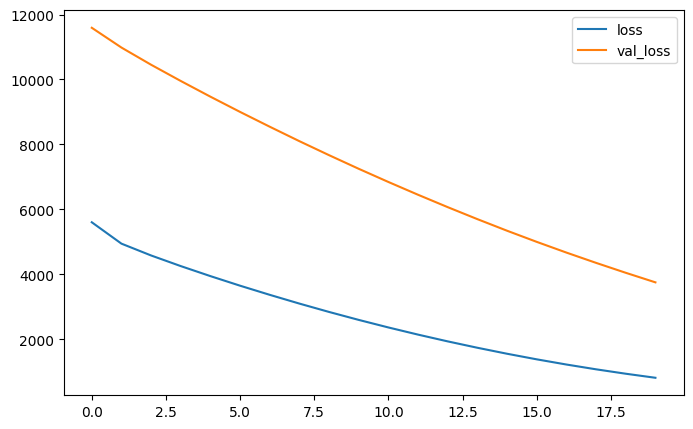

##################################################


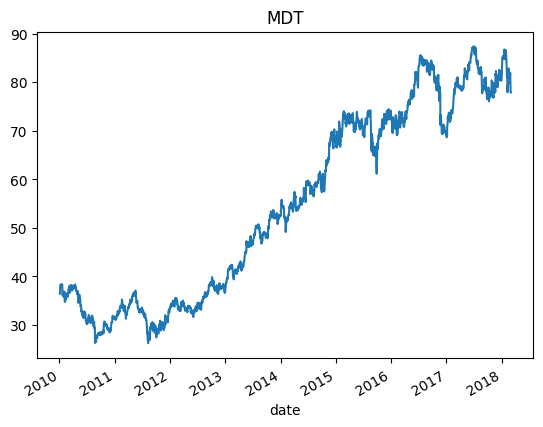

MDT
(2055,)
Epoch 1/20
12/12 [==============================] - 1s 26ms/step - loss: 1932.6896 - val_loss: 4886.4219
Epoch 2/20
12/12 [==============================] - 0s 9ms/step - loss: 1591.0374 - val_loss: 4501.4009
Epoch 3/20
12/12 [==============================] - 0s 11ms/step - loss: 1403.8384 - val_loss: 4173.0815
Epoch 4/20
12/12 [==============================] - 0s 12ms/step - loss: 1242.3217 - val_loss: 3869.9656
Epoch 5/20
12/12 [==============================] - 0s 9ms/step - loss: 1095.9773 - val_loss: 3580.1194
Epoch 6/20
12/12 [==============================] - 0s 8ms/step - loss: 961.9625 - val_loss: 3302.8242
Epoch 7/20
12/12 [==============================] - 0s 9ms/step - loss: 840.4745 - val_loss: 3040.4009
Epoch 8/20
12/12 [==============================] - 0s 8ms/step - loss: 731.1522 - val_loss: 2791.6367
Epoch 9/20
12/12 [==============================] - 0s 9ms/step - loss: 633.2848 - val_loss: 2554.1680
Epoch 10/20
12/12 [==============================] - 

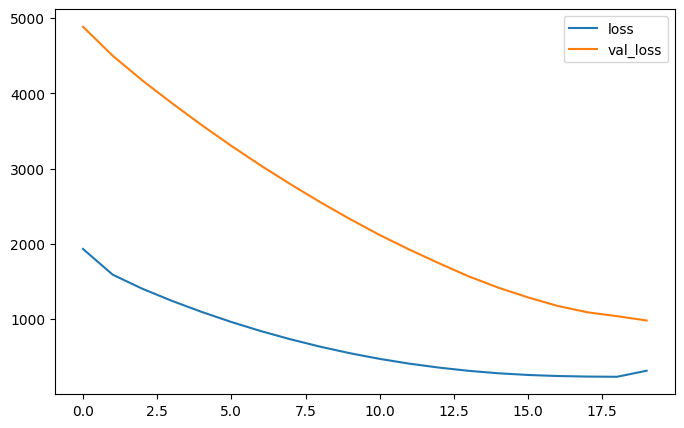

##################################################


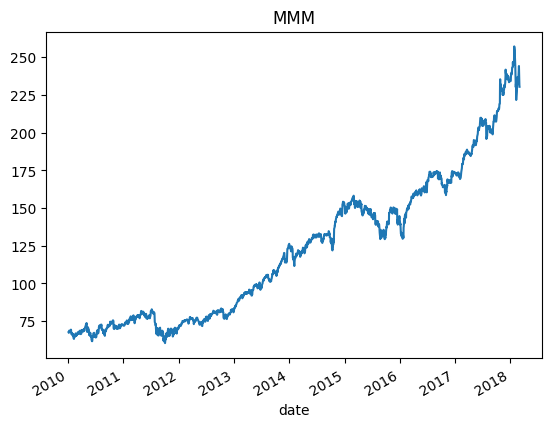

MMM
(2055,)
Epoch 1/20
12/12 [==============================] - 1s 26ms/step - loss: 10196.3906 - val_loss: 25512.1230
Epoch 2/20
12/12 [==============================] - 0s 9ms/step - loss: 9287.1094 - val_loss: 24587.8555
Epoch 3/20
12/12 [==============================] - 0s 8ms/step - loss: 8795.2627 - val_loss: 23781.4902
Epoch 4/20
12/12 [==============================] - 0s 9ms/step - loss: 8350.4072 - val_loss: 23017.8730
Epoch 5/20
12/12 [==============================] - 0s 9ms/step - loss: 7927.8672 - val_loss: 22272.5703
Epoch 6/20
12/12 [==============================] - 0s 10ms/step - loss: 7520.5308 - val_loss: 21543.4258
Epoch 7/20
12/12 [==============================] - 0s 9ms/step - loss: 7127.1602 - val_loss: 20831.0566
Epoch 8/20
12/12 [==============================] - 0s 9ms/step - loss: 6747.5083 - val_loss: 20129.6387
Epoch 9/20
12/12 [==============================] - 0s 8ms/step - loss: 6378.6465 - val_loss: 19438.2090
Epoch 10/20
12/12 [=====================

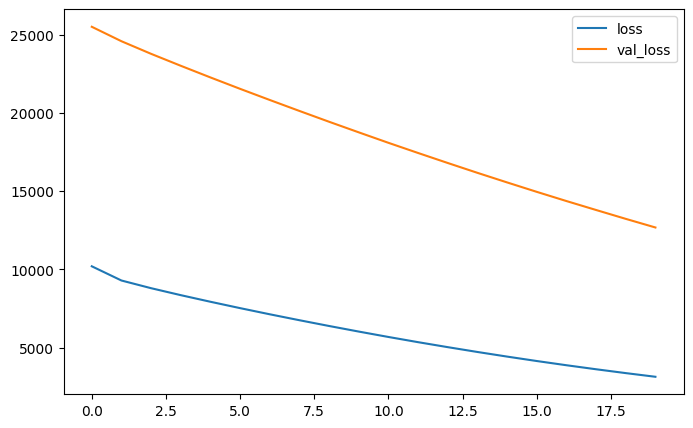

##################################################


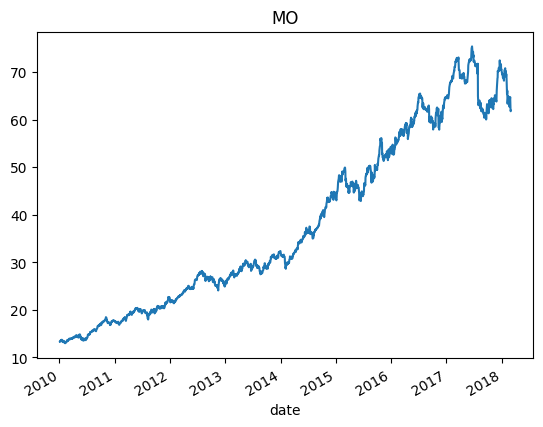

MO
(2055,)
Epoch 1/20
12/12 [==============================] - 1s 26ms/step - loss: 675.1310 - val_loss: 2734.5586
Epoch 2/20
12/12 [==============================] - 0s 9ms/step - loss: 487.0213 - val_loss: 2463.3215
Epoch 3/20
12/12 [==============================] - 0s 9ms/step - loss: 399.2422 - val_loss: 2233.8237
Epoch 4/20
12/12 [==============================] - 0s 9ms/step - loss: 329.4984 - val_loss: 2026.6230
Epoch 5/20
12/12 [==============================] - 0s 9ms/step - loss: 272.6382 - val_loss: 1834.3992
Epoch 6/20
12/12 [==============================] - 0s 9ms/step - loss: 226.7599 - val_loss: 1658.9320
Epoch 7/20
12/12 [==============================] - 0s 9ms/step - loss: 191.6048 - val_loss: 1499.4185
Epoch 8/20
12/12 [==============================] - 0s 10ms/step - loss: 166.3426 - val_loss: 1357.7371
Epoch 9/20
12/12 [==============================] - 0s 10ms/step - loss: 149.4638 - val_loss: 1218.0490
Epoch 10/20
12/12 [==============================] - 0s 8ms

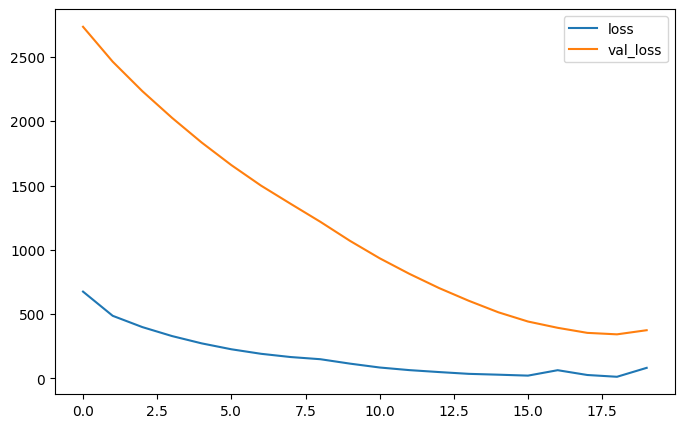

##################################################


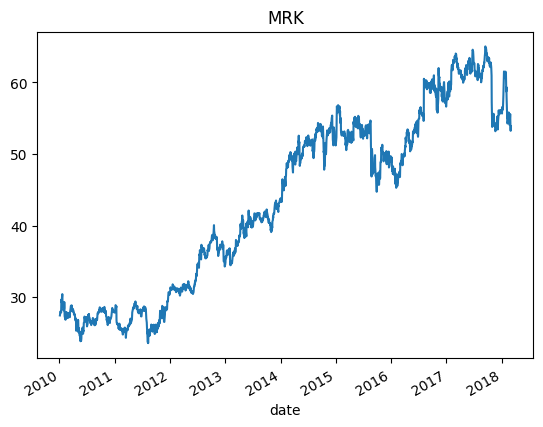

MRK
(2055,)
Epoch 1/20
12/12 [==============================] - 1s 28ms/step - loss: 1226.3346 - val_loss: 2357.6824
Epoch 2/20
12/12 [==============================] - 0s 9ms/step - loss: 937.2377 - val_loss: 2084.7993
Epoch 3/20
12/12 [==============================] - 0s 9ms/step - loss: 789.2947 - val_loss: 1862.6825
Epoch 4/20
12/12 [==============================] - 0s 8ms/step - loss: 667.7062 - val_loss: 1663.5509
Epoch 5/20
12/12 [==============================] - 0s 8ms/step - loss: 561.8375 - val_loss: 1480.6260
Epoch 6/20
12/12 [==============================] - 0s 9ms/step - loss: 468.3530 - val_loss: 1308.6160
Epoch 7/20
12/12 [==============================] - 0s 9ms/step - loss: 385.9055 - val_loss: 1148.6465
Epoch 8/20
12/12 [==============================] - 0s 9ms/step - loss: 315.3346 - val_loss: 1003.4382
Epoch 9/20
12/12 [==============================] - 0s 9ms/step - loss: 256.2597 - val_loss: 870.2427
Epoch 10/20
12/12 [==============================] - 0s 9ms/

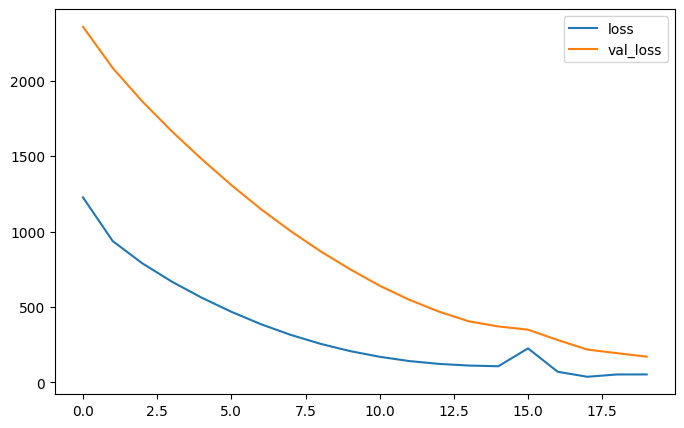

##################################################


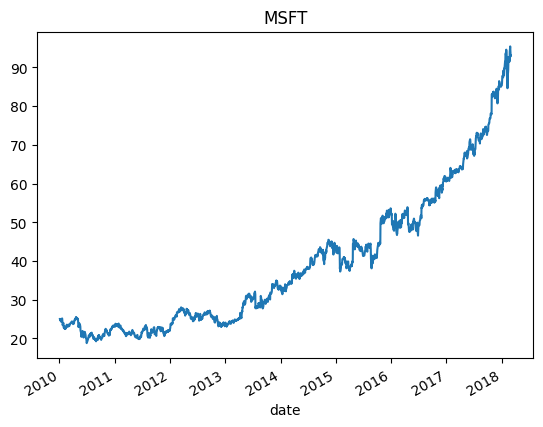

MSFT
(2055,)
Epoch 1/20
12/12 [==============================] - 1s 28ms/step - loss: 665.6629 - val_loss: 2132.1565
Epoch 2/20
12/12 [==============================] - 0s 9ms/step - loss: 479.9987 - val_loss: 1890.9042
Epoch 3/20
12/12 [==============================] - 0s 8ms/step - loss: 385.9149 - val_loss: 1690.4171
Epoch 4/20
12/12 [==============================] - 0s 9ms/step - loss: 310.4470 - val_loss: 1510.0002
Epoch 5/20
12/12 [==============================] - 0s 9ms/step - loss: 247.7944 - val_loss: 1343.5244
Epoch 6/20
12/12 [==============================] - 0s 9ms/step - loss: 196.5285 - val_loss: 1191.7748
Epoch 7/20
12/12 [==============================] - 0s 9ms/step - loss: 155.9150 - val_loss: 1052.9325
Epoch 8/20
12/12 [==============================] - 0s 9ms/step - loss: 125.6588 - val_loss: 932.6058
Epoch 9/20
12/12 [==============================] - 0s 8ms/step - loss: 104.8896 - val_loss: 825.4313
Epoch 10/20
12/12 [==============================] - 0s 8ms/s

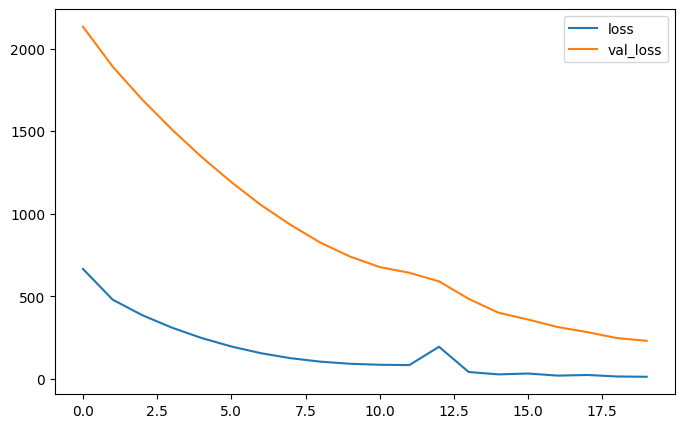

##################################################


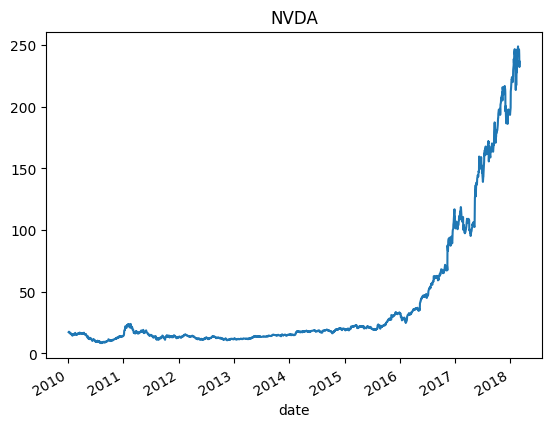

NVDA
(2055,)
Epoch 1/20
12/12 [==============================] - 2s 27ms/step - loss: 159.8913 - val_loss: 4598.6230
Epoch 2/20
12/12 [==============================] - 0s 9ms/step - loss: 66.9686 - val_loss: 4161.6621
Epoch 3/20
12/12 [==============================] - 0s 9ms/step - loss: 42.6326 - val_loss: 3870.6033
Epoch 4/20
12/12 [==============================] - 0s 10ms/step - loss: 30.4389 - val_loss: 3665.1255
Epoch 5/20
12/12 [==============================] - 0s 9ms/step - loss: 25.0996 - val_loss: 3508.0999
Epoch 6/20
12/12 [==============================] - 0s 8ms/step - loss: 24.1554 - val_loss: 3330.4944
Epoch 7/20
12/12 [==============================] - 0s 9ms/step - loss: 15.9063 - val_loss: 3189.5015
Epoch 8/20
12/12 [==============================] - 0s 8ms/step - loss: 9.6888 - val_loss: 3012.1306
Epoch 9/20
12/12 [==============================] - 0s 10ms/step - loss: 6.7152 - val_loss: 2856.8516
Epoch 10/20
12/12 [==============================] - 0s 9ms/step - 

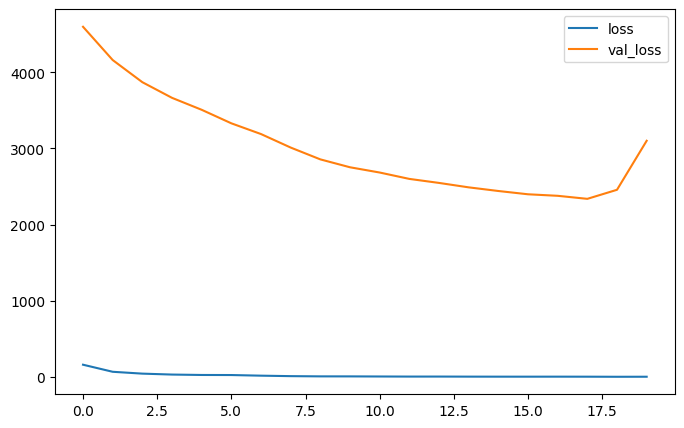

##################################################


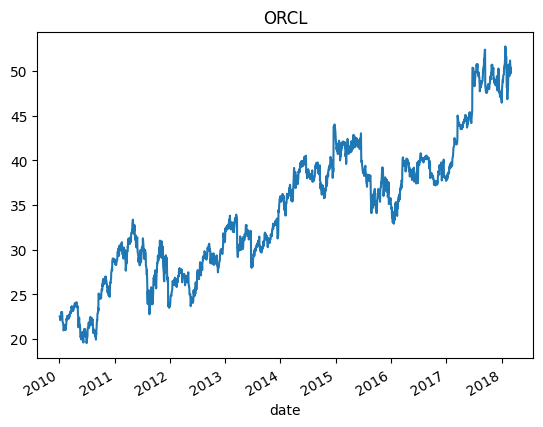

ORCL
(2055,)
Epoch 1/20
12/12 [==============================] - 1s 28ms/step - loss: 744.2185 - val_loss: 966.3162
Epoch 2/20
12/12 [==============================] - 0s 8ms/step - loss: 534.8704 - val_loss: 802.2308
Epoch 3/20
12/12 [==============================] - 0s 9ms/step - loss: 425.6424 - val_loss: 670.9909
Epoch 4/20
12/12 [==============================] - 0s 9ms/step - loss: 337.6619 - val_loss: 556.5317
Epoch 5/20
12/12 [==============================] - 0s 9ms/step - loss: 263.0927 - val_loss: 454.5654
Epoch 6/20
12/12 [==============================] - 0s 10ms/step - loss: 200.3209 - val_loss: 365.3927
Epoch 7/20
12/12 [==============================] - 0s 9ms/step - loss: 149.0232 - val_loss: 287.8607
Epoch 8/20
12/12 [==============================] - 0s 9ms/step - loss: 108.1555 - val_loss: 221.5217
Epoch 9/20
12/12 [==============================] - 0s 8ms/step - loss: 77.2748 - val_loss: 166.1631
Epoch 10/20
12/12 [==============================] - 0s 9ms/step - l

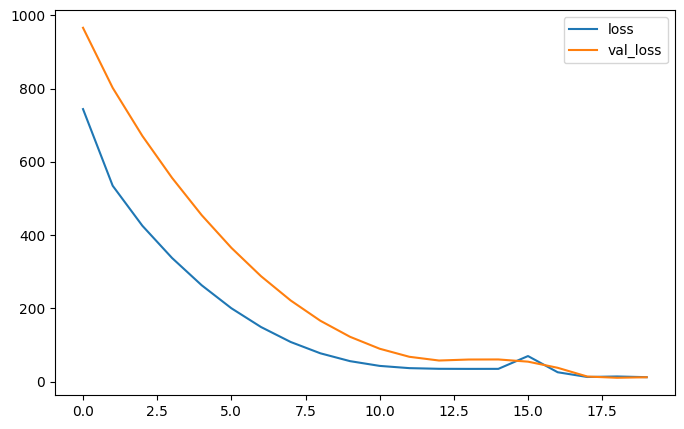

##################################################


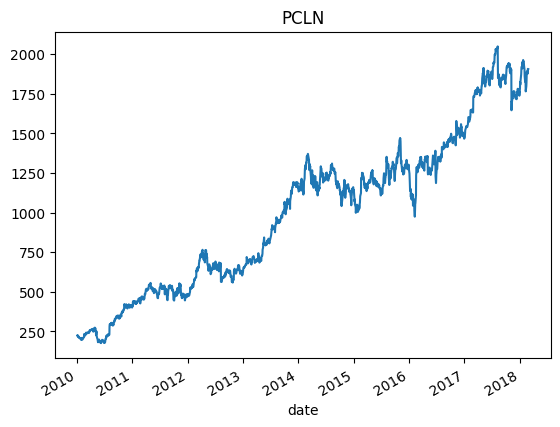

PCLN
(2055,)
Epoch 1/20
12/12 [==============================] - 1s 29ms/step - loss: 760231.2500 - val_loss: 2016089.1250
Epoch 2/20
12/12 [==============================] - 0s 10ms/step - loss: 752980.3750 - val_loss: 2007809.3750
Epoch 3/20
12/12 [==============================] - 0s 10ms/step - loss: 748641.0625 - val_loss: 2000431.8750
Epoch 4/20
12/12 [==============================] - 0s 11ms/step - loss: 744591.2500 - val_loss: 1993273.2500
Epoch 5/20
12/12 [==============================] - 0s 10ms/step - loss: 740610.6250 - val_loss: 1986150.0000
Epoch 6/20
12/12 [==============================] - 0s 10ms/step - loss: 736678.8750 - val_loss: 1979141.3750
Epoch 7/20
12/12 [==============================] - 0s 10ms/step - loss: 732773.7500 - val_loss: 1972099.7500
Epoch 8/20
12/12 [==============================] - 0s 10ms/step - loss: 728862.3125 - val_loss: 1965058.0000
Epoch 9/20
12/12 [==============================] - 0s 9ms/step - loss: 724953.3750 - val_loss: 1958001.000

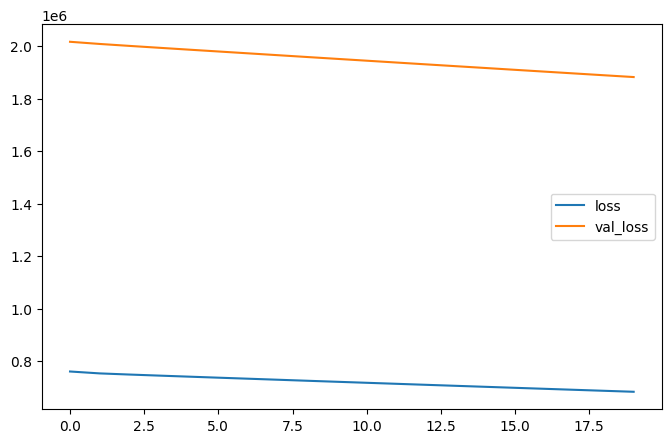

##################################################


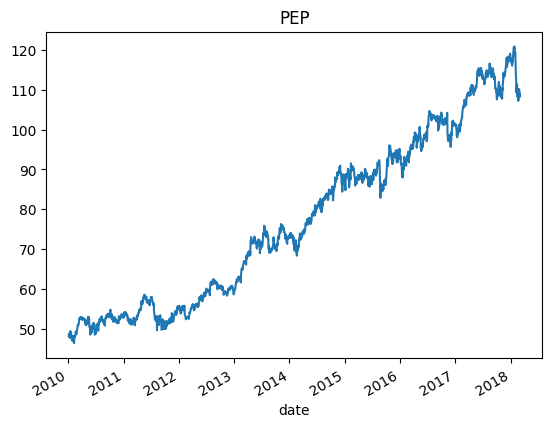

PEP
(2055,)
Epoch 1/20
12/12 [==============================] - 1s 30ms/step - loss: 4175.6245 - val_loss: 8604.7480
Epoch 2/20
12/12 [==============================] - 0s 10ms/step - loss: 3674.3489 - val_loss: 8093.4087
Epoch 3/20
12/12 [==============================] - 0s 9ms/step - loss: 3370.1685 - val_loss: 7644.9624
Epoch 4/20
12/12 [==============================] - 0s 9ms/step - loss: 3095.9202 - val_loss: 7220.0464
Epoch 5/20
12/12 [==============================] - 0s 8ms/step - loss: 2838.6697 - val_loss: 6811.2158
Epoch 6/20
12/12 [==============================] - 0s 8ms/step - loss: 2595.5681 - val_loss: 6417.8652
Epoch 7/20
12/12 [==============================] - 0s 8ms/step - loss: 2365.2019 - val_loss: 6036.5791
Epoch 8/20
12/12 [==============================] - 0s 8ms/step - loss: 2146.1499 - val_loss: 5665.5815
Epoch 9/20
12/12 [==============================] - 0s 9ms/step - loss: 1939.7565 - val_loss: 5309.3657
Epoch 10/20
12/12 [==============================]

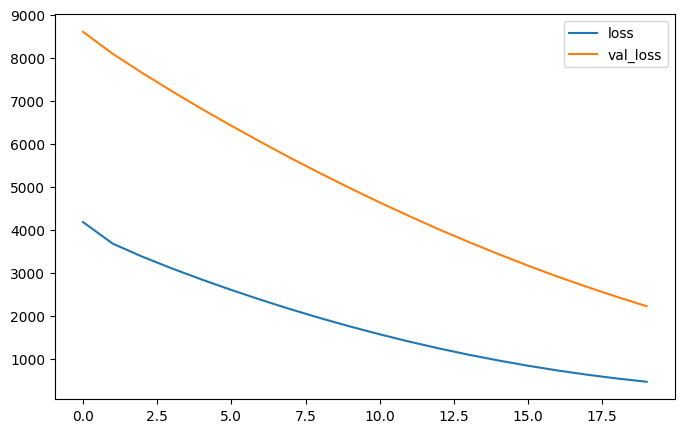

##################################################


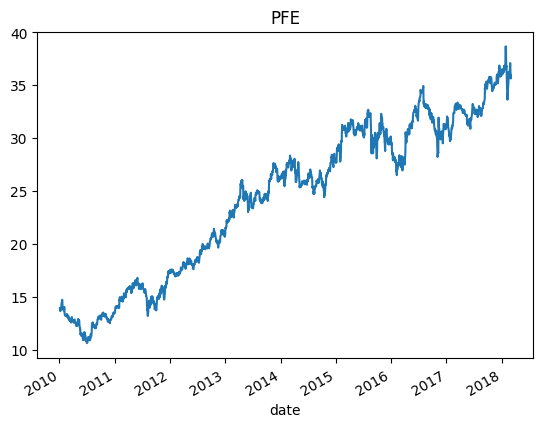

PFE
(2055,)
Epoch 1/20
12/12 [==============================] - 1s 28ms/step - loss: 322.6165 - val_loss: 555.7330
Epoch 2/20
12/12 [==============================] - 0s 10ms/step - loss: 191.1634 - val_loss: 429.4364
Epoch 3/20
12/12 [==============================] - 0s 8ms/step - loss: 135.0860 - val_loss: 339.8076
Epoch 4/20
12/12 [==============================] - 0s 8ms/step - loss: 97.3805 - val_loss: 267.5687
Epoch 5/20
12/12 [==============================] - 0s 9ms/step - loss: 71.1263 - val_loss: 208.2196
Epoch 6/20
12/12 [==============================] - 0s 9ms/step - loss: 54.1937 - val_loss: 162.3267
Epoch 7/20
12/12 [==============================] - 0s 8ms/step - loss: 45.0464 - val_loss: 127.8579
Epoch 8/20
12/12 [==============================] - 0s 9ms/step - loss: 41.3656 - val_loss: 106.8899
Epoch 9/20
12/12 [==============================] - 0s 9ms/step - loss: 78.1317 - val_loss: 101.1940
Epoch 10/20
12/12 [==============================] - 0s 8ms/step - loss: 4

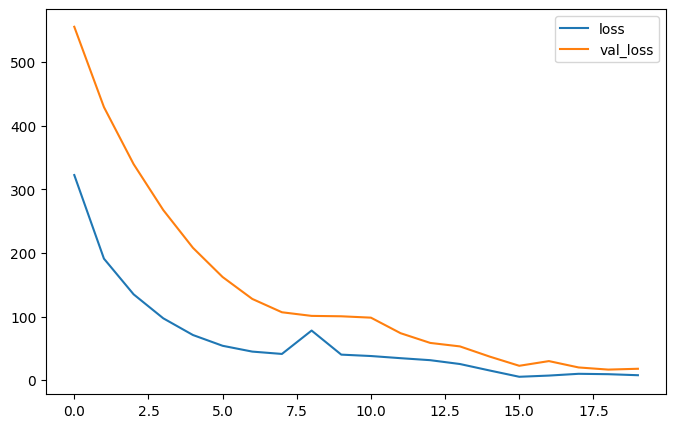

##################################################


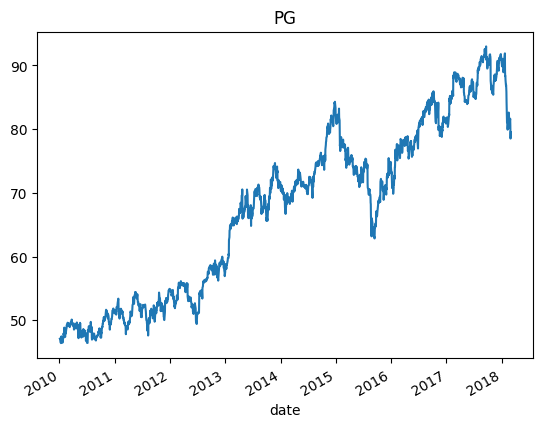

PG
(2055,)
Epoch 1/20
12/12 [==============================] - 1s 27ms/step - loss: 3510.5789 - val_loss: 5521.1621
Epoch 2/20
12/12 [==============================] - 0s 8ms/step - loss: 2993.1462 - val_loss: 5098.1738
Epoch 3/20
12/12 [==============================] - 0s 9ms/step - loss: 2710.7129 - val_loss: 4741.1323
Epoch 4/20
12/12 [==============================] - 0s 9ms/step - loss: 2462.2441 - val_loss: 4409.1875
Epoch 5/20
12/12 [==============================] - 0s 9ms/step - loss: 2230.7908 - val_loss: 4091.5671
Epoch 6/20
12/12 [==============================] - 0s 8ms/step - loss: 2012.6703 - val_loss: 3787.4226
Epoch 7/20
12/12 [==============================] - 0s 8ms/step - loss: 1808.0037 - val_loss: 3497.7053
Epoch 8/20
12/12 [==============================] - 0s 10ms/step - loss: 1615.2499 - val_loss: 3218.2126
Epoch 9/20
12/12 [==============================] - 0s 9ms/step - loss: 1434.6819 - val_loss: 2953.4685
Epoch 10/20
12/12 [==============================] 

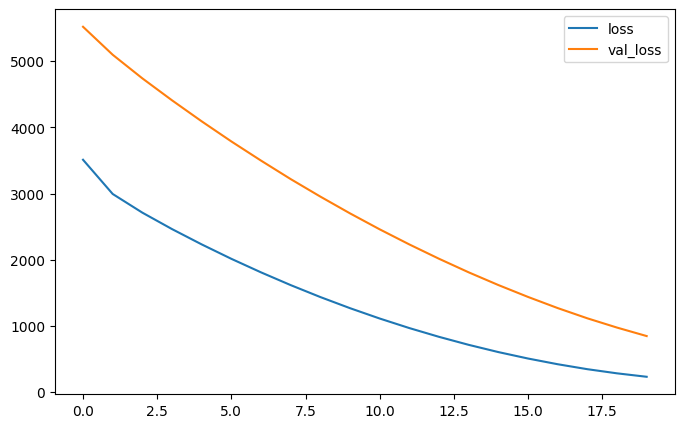

##################################################


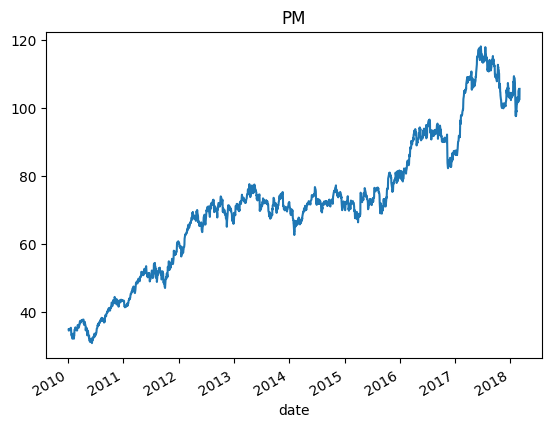

PM
(2055,)
Epoch 1/20
12/12 [==============================] - 1s 27ms/step - loss: 3586.5049 - val_loss: 6953.2358
Epoch 2/20
12/12 [==============================] - 0s 9ms/step - loss: 3066.0984 - val_loss: 6471.5703
Epoch 3/20
12/12 [==============================] - 0s 10ms/step - loss: 2782.1204 - val_loss: 6067.7764
Epoch 4/20
12/12 [==============================] - 0s 9ms/step - loss: 2533.0457 - val_loss: 5689.3350
Epoch 5/20
12/12 [==============================] - 0s 9ms/step - loss: 2302.0562 - val_loss: 5330.1328
Epoch 6/20
12/12 [==============================] - 0s 9ms/step - loss: 2085.2969 - val_loss: 4983.4604
Epoch 7/20
12/12 [==============================] - 0s 9ms/step - loss: 1880.5106 - val_loss: 4648.3525
Epoch 8/20
12/12 [==============================] - 0s 9ms/step - loss: 1687.5918 - val_loss: 4325.6758
Epoch 9/20
12/12 [==============================] - 0s 8ms/step - loss: 1507.2860 - val_loss: 4016.8950
Epoch 10/20
12/12 [==============================] 

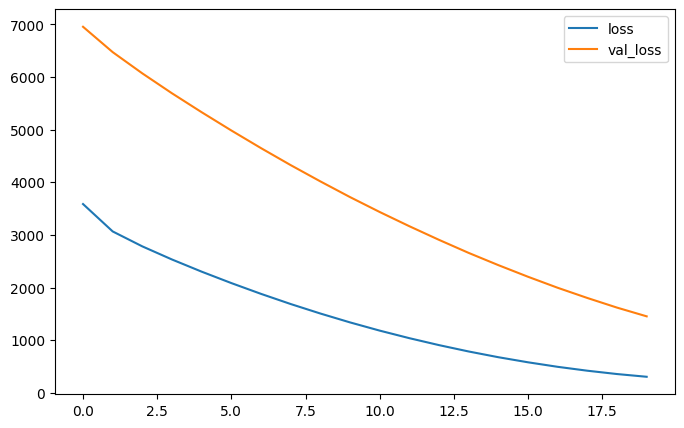

##################################################


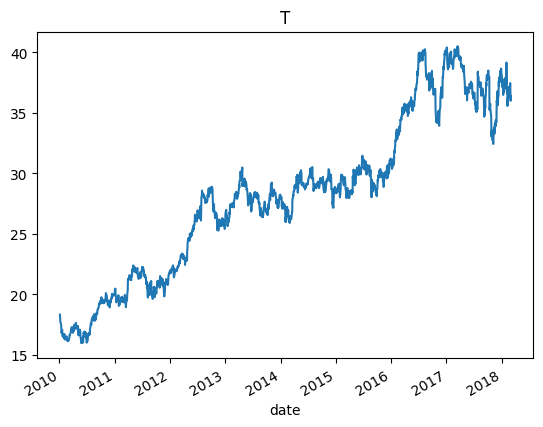

T
(2055,)
Epoch 1/20
12/12 [==============================] - 1s 26ms/step - loss: 447.8762 - val_loss: 883.3538
Epoch 2/20
12/12 [==============================] - 0s 9ms/step - loss: 279.9181 - val_loss: 727.5255
Epoch 3/20
12/12 [==============================] - 0s 8ms/step - loss: 205.1006 - val_loss: 606.6442
Epoch 4/20
12/12 [==============================] - 0s 9ms/step - loss: 148.3954 - val_loss: 502.9891
Epoch 5/20
12/12 [==============================] - 0s 8ms/step - loss: 103.9307 - val_loss: 412.3174
Epoch 6/20
12/12 [==============================] - 0s 8ms/step - loss: 70.1964 - val_loss: 334.9459
Epoch 7/20
12/12 [==============================] - 0s 9ms/step - loss: 46.3227 - val_loss: 269.5390
Epoch 8/20
12/12 [==============================] - 0s 8ms/step - loss: 31.1198 - val_loss: 218.5342
Epoch 9/20
12/12 [==============================] - 0s 9ms/step - loss: 23.4244 - val_loss: 181.3217
Epoch 10/20
12/12 [==============================] - 0s 8ms/step - loss: 20

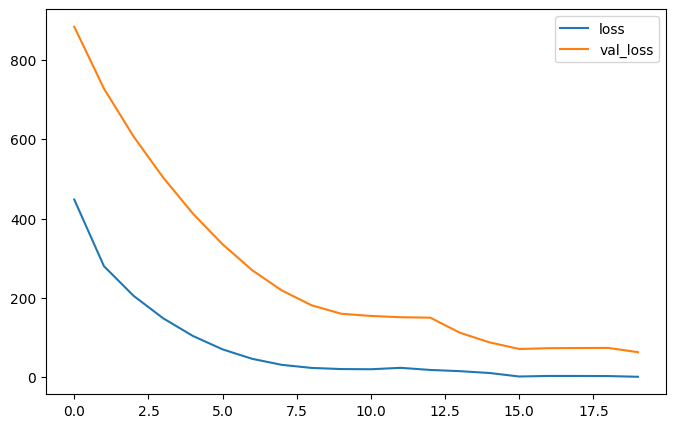

##################################################


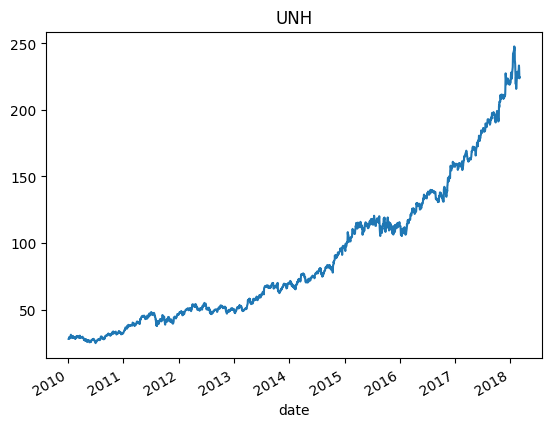

UNH
(2055,)
Epoch 1/20
12/12 [==============================] - 1s 29ms/step - loss: 4178.2007 - val_loss: 17669.7109
Epoch 2/20
12/12 [==============================] - 0s 8ms/step - loss: 3691.8882 - val_loss: 16928.7109
Epoch 3/20
12/12 [==============================] - 0s 12ms/step - loss: 3412.3740 - val_loss: 16282.4561
Epoch 4/20
12/12 [==============================] - 0s 13ms/step - loss: 3163.4470 - val_loss: 15662.8584
Epoch 5/20
12/12 [==============================] - 0s 11ms/step - loss: 2928.9021 - val_loss: 15058.3525
Epoch 6/20
12/12 [==============================] - 0s 11ms/step - loss: 2708.8657 - val_loss: 14475.8037
Epoch 7/20
12/12 [==============================] - 0s 11ms/step - loss: 2502.5005 - val_loss: 13901.9893
Epoch 8/20
12/12 [==============================] - 0s 11ms/step - loss: 2307.9561 - val_loss: 13345.7734
Epoch 9/20
12/12 [==============================] - 0s 12ms/step - loss: 2126.1167 - val_loss: 12801.4473
Epoch 10/20
12/12 [================

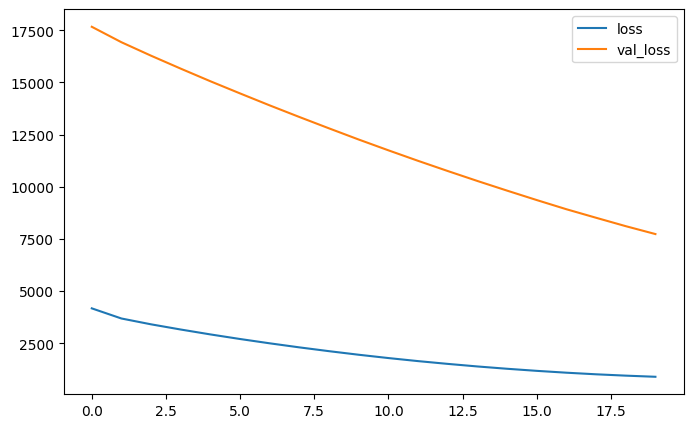

##################################################


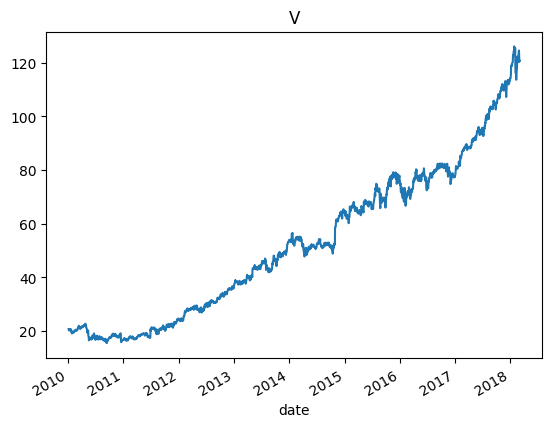

V
(2055,)
Epoch 1/20
12/12 [==============================] - 1s 27ms/step - loss: 1629.0728 - val_loss: 5189.8281
Epoch 2/20
12/12 [==============================] - 0s 10ms/step - loss: 1363.4211 - val_loss: 4797.3613
Epoch 3/20
12/12 [==============================] - 0s 9ms/step - loss: 1206.5151 - val_loss: 4464.5830
Epoch 4/20
12/12 [==============================] - 0s 9ms/step - loss: 1071.8165 - val_loss: 4149.8242
Epoch 5/20
12/12 [==============================] - 0s 9ms/step - loss: 951.7874 - val_loss: 3856.4790
Epoch 6/20
12/12 [==============================] - 0s 9ms/step - loss: 844.3555 - val_loss: 3571.9294
Epoch 7/20
12/12 [==============================] - 0s 9ms/step - loss: 748.3580 - val_loss: 3302.1895
Epoch 8/20
12/12 [==============================] - 0s 10ms/step - loss: 663.9999 - val_loss: 3047.5437
Epoch 9/20
12/12 [==============================] - 0s 9ms/step - loss: 590.9958 - val_loss: 2806.0156
Epoch 10/20
12/12 [==============================] - 0s 

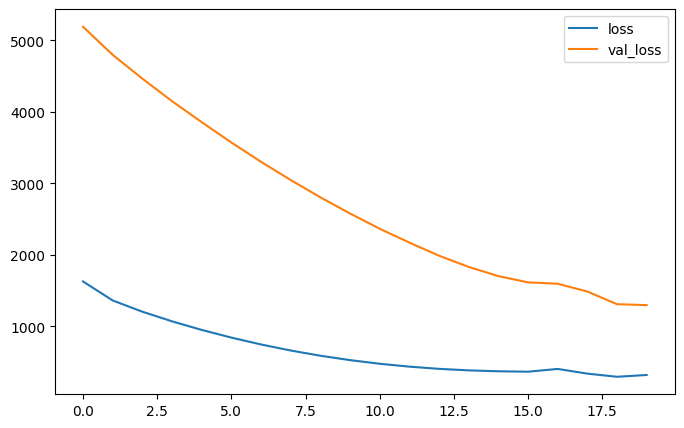

##################################################


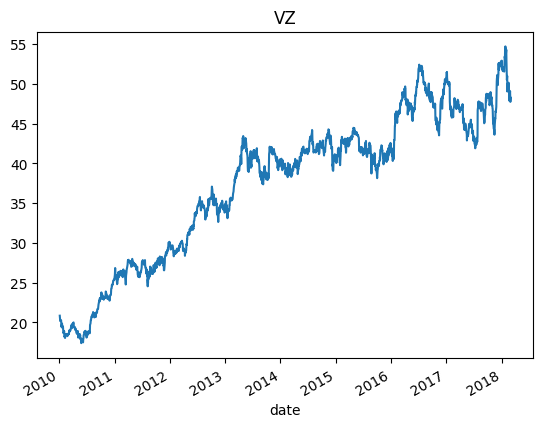

VZ
(2055,)
Epoch 1/20
12/12 [==============================] - 1s 27ms/step - loss: 928.0858 - val_loss: 1609.3158
Epoch 2/20
12/12 [==============================] - 0s 8ms/step - loss: 673.2198 - val_loss: 1393.4116
Epoch 3/20
12/12 [==============================] - 0s 9ms/step - loss: 551.5435 - val_loss: 1216.8873
Epoch 4/20
12/12 [==============================] - 0s 9ms/step - loss: 451.3840 - val_loss: 1058.5807
Epoch 5/20
12/12 [==============================] - 0s 9ms/step - loss: 365.1914 - val_loss: 914.7343
Epoch 6/20
12/12 [==============================] - 0s 9ms/step - loss: 291.6689 - val_loss: 784.8777
Epoch 7/20
12/12 [==============================] - 0s 9ms/step - loss: 229.5490 - val_loss: 666.9214
Epoch 8/20
12/12 [==============================] - 0s 9ms/step - loss: 178.0819 - val_loss: 560.0113
Epoch 9/20
12/12 [==============================] - 0s 9ms/step - loss: 136.8718 - val_loss: 465.4814
Epoch 10/20
12/12 [==============================] - 0s 10ms/step 

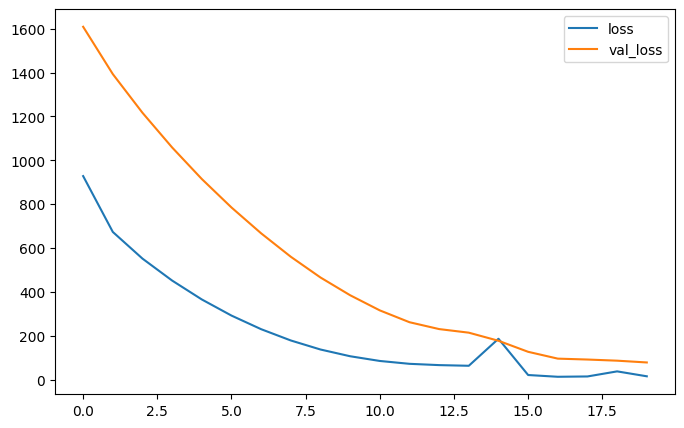

##################################################


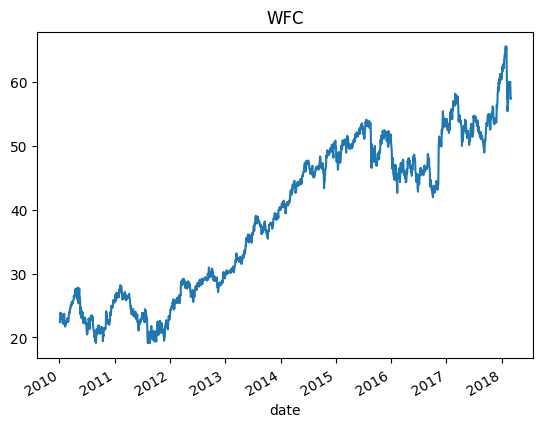

WFC
(2055,)
Epoch 1/20
12/12 [==============================] - 1s 29ms/step - loss: 1016.5370 - val_loss: 1593.8998
Epoch 2/20
12/12 [==============================] - 0s 10ms/step - loss: 751.0417 - val_loss: 1381.0024
Epoch 3/20
12/12 [==============================] - 0s 10ms/step - loss: 627.3748 - val_loss: 1206.7952
Epoch 4/20
12/12 [==============================] - 0s 9ms/step - loss: 525.1331 - val_loss: 1050.3307
Epoch 5/20
12/12 [==============================] - 0s 8ms/step - loss: 436.7227 - val_loss: 907.4850
Epoch 6/20
12/12 [==============================] - 0s 10ms/step - loss: 360.7970 - val_loss: 778.4958
Epoch 7/20
12/12 [==============================] - 0s 10ms/step - loss: 296.1485 - val_loss: 660.8046
Epoch 8/20
12/12 [==============================] - 0s 9ms/step - loss: 242.4544 - val_loss: 555.3901
Epoch 9/20
12/12 [==============================] - 0s 9ms/step - loss: 199.2723 - val_loss: 462.7572
Epoch 10/20
12/12 [==============================] - 0s 8ms/

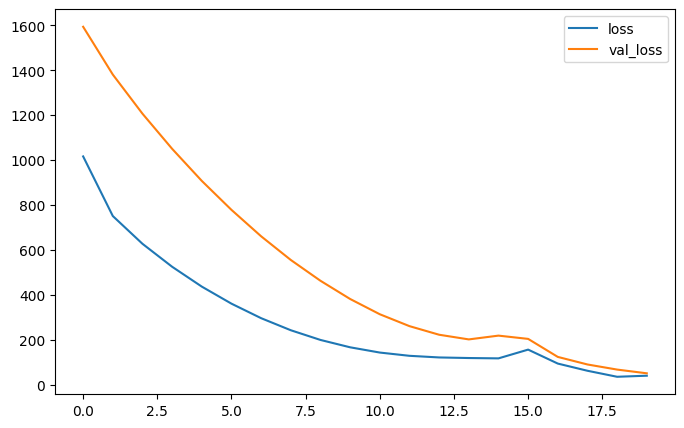

##################################################


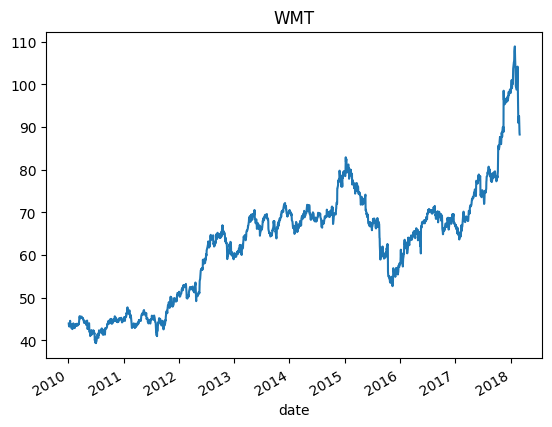

WMT
(2055,)
Epoch 1/20
12/12 [==============================] - 1s 26ms/step - loss: 3073.4973 - val_loss: 3568.9873
Epoch 2/20
12/12 [==============================] - 0s 8ms/step - loss: 2583.4746 - val_loss: 3217.3721
Epoch 3/20
12/12 [==============================] - 0s 8ms/step - loss: 2318.4578 - val_loss: 2934.1116
Epoch 4/20
12/12 [==============================] - 0s 8ms/step - loss: 2089.9631 - val_loss: 2673.6074
Epoch 5/20
12/12 [==============================] - 0s 8ms/step - loss: 1879.3837 - val_loss: 2427.9807
Epoch 6/20
12/12 [==============================] - 0s 8ms/step - loss: 1682.8243 - val_loss: 2197.0991
Epoch 7/20
12/12 [==============================] - 0s 8ms/step - loss: 1499.1567 - val_loss: 1978.0239
Epoch 8/20
12/12 [==============================] - 0s 9ms/step - loss: 1327.4680 - val_loss: 1771.0077
Epoch 9/20
12/12 [==============================] - 0s 8ms/step - loss: 1167.8113 - val_loss: 1576.6112
Epoch 10/20
12/12 [==============================] 

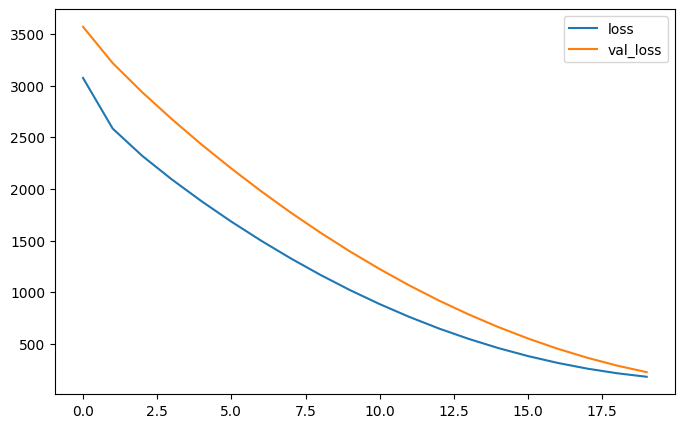

##################################################


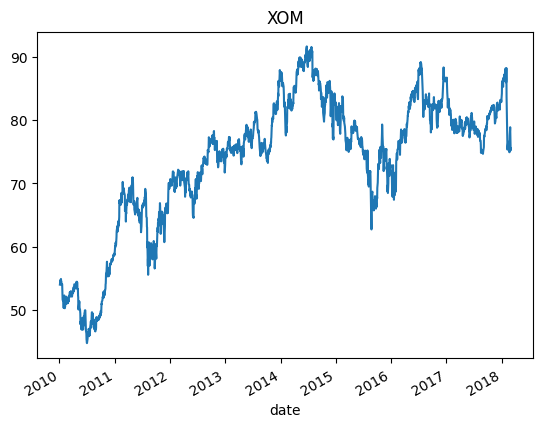

XOM
(2055,)
Epoch 1/20
12/12 [==============================] - 2s 27ms/step - loss: 4469.4922 - val_loss: 5483.1470
Epoch 2/20
12/12 [==============================] - 0s 9ms/step - loss: 3875.1609 - val_loss: 5063.2246
Epoch 3/20
12/12 [==============================] - 0s 8ms/step - loss: 3550.9944 - val_loss: 4705.5464
Epoch 4/20
12/12 [==============================] - 0s 8ms/step - loss: 3263.0854 - val_loss: 4373.2583
Epoch 5/20
12/12 [==============================] - 0s 8ms/step - loss: 2993.7485 - val_loss: 4055.9316
Epoch 6/20
12/12 [==============================] - 0s 8ms/step - loss: 2738.1184 - val_loss: 3752.2603
Epoch 7/20
12/12 [==============================] - 0s 9ms/step - loss: 2495.0767 - val_loss: 3460.5425
Epoch 8/20
12/12 [==============================] - 0s 8ms/step - loss: 2264.1482 - val_loss: 3181.5881
Epoch 9/20
12/12 [==============================] - 0s 9ms/step - loss: 2046.2408 - val_loss: 2915.6250
Epoch 10/20
12/12 [==============================] 

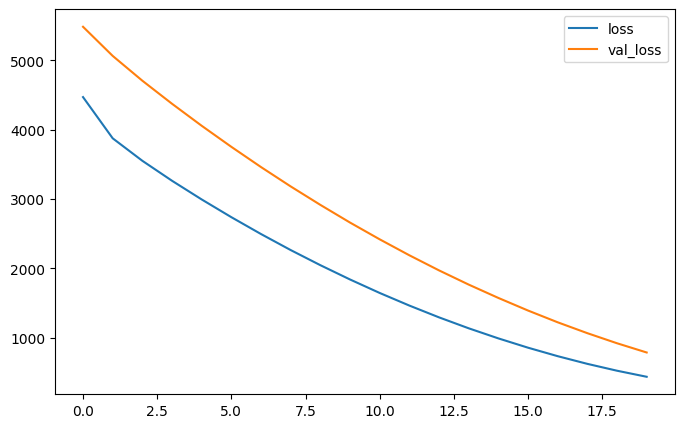

##################################################


In [36]:
model = two_layered_rnn()
training_loop(model)

## Alternative to standard RNNs 

RNNs suffer from exploding or vanishing gradients. RNNs can have a hard time to learn long term dependencies.

**Solutions**:
* Exploding gradients can be addressed by gradient clipping
* Vanishing gradients can be addressed by gater recurrent units



**Examples of gated recurrent units**:
* Long Short Term Memory Networks (LSTM)

<img src="images/lstm.jpg" width="600">

* Gated Recurrent Unit (GRU)

<img src="images/gru.png" width="650">

In [37]:
def two_layered_lstm(units=20, input_shape=1, output_shape=1, learning_rate=0.01):
    model = tf.keras.models.Sequential()
    
    model.add(tf.keras.layers.LSTM(
        units,
        return_sequences=True,
        input_shape=[None, input_shape])
             )
    
    model.add(tf.keras.layers.LSTM(units))
    model.add(tf.keras.layers.Dense(output_shape))
    model.compile(
        optimizer=tf.keras.optimizers.RMSprop(learning_rate),
        loss=tf.keras.losses.Huber(),
        metrics=['mae', 'mse'])
    
    return model

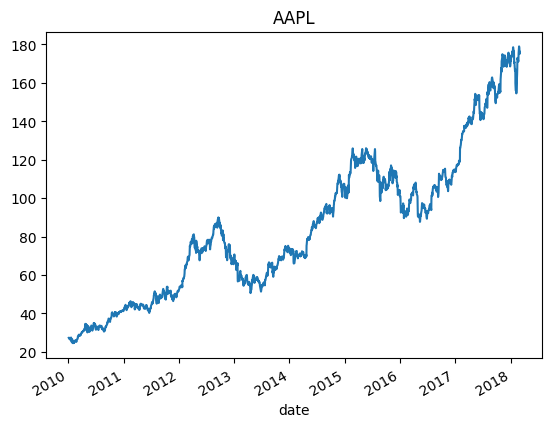

AAPL
(2055,)
Epoch 1/20
12/12 [==============================] - 1s 27ms/step - loss: 5209.2285 - val_loss: 9945.3652
Epoch 2/20
12/12 [==============================] - 0s 9ms/step - loss: 4579.4268 - val_loss: 9375.1348
Epoch 3/20
12/12 [==============================] - 0s 9ms/step - loss: 4221.3354 - val_loss: 8876.7236
Epoch 4/20
12/12 [==============================] - 0s 8ms/step - loss: 3924.6069 - val_loss: 8398.9688
Epoch 5/20
12/12 [==============================] - 0s 8ms/step - loss: 3647.7280 - val_loss: 7953.6025
Epoch 6/20
12/12 [==============================] - 0s 8ms/step - loss: 3387.9485 - val_loss: 7525.4536
Epoch 7/20
12/12 [==============================] - 0s 9ms/step - loss: 3143.3074 - val_loss: 7114.2554
Epoch 8/20
12/12 [==============================] - 0s 8ms/step - loss: 2910.5352 - val_loss: 6711.9438
Epoch 9/20
12/12 [==============================] - 0s 8ms/step - loss: 2690.2068 - val_loss: 6327.2554
Epoch 10/20
12/12 [==============================]

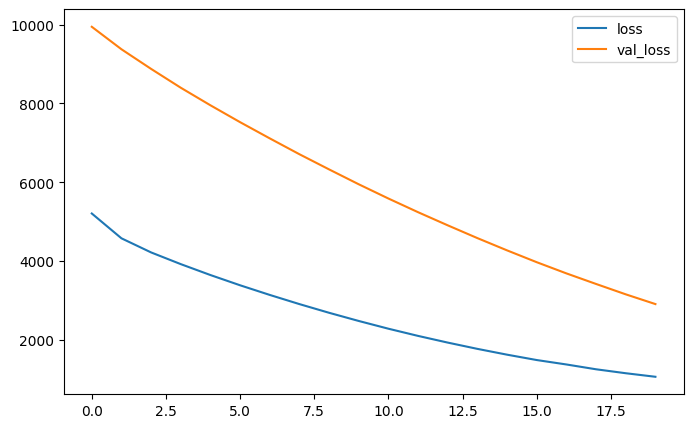

##################################################


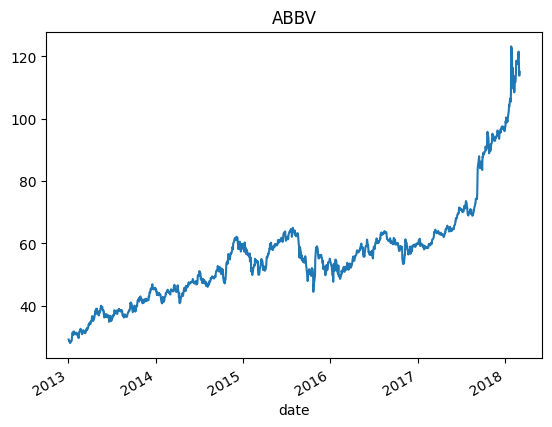

ABBV
(2055,)
Epoch 1/20
8/8 [==============================] - 1s 41ms/step - loss: 2153.4565 - val_loss: 3085.5183
Epoch 2/20
8/8 [==============================] - 0s 10ms/step - loss: 1786.3718 - val_loss: 2849.0283
Epoch 3/20
8/8 [==============================] - 0s 9ms/step - loss: 1624.2346 - val_loss: 2658.8809
Epoch 4/20
8/8 [==============================] - 0s 10ms/step - loss: 1489.3762 - val_loss: 2488.3694
Epoch 5/20
8/8 [==============================] - 0s 10ms/step - loss: 1367.2527 - val_loss: 2328.9873
Epoch 6/20
8/8 [==============================] - 0s 10ms/step - loss: 1253.3972 - val_loss: 2176.5906
Epoch 7/20
8/8 [==============================] - 0s 9ms/step - loss: 1145.8292 - val_loss: 2029.7556
Epoch 8/20
8/8 [==============================] - 0s 10ms/step - loss: 1043.6382 - val_loss: 1889.3542
Epoch 9/20
8/8 [==============================] - 0s 9ms/step - loss: 947.4706 - val_loss: 1754.7843
Epoch 10/20
8/8 [==============================] - 0s 9ms/step -

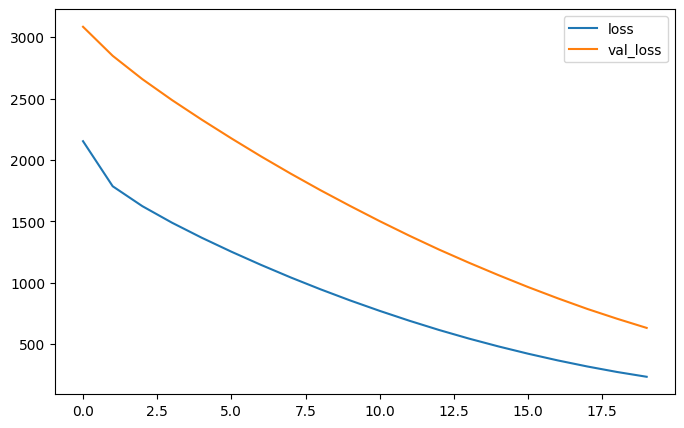

##################################################


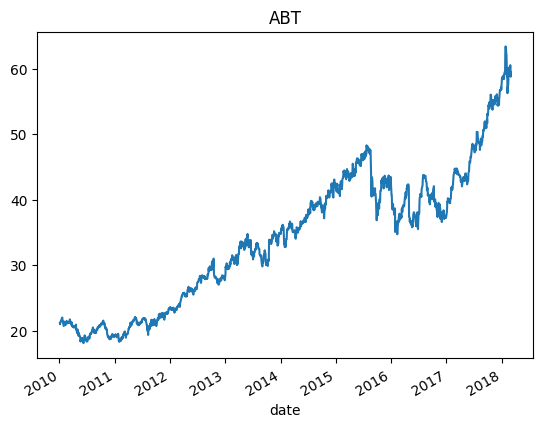

ABT
(2055,)
Epoch 1/20
12/12 [==============================] - 1s 26ms/step - loss: 709.4590 - val_loss: 1002.2255
Epoch 2/20
12/12 [==============================] - 0s 8ms/step - loss: 520.2562 - val_loss: 827.6279
Epoch 3/20
12/12 [==============================] - 0s 8ms/step - loss: 417.9570 - val_loss: 695.2579
Epoch 4/20
12/12 [==============================] - 0s 8ms/step - loss: 336.5749 - val_loss: 579.7214
Epoch 5/20
12/12 [==============================] - 0s 8ms/step - loss: 268.5217 - val_loss: 477.1598
Epoch 6/20
12/12 [==============================] - 0s 9ms/step - loss: 211.6527 - val_loss: 386.3322
Epoch 7/20
12/12 [==============================] - 0s 8ms/step - loss: 166.1443 - val_loss: 308.4221
Epoch 8/20
12/12 [==============================] - 0s 8ms/step - loss: 131.2557 - val_loss: 242.2489
Epoch 9/20
12/12 [==============================] - 0s 11ms/step - loss: 105.9164 - val_loss: 186.5304
Epoch 10/20
12/12 [==============================] - 0s 10ms/step -

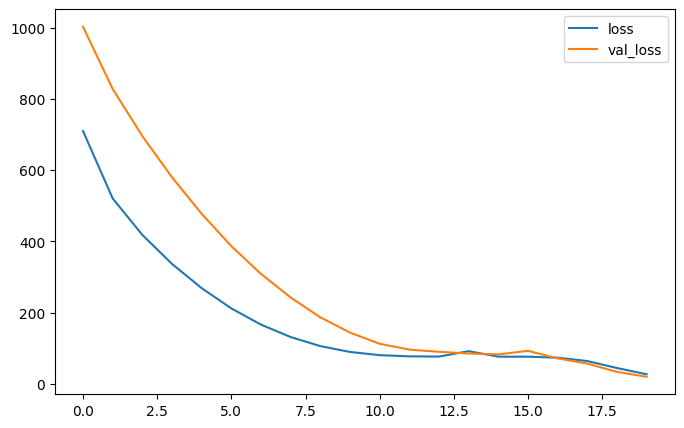

##################################################


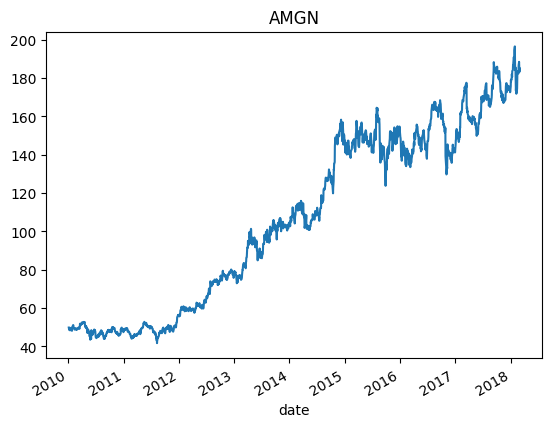

AMGN
(2055,)
Epoch 1/20
12/12 [==============================] - 2s 27ms/step - loss: 8579.1455 - val_loss: 20734.2109
Epoch 2/20
12/12 [==============================] - 0s 8ms/step - loss: 7771.2197 - val_loss: 19902.2656
Epoch 3/20
12/12 [==============================] - 0s 8ms/step - loss: 7347.0542 - val_loss: 19187.5723
Epoch 4/20
12/12 [==============================] - 0s 8ms/step - loss: 6965.8418 - val_loss: 18503.5840
Epoch 5/20
12/12 [==============================] - 0s 9ms/step - loss: 6604.1714 - val_loss: 17840.2461
Epoch 6/20
12/12 [==============================] - 0s 8ms/step - loss: 6257.4624 - val_loss: 17192.2559
Epoch 7/20
12/12 [==============================] - 0s 11ms/step - loss: 5924.2593 - val_loss: 16558.6914
Epoch 8/20
12/12 [==============================] - 0s 10ms/step - loss: 5603.4297 - val_loss: 15935.4033
Epoch 9/20
12/12 [==============================] - 0s 9ms/step - loss: 5294.3804 - val_loss: 15326.1963
Epoch 10/20
12/12 [====================

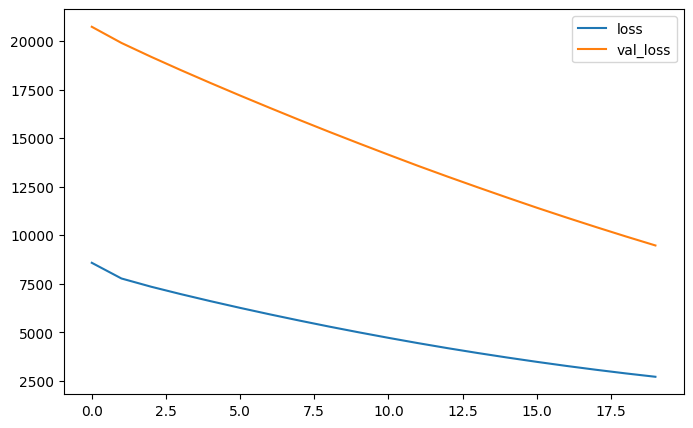

##################################################


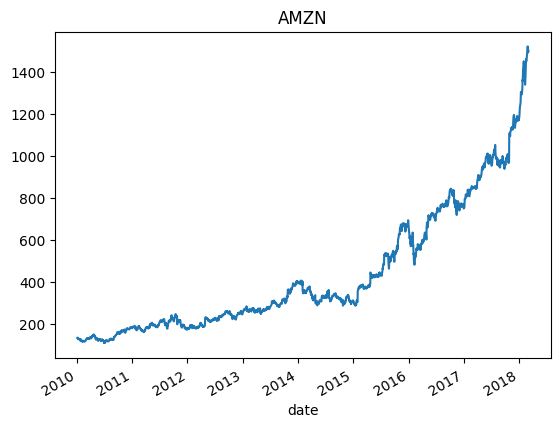

AMZN
(2055,)
Epoch 1/20
12/12 [==============================] - 2s 40ms/step - loss: 97285.0547 - val_loss: 563914.8125
Epoch 2/20
12/12 [==============================] - 0s 12ms/step - loss: 94204.8125 - val_loss: 559163.5000
Epoch 3/20
12/12 [==============================] - 0s 13ms/step - loss: 92556.2969 - val_loss: 555111.0000
Epoch 4/20
12/12 [==============================] - 0s 12ms/step - loss: 91109.4219 - val_loss: 551318.4375
Epoch 5/20
12/12 [==============================] - 0s 12ms/step - loss: 89721.2266 - val_loss: 547578.1250
Epoch 6/20
12/12 [==============================] - 0s 11ms/step - loss: 88358.7344 - val_loss: 543869.5625
Epoch 7/20
12/12 [==============================] - 0s 9ms/step - loss: 87012.1016 - val_loss: 540186.4375
Epoch 8/20
12/12 [==============================] - 0s 9ms/step - loss: 85684.3281 - val_loss: 536529.5625
Epoch 9/20
12/12 [==============================] - 0s 9ms/step - loss: 84368.1328 - val_loss: 532878.1875
Epoch 10/20
12/12 

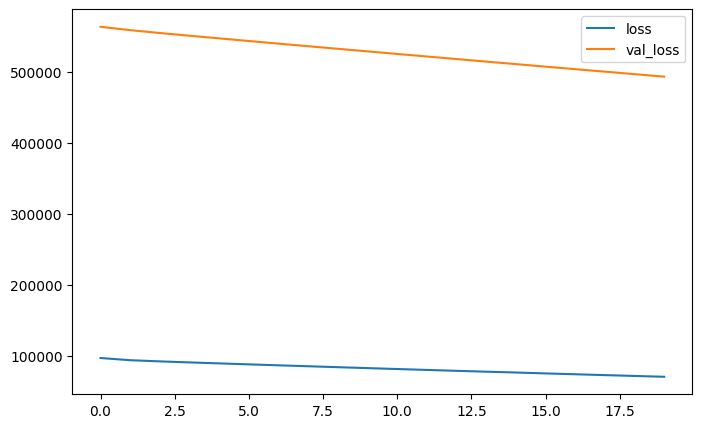

##################################################


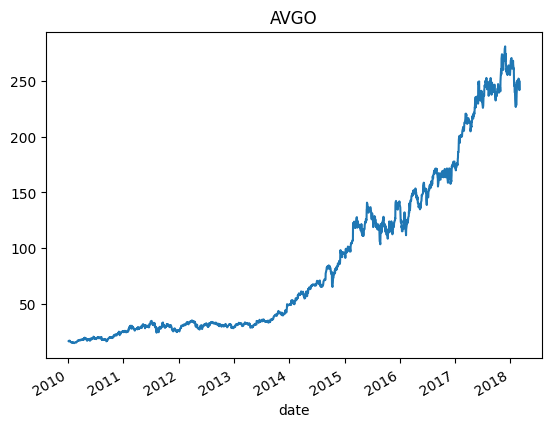

AVGO
(2055,)
Epoch 1/20
12/12 [==============================] - 1s 26ms/step - loss: 3545.4719 - val_loss: 24187.9785
Epoch 2/20
12/12 [==============================] - 0s 8ms/step - loss: 3116.4858 - val_loss: 23319.5371
Epoch 3/20
12/12 [==============================] - 0s 8ms/step - loss: 2900.6536 - val_loss: 22566.9336
Epoch 4/20
12/12 [==============================] - 0s 8ms/step - loss: 2712.1531 - val_loss: 21850.2305
Epoch 5/20
12/12 [==============================] - 0s 8ms/step - loss: 2539.4839 - val_loss: 21154.6504
Epoch 6/20
12/12 [==============================] - 0s 9ms/step - loss: 2378.7551 - val_loss: 20469.7031
Epoch 7/20
12/12 [==============================] - 0s 9ms/step - loss: 2231.3733 - val_loss: 19810.6680
Epoch 8/20
12/12 [==============================] - 0s 8ms/step - loss: 2095.2339 - val_loss: 19153.3750
Epoch 9/20
12/12 [==============================] - 0s 8ms/step - loss: 1970.0511 - val_loss: 18510.4531
Epoch 10/20
12/12 [======================

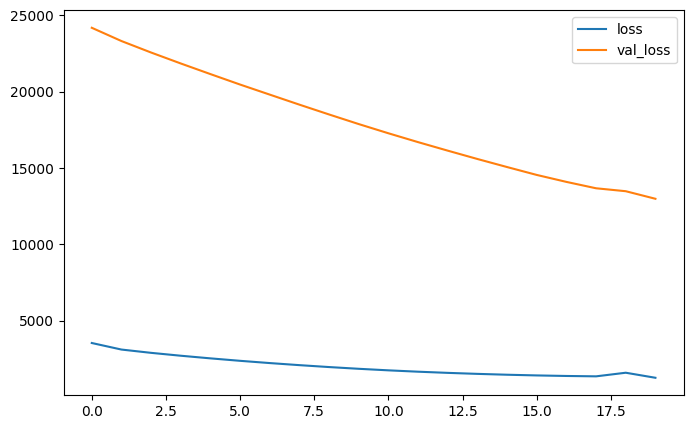

##################################################


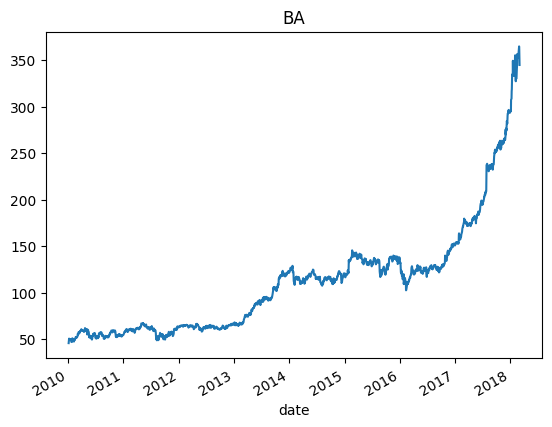

BA
(2055,)
Epoch 1/20
12/12 [==============================] - 1s 28ms/step - loss: 7801.0020 - val_loss: 16328.5000
Epoch 2/20
12/12 [==============================] - 0s 9ms/step - loss: 7097.3916 - val_loss: 15603.9688
Epoch 3/20
12/12 [==============================] - 0s 8ms/step - loss: 6680.6514 - val_loss: 14973.7529
Epoch 4/20
12/12 [==============================] - 0s 8ms/step - loss: 6304.5254 - val_loss: 14372.2520
Epoch 5/20
12/12 [==============================] - 0s 8ms/step - loss: 5947.8433 - val_loss: 13792.4277
Epoch 6/20
12/12 [==============================] - 0s 8ms/step - loss: 5606.5415 - val_loss: 13226.8682
Epoch 7/20
12/12 [==============================] - 0s 9ms/step - loss: 5278.4438 - val_loss: 12673.7314
Epoch 8/20
12/12 [==============================] - 0s 9ms/step - loss: 4963.1201 - val_loss: 12133.4736
Epoch 9/20
12/12 [==============================] - 0s 9ms/step - loss: 4658.4370 - val_loss: 11603.6982
Epoch 10/20
12/12 [========================

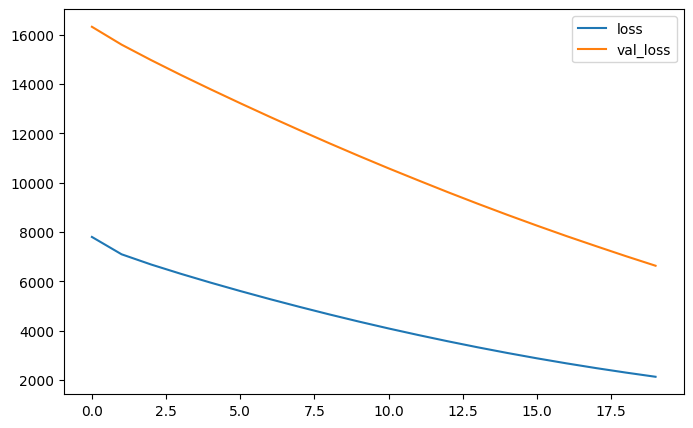

##################################################


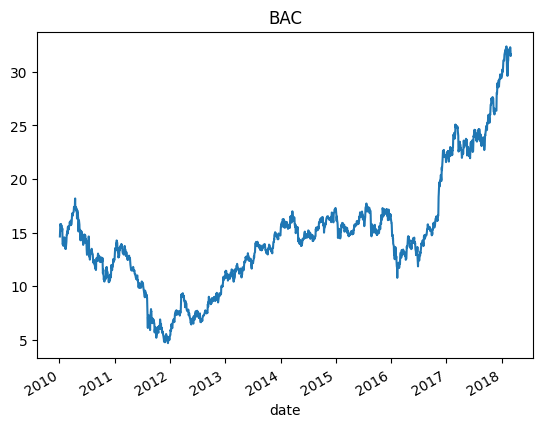

BAC
(2055,)
Epoch 1/20
12/12 [==============================] - 1s 26ms/step - loss: 70.0180 - val_loss: 88.7017
Epoch 2/20
12/12 [==============================] - 0s 9ms/step - loss: 23.6933 - val_loss: 57.2957
Epoch 3/20
12/12 [==============================] - 0s 9ms/step - loss: 14.5641 - val_loss: 40.0960
Epoch 4/20
12/12 [==============================] - 0s 8ms/step - loss: 11.3238 - val_loss: 30.4738
Epoch 5/20
12/12 [==============================] - 0s 9ms/step - loss: 8.1605 - val_loss: 25.3211
Epoch 6/20
12/12 [==============================] - 0s 8ms/step - loss: 3.7058 - val_loss: 18.0586
Epoch 7/20
12/12 [==============================] - 0s 9ms/step - loss: 9.5100 - val_loss: 23.7716
Epoch 8/20
12/12 [==============================] - 0s 8ms/step - loss: 5.7736 - val_loss: 19.8074
Epoch 9/20
12/12 [==============================] - 0s 8ms/step - loss: 3.0438 - val_loss: 16.1731
Epoch 10/20
12/12 [==============================] - 0s 8ms/step - loss: 2.4396 - val_loss: 

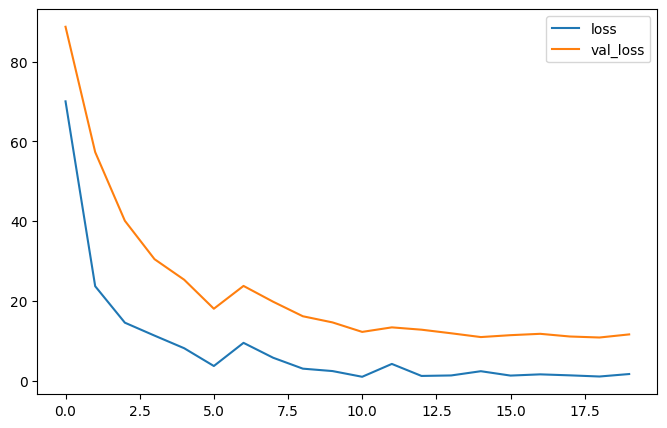

##################################################


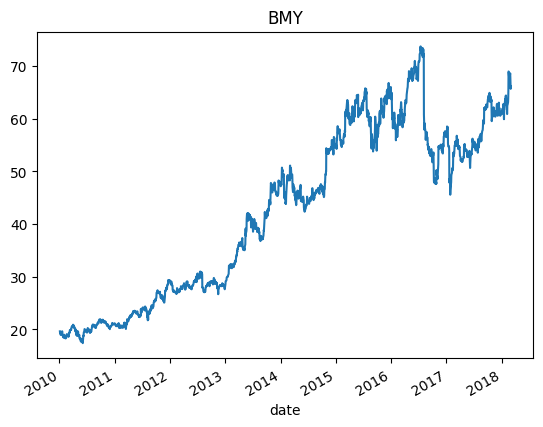

BMY
(2055,)
Epoch 1/20
12/12 [==============================] - 2s 26ms/step - loss: 1330.6844 - val_loss: 2649.2593
Epoch 2/20
12/12 [==============================] - 0s 8ms/step - loss: 935.6251 - val_loss: 2294.2151
Epoch 3/20
12/12 [==============================] - 0s 8ms/step - loss: 791.0443 - val_loss: 2060.6982
Epoch 4/20
12/12 [==============================] - 0s 9ms/step - loss: 678.6077 - val_loss: 1852.1797
Epoch 5/20
12/12 [==============================] - 0s 8ms/step - loss: 582.3755 - val_loss: 1660.6345
Epoch 6/20
12/12 [==============================] - 0s 8ms/step - loss: 499.4837 - val_loss: 1485.2931
Epoch 7/20
12/12 [==============================] - 0s 8ms/step - loss: 428.2160 - val_loss: 1320.1620
Epoch 8/20
12/12 [==============================] - 0s 8ms/step - loss: 368.2783 - val_loss: 1170.8204
Epoch 9/20
12/12 [==============================] - 0s 8ms/step - loss: 320.4168 - val_loss: 1031.7887
Epoch 10/20
12/12 [==============================] - 0s 8ms

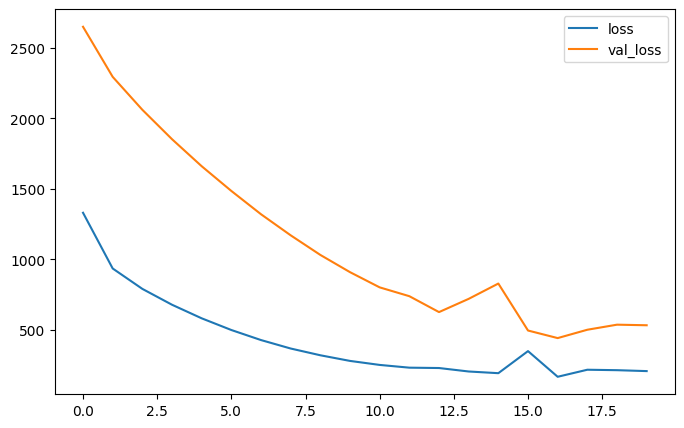

##################################################


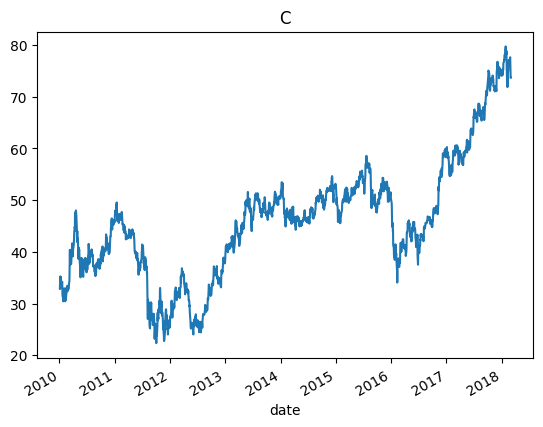

C
(2055,)
Epoch 1/20
12/12 [==============================] - 1s 26ms/step - loss: 1350.4701 - val_loss: 1547.9720
Epoch 2/20
12/12 [==============================] - 0s 8ms/step - loss: 1063.3221 - val_loss: 1345.0604
Epoch 3/20
12/12 [==============================] - 0s 9ms/step - loss: 908.3171 - val_loss: 1173.5638
Epoch 4/20
12/12 [==============================] - 0s 9ms/step - loss: 774.2847 - val_loss: 1018.6114
Epoch 5/20
12/12 [==============================] - 0s 9ms/step - loss: 654.2113 - val_loss: 876.5318
Epoch 6/20
12/12 [==============================] - 0s 9ms/step - loss: 547.0200 - val_loss: 747.8989
Epoch 7/20
12/12 [==============================] - 0s 9ms/step - loss: 451.5228 - val_loss: 630.0236
Epoch 8/20
12/12 [==============================] - 0s 9ms/step - loss: 367.4006 - val_loss: 524.5760
Epoch 9/20
12/12 [==============================] - 0s 9ms/step - loss: 294.9024 - val_loss: 430.8023
Epoch 10/20
12/12 [==============================] - 0s 9ms/step 

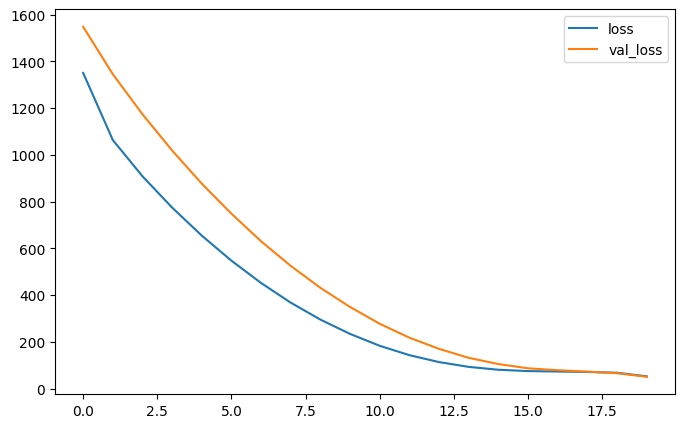

##################################################


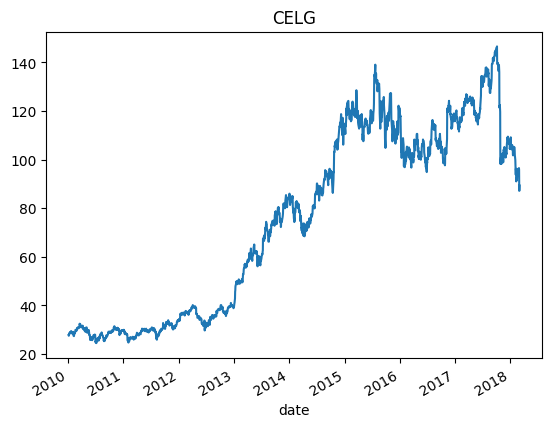

CELG
(2055,)
Epoch 1/20
12/12 [==============================] - 1s 25ms/step - loss: 4541.8057 - val_loss: 10365.5156
Epoch 2/20
12/12 [==============================] - 0s 8ms/step - loss: 4081.6287 - val_loss: 9800.0703
Epoch 3/20
12/12 [==============================] - 0s 8ms/step - loss: 3802.6770 - val_loss: 9306.5049
Epoch 4/20
12/12 [==============================] - 0s 9ms/step - loss: 3554.9771 - val_loss: 8843.7969
Epoch 5/20
12/12 [==============================] - 0s 9ms/step - loss: 3324.1501 - val_loss: 8393.8604
Epoch 6/20
12/12 [==============================] - 0s 8ms/step - loss: 3104.6667 - val_loss: 7954.6533
Epoch 7/20
12/12 [==============================] - 0s 8ms/step - loss: 2898.5496 - val_loss: 7533.1650
Epoch 8/20
12/12 [==============================] - 0s 8ms/step - loss: 2705.1680 - val_loss: 7123.2656
Epoch 9/20
12/12 [==============================] - 0s 9ms/step - loss: 2525.3718 - val_loss: 6730.0522
Epoch 10/20
12/12 [==============================

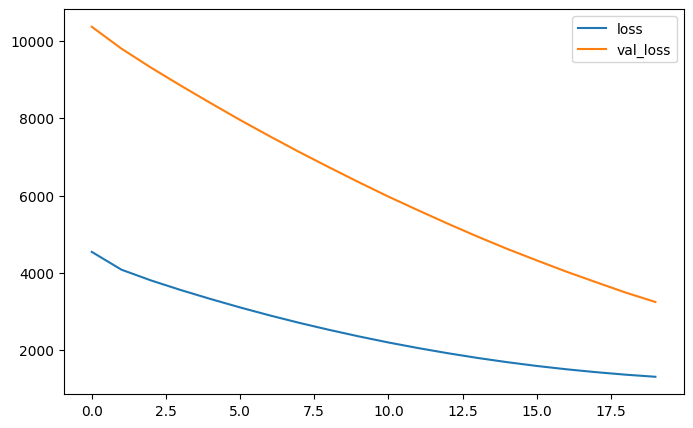

##################################################


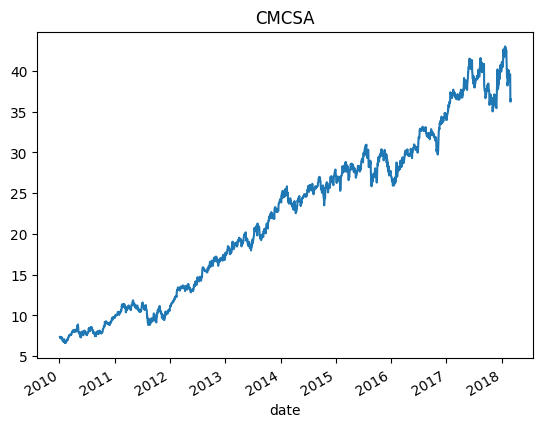

CMCSA
(2055,)
Epoch 1/20
12/12 [==============================] - 1s 32ms/step - loss: 241.7669 - val_loss: 620.5439
Epoch 2/20
12/12 [==============================] - 0s 10ms/step - loss: 141.0507 - val_loss: 500.8878
Epoch 3/20
12/12 [==============================] - 0s 12ms/step - loss: 103.7421 - val_loss: 411.4082
Epoch 4/20
12/12 [==============================] - 0s 11ms/step - loss: 79.6368 - val_loss: 336.5818
Epoch 5/20
12/12 [==============================] - 0s 10ms/step - loss: 65.1661 - val_loss: 281.2346
Epoch 6/20
12/12 [==============================] - 0s 11ms/step - loss: 58.1114 - val_loss: 239.9662
Epoch 7/20
12/12 [==============================] - 0s 10ms/step - loss: 55.6890 - val_loss: 221.7819
Epoch 8/20
12/12 [==============================] - 0s 11ms/step - loss: 57.6515 - val_loss: 241.4389
Epoch 9/20
12/12 [==============================] - 0s 11ms/step - loss: 41.8532 - val_loss: 148.6969
Epoch 10/20
12/12 [==============================] - 0s 9ms/step 

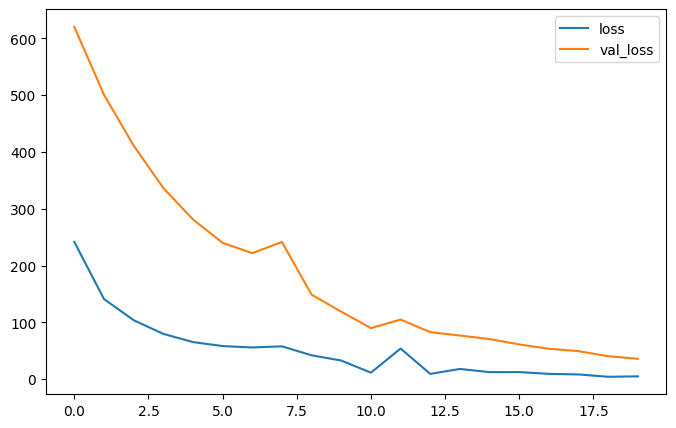

##################################################


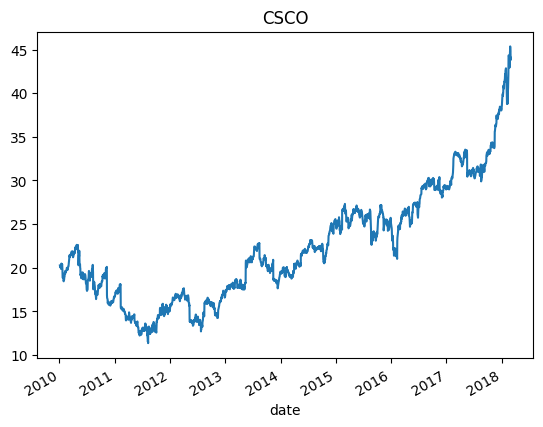

CSCO
(2055,)
Epoch 1/20
12/12 [==============================] - 1s 26ms/step - loss: 222.7108 - val_loss: 438.4899
Epoch 2/20
12/12 [==============================] - 0s 8ms/step - loss: 124.8939 - val_loss: 338.6515
Epoch 3/20
12/12 [==============================] - 0s 9ms/step - loss: 81.5086 - val_loss: 263.6740
Epoch 4/20
12/12 [==============================] - 0s 9ms/step - loss: 52.1917 - val_loss: 203.6063
Epoch 5/20
12/12 [==============================] - 0s 9ms/step - loss: 32.9404 - val_loss: 155.6889
Epoch 6/20
12/12 [==============================] - 0s 8ms/step - loss: 21.9804 - val_loss: 120.6040
Epoch 7/20
12/12 [==============================] - 0s 8ms/step - loss: 17.3125 - val_loss: 98.4682
Epoch 8/20
12/12 [==============================] - 0s 8ms/step - loss: 16.1683 - val_loss: 87.6131
Epoch 9/20
12/12 [==============================] - 0s 9ms/step - loss: 16.1229 - val_loss: 87.4033
Epoch 10/20
12/12 [==============================] - 0s 8ms/step - loss: 16.11

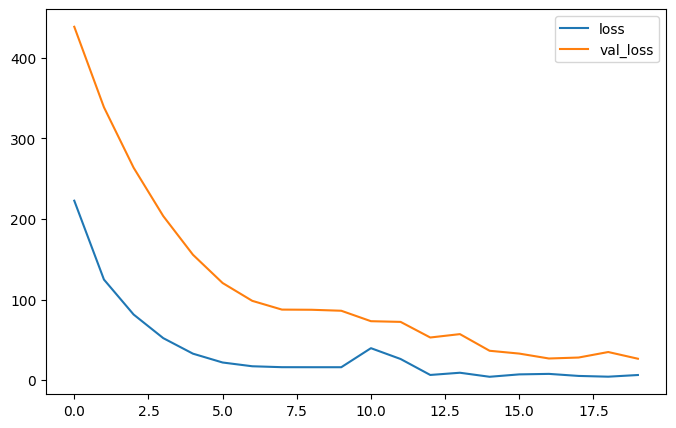

##################################################


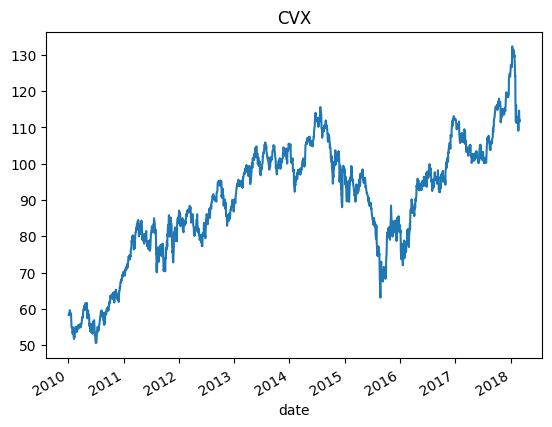

CVX
(2055,)
Epoch 1/20
12/12 [==============================] - 1s 26ms/step - loss: 6695.2402 - val_loss: 8277.9629
Epoch 2/20
12/12 [==============================] - 0s 8ms/step - loss: 5987.0371 - val_loss: 7749.7935
Epoch 3/20
12/12 [==============================] - 0s 8ms/step - loss: 5578.9473 - val_loss: 7304.8247
Epoch 4/20
12/12 [==============================] - 0s 8ms/step - loss: 5215.8081 - val_loss: 6887.0649
Epoch 5/20
12/12 [==============================] - 0s 9ms/step - loss: 4872.4224 - val_loss: 6485.6167
Epoch 6/20
12/12 [==============================] - 0s 9ms/step - loss: 4543.5747 - val_loss: 6097.7896
Epoch 7/20
12/12 [==============================] - 0s 9ms/step - loss: 4227.3389 - val_loss: 5723.0708
Epoch 8/20
12/12 [==============================] - 0s 9ms/step - loss: 3923.8435 - val_loss: 5360.0488
Epoch 9/20
12/12 [==============================] - 0s 9ms/step - loss: 3632.8457 - val_loss: 5010.8110
Epoch 10/20
12/12 [==============================] 

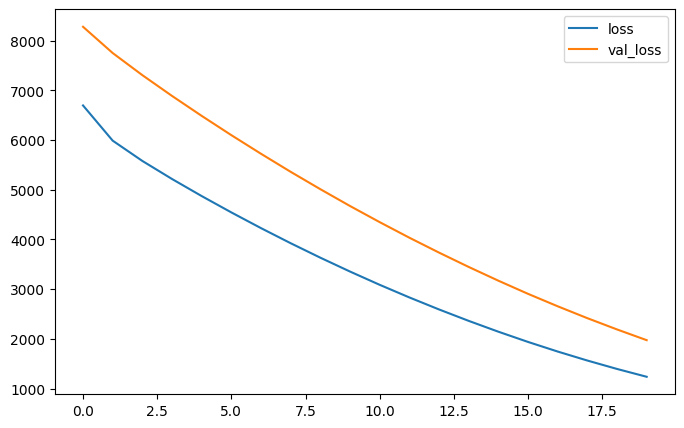

##################################################


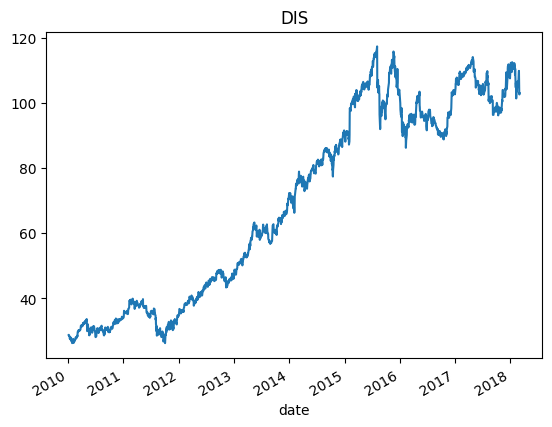

DIS
(2055,)
Epoch 1/20
12/12 [==============================] - 1s 26ms/step - loss: 3733.4160 - val_loss: 7976.4395
Epoch 2/20
12/12 [==============================] - 0s 8ms/step - loss: 3241.0789 - val_loss: 7473.7124
Epoch 3/20
12/12 [==============================] - 0s 9ms/step - loss: 2978.9534 - val_loss: 7041.0034
Epoch 4/20
12/12 [==============================] - 0s 8ms/step - loss: 2748.2402 - val_loss: 6639.0947
Epoch 5/20
12/12 [==============================] - 0s 9ms/step - loss: 2535.1851 - val_loss: 6252.0952
Epoch 6/20
12/12 [==============================] - 0s 8ms/step - loss: 2334.5959 - val_loss: 5876.8506
Epoch 7/20
12/12 [==============================] - 0s 8ms/step - loss: 2146.0740 - val_loss: 5514.4209
Epoch 8/20
12/12 [==============================] - 0s 8ms/step - loss: 1969.5996 - val_loss: 5165.3843
Epoch 9/20
12/12 [==============================] - 0s 9ms/step - loss: 1806.5043 - val_loss: 4832.1797
Epoch 10/20
12/12 [==============================] 

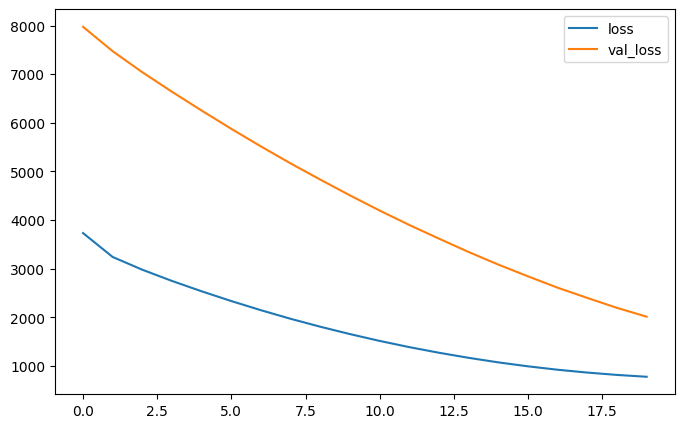

##################################################


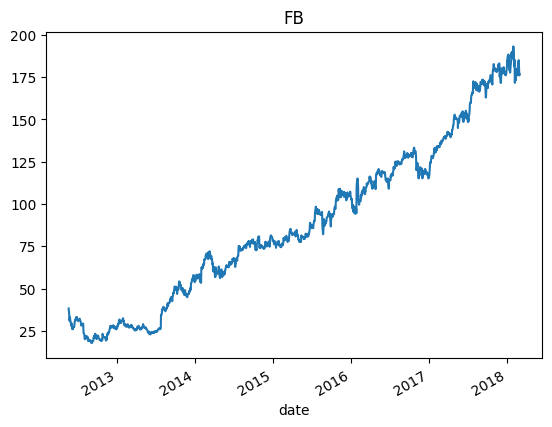

FB
(2055,)
Epoch 1/20
9/9 [==============================] - 1s 33ms/step - loss: 5075.8643 - val_loss: 16270.1279
Epoch 2/20
9/9 [==============================] - 0s 9ms/step - loss: 4613.8774 - val_loss: 15693.3223
Epoch 3/20
9/9 [==============================] - 0s 10ms/step - loss: 4364.0659 - val_loss: 15202.6465
Epoch 4/20
9/9 [==============================] - 0s 9ms/step - loss: 4144.2832 - val_loss: 14744.2354
Epoch 5/20
9/9 [==============================] - 0s 9ms/step - loss: 3939.6956 - val_loss: 14298.3369
Epoch 6/20
9/9 [==============================] - 0s 9ms/step - loss: 3743.6624 - val_loss: 13869.1875
Epoch 7/20
9/9 [==============================] - 0s 9ms/step - loss: 3557.8369 - val_loss: 13440.4502
Epoch 8/20
9/9 [==============================] - 0s 10ms/step - loss: 3377.0879 - val_loss: 13031.0557
Epoch 9/20
9/9 [==============================] - 0s 9ms/step - loss: 3206.2769 - val_loss: 12621.2686
Epoch 10/20
9/9 [==============================] - 0s 9ms/s

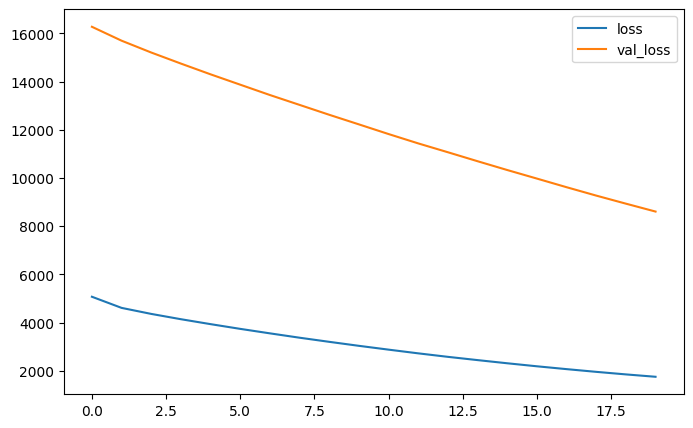

##################################################


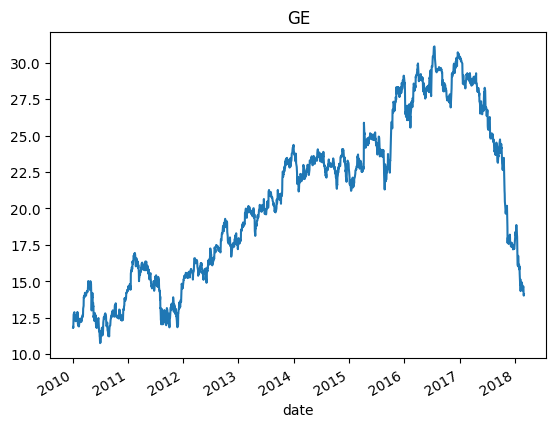

GE
(2055,)
Epoch 1/20
12/12 [==============================] - 1s 26ms/step - loss: 278.1093 - val_loss: 523.0873
Epoch 2/20
12/12 [==============================] - 0s 8ms/step - loss: 152.1244 - val_loss: 403.9019
Epoch 3/20
12/12 [==============================] - 0s 9ms/step - loss: 101.4419 - val_loss: 318.4168
Epoch 4/20
12/12 [==============================] - 0s 8ms/step - loss: 67.4469 - val_loss: 249.4732
Epoch 5/20
12/12 [==============================] - 0s 9ms/step - loss: 44.4388 - val_loss: 193.6112
Epoch 6/20
12/12 [==============================] - 0s 8ms/step - loss: 30.4651 - val_loss: 151.9075
Epoch 7/20
12/12 [==============================] - 0s 10ms/step - loss: 23.4440 - val_loss: 134.6348
Epoch 8/20
12/12 [==============================] - 0s 9ms/step - loss: 18.0317 - val_loss: 89.4071
Epoch 9/20
12/12 [==============================] - 0s 8ms/step - loss: 8.9929 - val_loss: 61.2977
Epoch 10/20
12/12 [==============================] - 0s 9ms/step - loss: 5.530

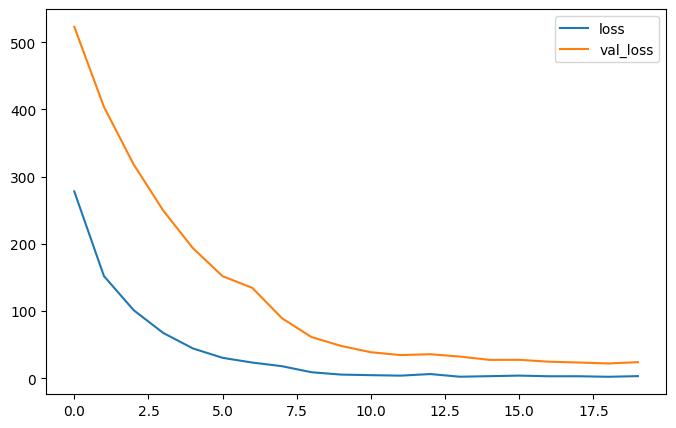

##################################################


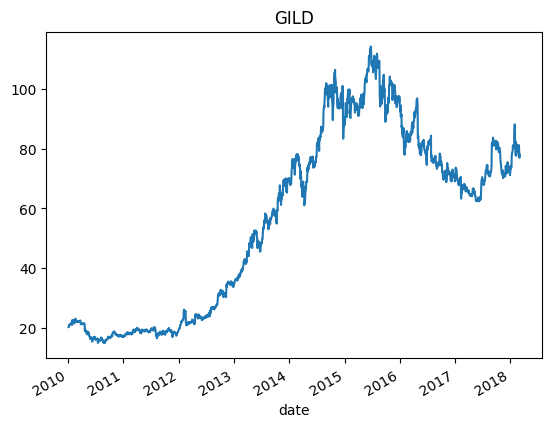

GILD
(2055,)
Epoch 1/20
12/12 [==============================] - 2s 26ms/step - loss: 3236.6294 - val_loss: 4615.3350
Epoch 2/20
12/12 [==============================] - 0s 8ms/step - loss: 2759.5156 - val_loss: 4224.1519
Epoch 3/20
12/12 [==============================] - 0s 9ms/step - loss: 2544.6570 - val_loss: 3902.5803
Epoch 4/20
12/12 [==============================] - 0s 9ms/step - loss: 2362.6472 - val_loss: 3609.0715
Epoch 5/20
12/12 [==============================] - 0s 9ms/step - loss: 2196.0178 - val_loss: 3328.7310
Epoch 6/20
12/12 [==============================] - 0s 9ms/step - loss: 2042.3651 - val_loss: 3062.8672
Epoch 7/20
12/12 [==============================] - 0s 9ms/step - loss: 1902.4891 - val_loss: 2810.9263
Epoch 8/20
12/12 [==============================] - 0s 8ms/step - loss: 1772.5638 - val_loss: 2566.8342
Epoch 9/20
12/12 [==============================] - 0s 8ms/step - loss: 1654.8041 - val_loss: 2340.0613
Epoch 10/20
12/12 [==============================]

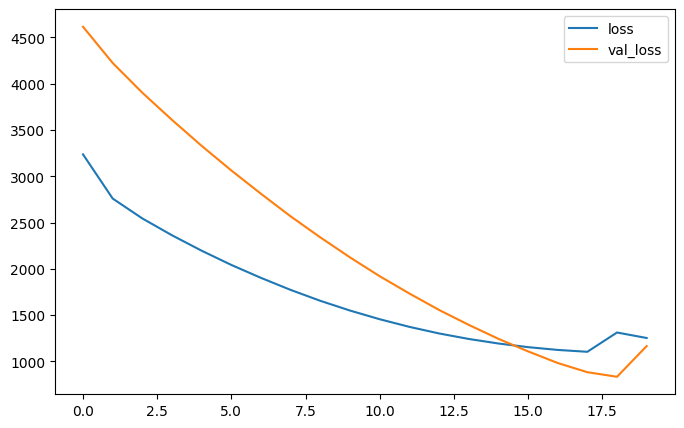

##################################################


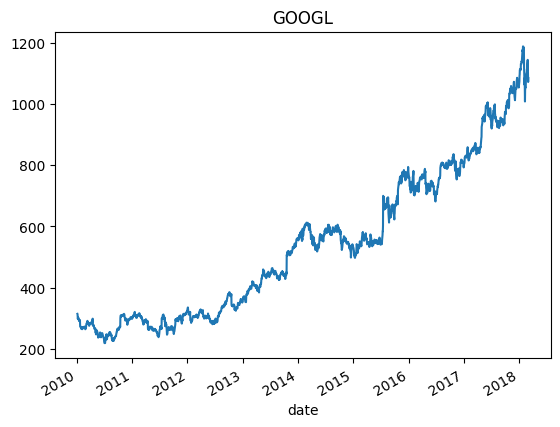

GOOGL
(2055,)
Epoch 1/20
12/12 [==============================] - 1s 27ms/step - loss: 201117.7188 - val_loss: 600688.6875
Epoch 2/20
12/12 [==============================] - 0s 9ms/step - loss: 197574.8125 - val_loss: 595703.7500
Epoch 3/20
12/12 [==============================] - 0s 8ms/step - loss: 195095.5000 - val_loss: 591612.1875
Epoch 4/20
12/12 [==============================] - 0s 8ms/step - loss: 192947.3281 - val_loss: 587711.6875
Epoch 5/20
12/12 [==============================] - 0s 9ms/step - loss: 190859.9219 - val_loss: 583844.6250
Epoch 6/20
12/12 [==============================] - 0s 8ms/step - loss: 188796.2031 - val_loss: 580009.3125
Epoch 7/20
12/12 [==============================] - 0s 8ms/step - loss: 186750.2188 - val_loss: 576197.1250
Epoch 8/20
12/12 [==============================] - 0s 8ms/step - loss: 184727.2344 - val_loss: 572407.2500
Epoch 9/20
12/12 [==============================] - 0s 8ms/step - loss: 182719.0469 - val_loss: 568640.9375
Epoch 10/20
1

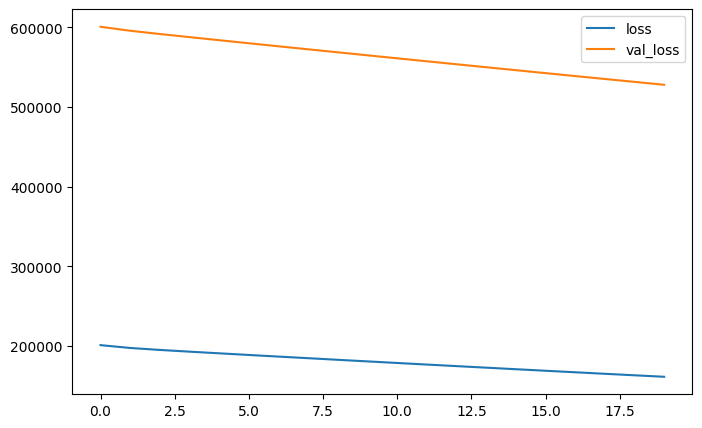

##################################################


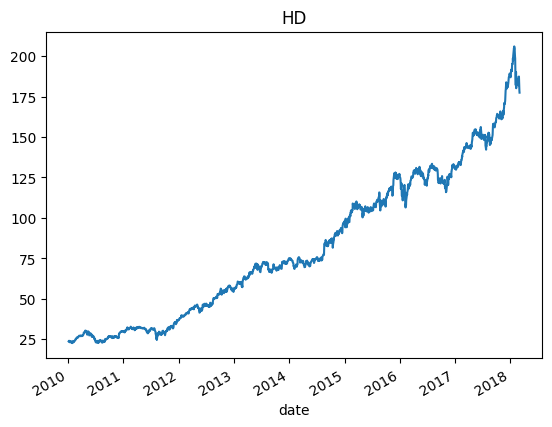

HD
(2055,)
Epoch 1/20
12/12 [==============================] - 1s 27ms/step - loss: 4124.0479 - val_loss: 14452.1367
Epoch 2/20
12/12 [==============================] - 0s 9ms/step - loss: 3702.9714 - val_loss: 13797.8721
Epoch 3/20
12/12 [==============================] - 0s 8ms/step - loss: 3432.3499 - val_loss: 13214.4102
Epoch 4/20
12/12 [==============================] - 0s 8ms/step - loss: 3188.5645 - val_loss: 12656.6006
Epoch 5/20
12/12 [==============================] - 0s 9ms/step - loss: 2961.2471 - val_loss: 12115.2578
Epoch 6/20
12/12 [==============================] - 0s 9ms/step - loss: 2747.0845 - val_loss: 11589.6055
Epoch 7/20
12/12 [==============================] - 0s 8ms/step - loss: 2546.3213 - val_loss: 11080.7998
Epoch 8/20
12/12 [==============================] - 0s 9ms/step - loss: 2356.8164 - val_loss: 10579.5918
Epoch 9/20
12/12 [==============================] - 0s 9ms/step - loss: 2179.8396 - val_loss: 10097.7773
Epoch 10/20
12/12 [========================

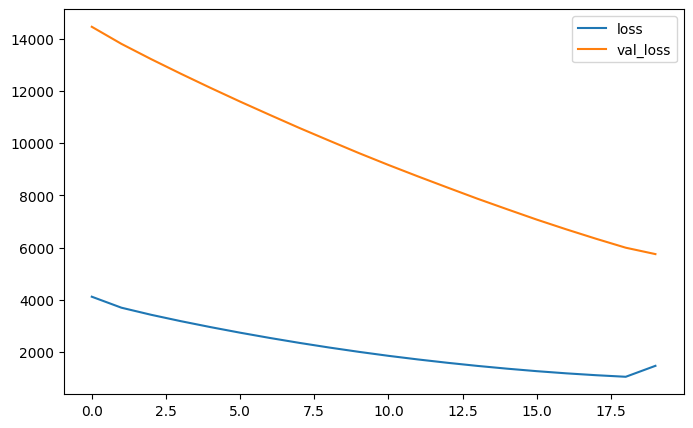

##################################################


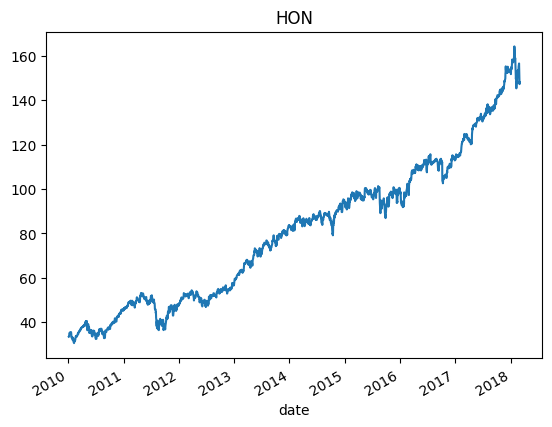

HON
(2055,)
Epoch 1/20
12/12 [==============================] - 2s 35ms/step - loss: 4228.5498 - val_loss: 10718.8525
Epoch 2/20
12/12 [==============================] - 0s 11ms/step - loss: 3728.3418 - val_loss: 10133.3369
Epoch 3/20
12/12 [==============================] - 0s 12ms/step - loss: 3431.1521 - val_loss: 9628.5107
Epoch 4/20
12/12 [==============================] - 0s 12ms/step - loss: 3167.1697 - val_loss: 9156.1221
Epoch 5/20
12/12 [==============================] - 0s 12ms/step - loss: 2920.5818 - val_loss: 8695.9814
Epoch 6/20
12/12 [==============================] - 0s 12ms/step - loss: 2685.8457 - val_loss: 8248.2783
Epoch 7/20
12/12 [==============================] - 0s 13ms/step - loss: 2463.4202 - val_loss: 7814.4702
Epoch 8/20
12/12 [==============================] - 0s 13ms/step - loss: 2254.0298 - val_loss: 7394.2378
Epoch 9/20
12/12 [==============================] - 0s 12ms/step - loss: 2056.8267 - val_loss: 6985.6333
Epoch 10/20
12/12 [======================

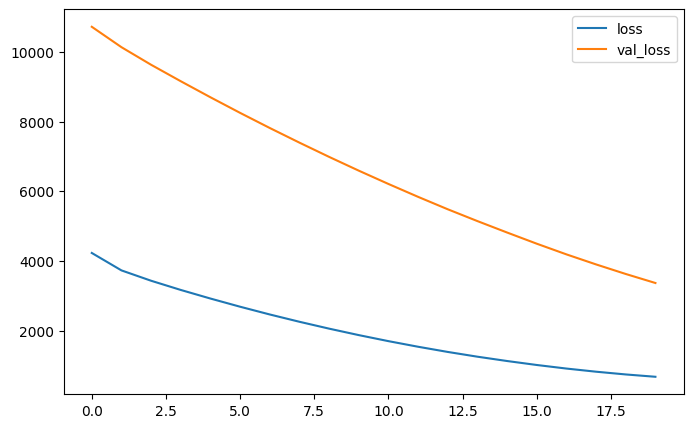

##################################################


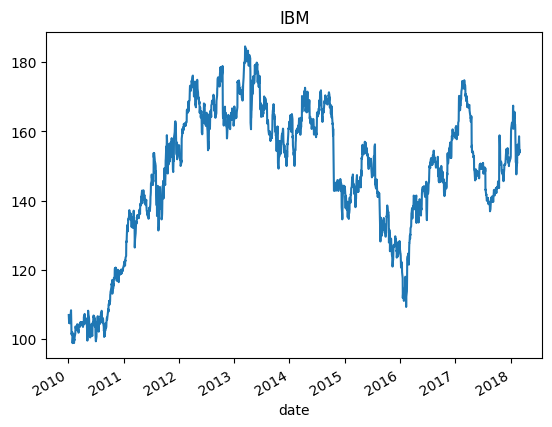

IBM
(2055,)
Epoch 1/20
12/12 [==============================] - 2s 60ms/step - loss: 21179.7031 - val_loss: 20526.2031
Epoch 2/20
12/12 [==============================] - 0s 8ms/step - loss: 19769.7617 - val_loss: 19619.3223
Epoch 3/20
12/12 [==============================] - 0s 8ms/step - loss: 18979.9316 - val_loss: 18884.0098
Epoch 4/20
12/12 [==============================] - 0s 9ms/step - loss: 18282.0430 - val_loss: 18195.9238
Epoch 5/20
12/12 [==============================] - 0s 8ms/step - loss: 17616.6055 - val_loss: 17528.0449
Epoch 6/20
12/12 [==============================] - 0s 8ms/step - loss: 16969.4062 - val_loss: 16877.4492
Epoch 7/20
12/12 [==============================] - 0s 9ms/step - loss: 16336.5732 - val_loss: 16238.7314
Epoch 8/20
12/12 [==============================] - 0s 8ms/step - loss: 15716.4922 - val_loss: 15614.3174
Epoch 9/20
12/12 [==============================] - 0s 9ms/step - loss: 15109.9668 - val_loss: 15001.6953
Epoch 10/20
12/12 [==============

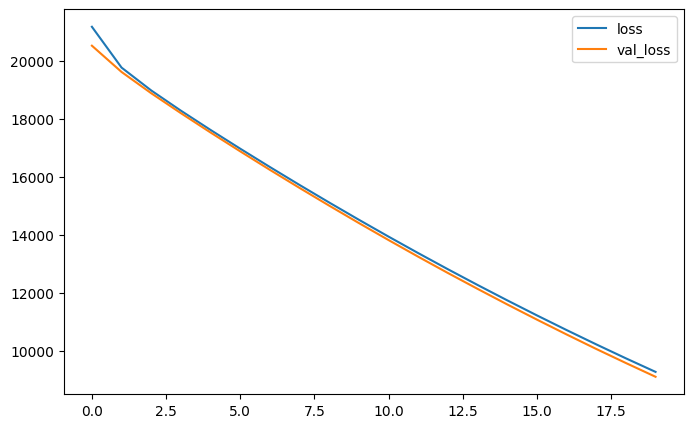

##################################################


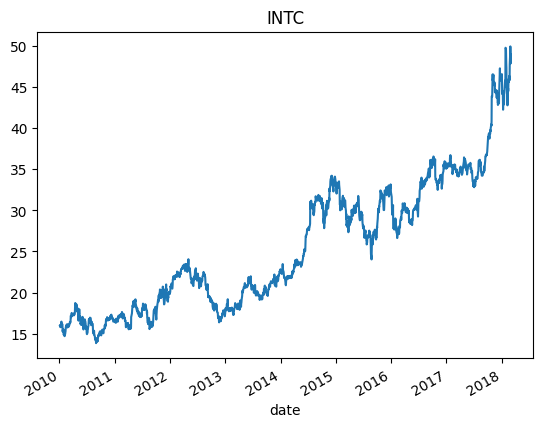

INTC
(2055,)
Epoch 1/20
12/12 [==============================] - 1s 27ms/step - loss: 410.9651 - val_loss: 752.9669
Epoch 2/20
12/12 [==============================] - 0s 9ms/step - loss: 256.4685 - val_loss: 606.8528
Epoch 3/20
12/12 [==============================] - 0s 9ms/step - loss: 185.7489 - val_loss: 497.1079
Epoch 4/20
12/12 [==============================] - 0s 9ms/step - loss: 134.0629 - val_loss: 404.9251
Epoch 5/20
12/12 [==============================] - 0s 9ms/step - loss: 94.9766 - val_loss: 326.3532
Epoch 6/20
12/12 [==============================] - 0s 9ms/step - loss: 66.2260 - val_loss: 259.9204
Epoch 7/20
12/12 [==============================] - 0s 9ms/step - loss: 46.7593 - val_loss: 205.5211
Epoch 8/20
12/12 [==============================] - 0s 8ms/step - loss: 35.5519 - val_loss: 166.2187
Epoch 9/20
12/12 [==============================] - 0s 9ms/step - loss: 30.6992 - val_loss: 141.1549
Epoch 10/20
12/12 [==============================] - 0s 8ms/step - loss: 

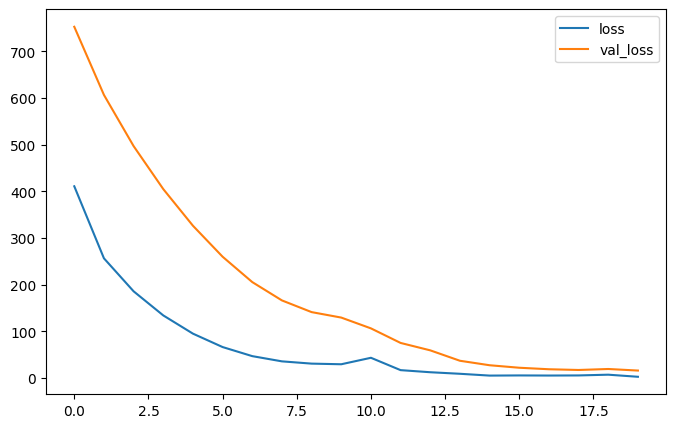

##################################################


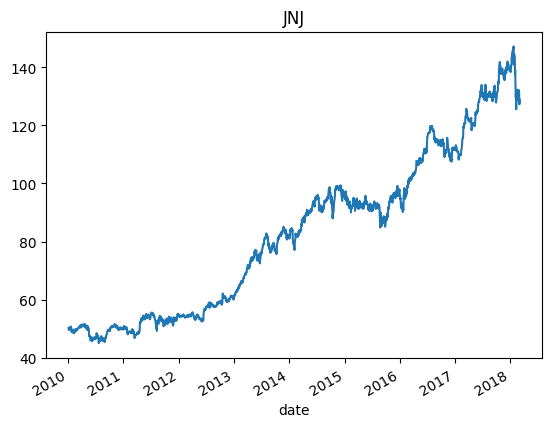

JNJ
(2055,)
Epoch 1/20
12/12 [==============================] - 1s 26ms/step - loss: 4722.8506 - val_loss: 11046.4600
Epoch 2/20
12/12 [==============================] - 0s 8ms/step - loss: 4212.2900 - val_loss: 10475.3008
Epoch 3/20
12/12 [==============================] - 0s 9ms/step - loss: 3888.8923 - val_loss: 9960.8643
Epoch 4/20
12/12 [==============================] - 0s 9ms/step - loss: 3596.4417 - val_loss: 9473.7510
Epoch 5/20
12/12 [==============================] - 0s 8ms/step - loss: 3322.2617 - val_loss: 9005.6387
Epoch 6/20
12/12 [==============================] - 0s 8ms/step - loss: 3061.4202 - val_loss: 8547.6152
Epoch 7/20
12/12 [==============================] - 0s 8ms/step - loss: 2812.8821 - val_loss: 8104.2710
Epoch 8/20
12/12 [==============================] - 0s 9ms/step - loss: 2577.0095 - val_loss: 7673.1685
Epoch 9/20
12/12 [==============================] - 0s 8ms/step - loss: 2353.6440 - val_loss: 7256.1709
Epoch 10/20
12/12 [==============================

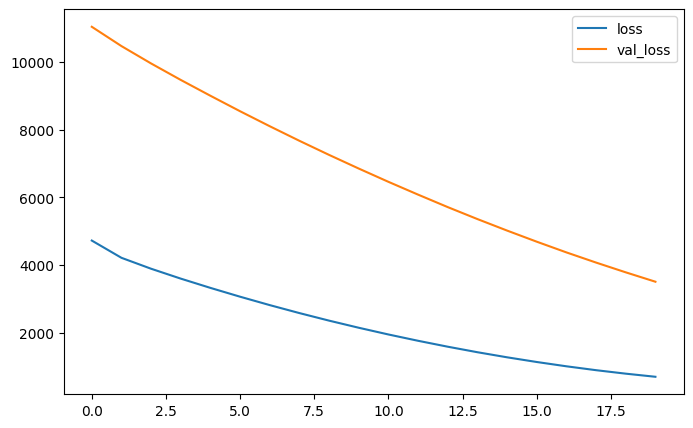

##################################################


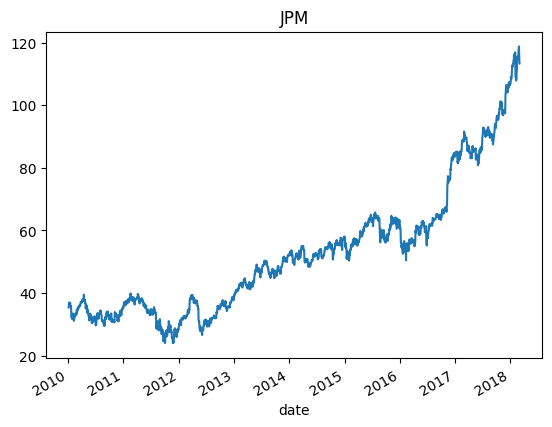

JPM
(2055,)
Epoch 1/20
12/12 [==============================] - 1s 27ms/step - loss: 1730.2328 - val_loss: 3857.6846
Epoch 2/20
12/12 [==============================] - 0s 8ms/step - loss: 1330.5310 - val_loss: 3488.1833
Epoch 3/20
12/12 [==============================] - 0s 9ms/step - loss: 1143.5758 - val_loss: 3197.2688
Epoch 4/20
12/12 [==============================] - 0s 9ms/step - loss: 991.3299 - val_loss: 2933.7937
Epoch 5/20
12/12 [==============================] - 0s 8ms/step - loss: 855.4082 - val_loss: 2685.0066
Epoch 6/20
12/12 [==============================] - 0s 8ms/step - loss: 732.4066 - val_loss: 2449.6421
Epoch 7/20
12/12 [==============================] - 0s 9ms/step - loss: 621.9185 - val_loss: 2229.4341
Epoch 8/20
12/12 [==============================] - 0s 8ms/step - loss: 524.0821 - val_loss: 2022.9075
Epoch 9/20
12/12 [==============================] - 0s 8ms/step - loss: 437.5426 - val_loss: 1827.5638
Epoch 10/20
12/12 [==============================] - 0s 8

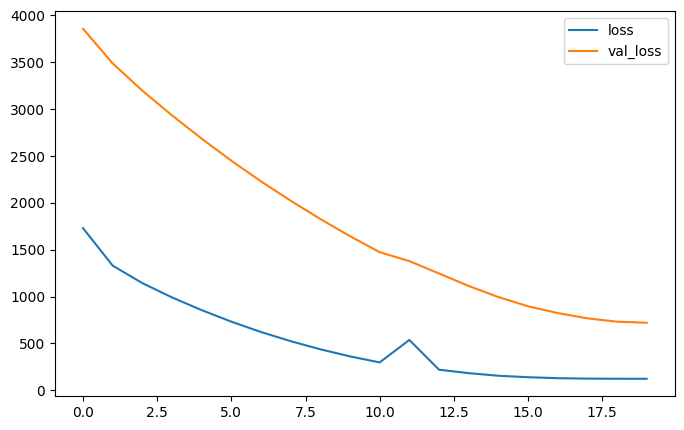

##################################################


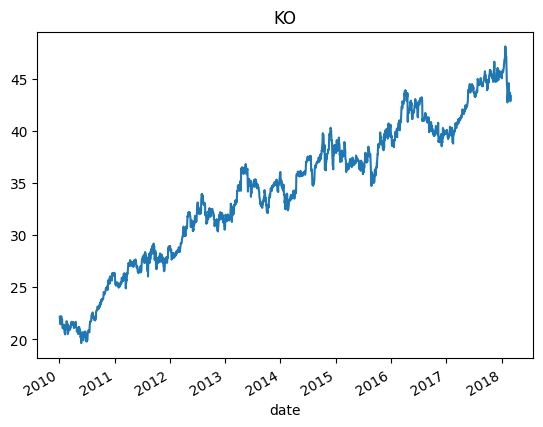

KO
(2055,)
Epoch 1/20
12/12 [==============================] - 1s 26ms/step - loss: 741.8757 - val_loss: 1062.8774
Epoch 2/20
12/12 [==============================] - 0s 8ms/step - loss: 519.8600 - val_loss: 894.7205
Epoch 3/20
12/12 [==============================] - 0s 9ms/step - loss: 414.1263 - val_loss: 756.5534
Epoch 4/20
12/12 [==============================] - 0s 8ms/step - loss: 327.0766 - val_loss: 634.5049
Epoch 5/20
12/12 [==============================] - 0s 8ms/step - loss: 253.2514 - val_loss: 525.6878
Epoch 6/20
12/12 [==============================] - 0s 9ms/step - loss: 191.6518 - val_loss: 430.0953
Epoch 7/20
12/12 [==============================] - 0s 9ms/step - loss: 140.8002 - val_loss: 344.9270
Epoch 8/20
12/12 [==============================] - 0s 8ms/step - loss: 100.5212 - val_loss: 272.6128
Epoch 9/20
12/12 [==============================] - 0s 8ms/step - loss: 70.7304 - val_loss: 211.9892
Epoch 10/20
12/12 [==============================] - 0s 8ms/step - los

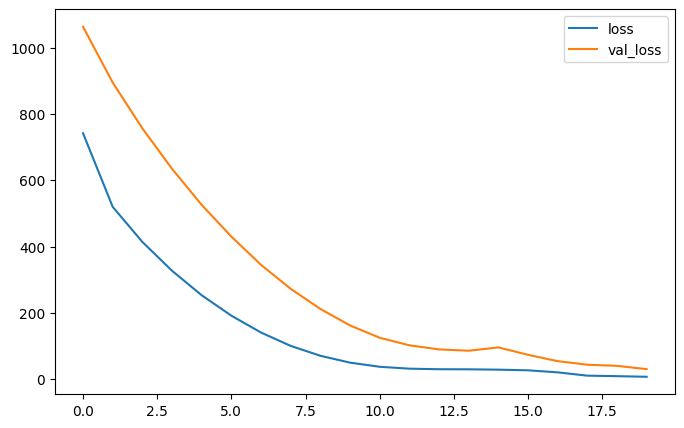

##################################################


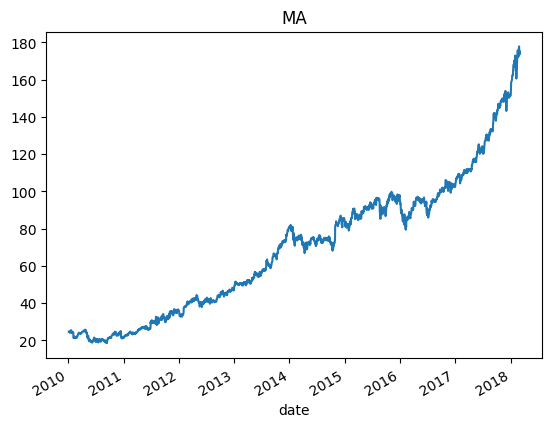

MA
(2055,)
Epoch 1/20
12/12 [==============================] - 1s 26ms/step - loss: 3066.4050 - val_loss: 8156.7446
Epoch 2/20
12/12 [==============================] - 0s 9ms/step - loss: 2604.8345 - val_loss: 7655.1743
Epoch 3/20
12/12 [==============================] - 0s 9ms/step - loss: 2375.7661 - val_loss: 7219.5142
Epoch 4/20
12/12 [==============================] - 0s 9ms/step - loss: 2176.6741 - val_loss: 6817.6719
Epoch 5/20
12/12 [==============================] - 0s 9ms/step - loss: 1993.5907 - val_loss: 6424.9922
Epoch 6/20
12/12 [==============================] - 0s 9ms/step - loss: 1821.2155 - val_loss: 6044.8232
Epoch 7/20
12/12 [==============================] - 0s 9ms/step - loss: 1662.7892 - val_loss: 5682.5234
Epoch 8/20
12/12 [==============================] - 0s 9ms/step - loss: 1516.9042 - val_loss: 5333.9639
Epoch 9/20
12/12 [==============================] - 0s 9ms/step - loss: 1382.7157 - val_loss: 4995.6934
Epoch 10/20
12/12 [==============================] -

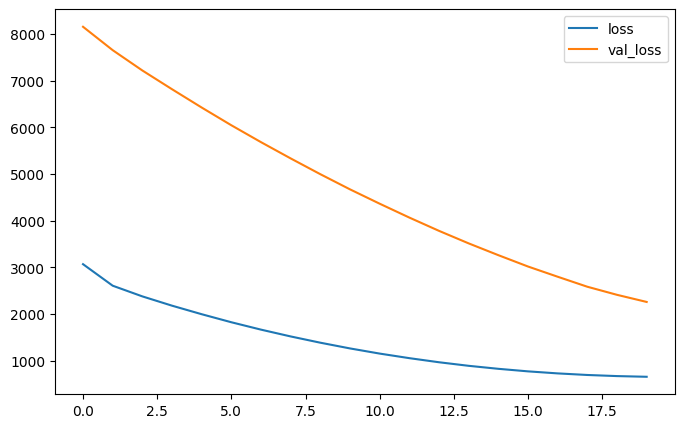

##################################################


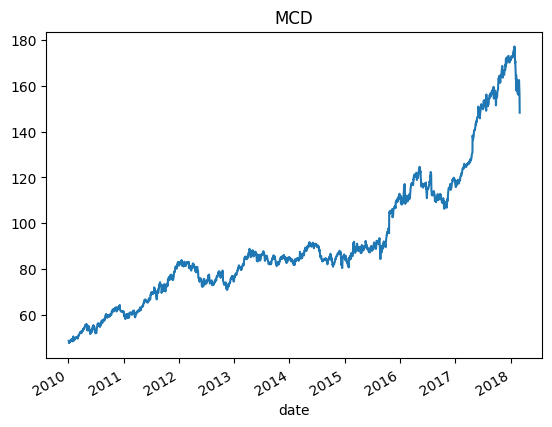

MCD
(2055,)
Epoch 1/20
12/12 [==============================] - 1s 26ms/step - loss: 5619.8237 - val_loss: 11688.6299
Epoch 2/20
12/12 [==============================] - 0s 9ms/step - loss: 5009.4595 - val_loss: 11080.0195
Epoch 3/20
12/12 [==============================] - 0s 8ms/step - loss: 4644.8896 - val_loss: 10551.5723
Epoch 4/20
12/12 [==============================] - 0s 9ms/step - loss: 4316.0322 - val_loss: 10048.6494
Epoch 5/20
12/12 [==============================] - 0s 9ms/step - loss: 4004.9817 - val_loss: 9563.0000
Epoch 6/20
12/12 [==============================] - 0s 9ms/step - loss: 3708.0120 - val_loss: 9091.6455
Epoch 7/20
12/12 [==============================] - 0s 8ms/step - loss: 3424.0491 - val_loss: 8632.6475
Epoch 8/20
12/12 [==============================] - 0s 8ms/step - loss: 3152.3821 - val_loss: 8186.1968
Epoch 9/20
12/12 [==============================] - 0s 9ms/step - loss: 2892.4719 - val_loss: 7751.6973
Epoch 10/20
12/12 [============================

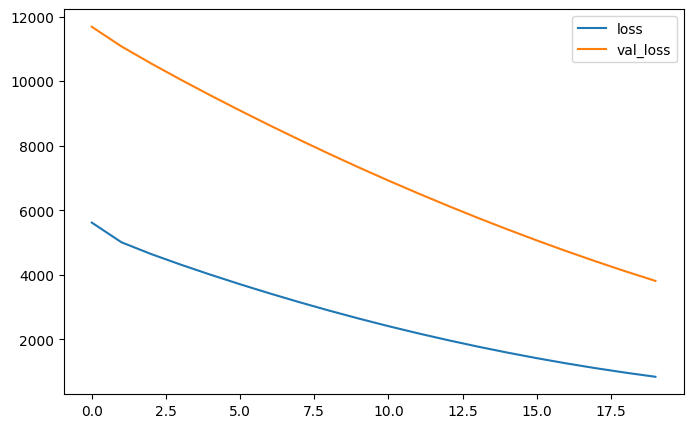

##################################################


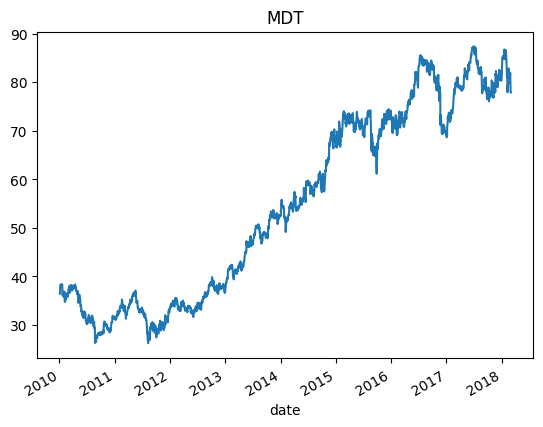

MDT
(2055,)
Epoch 1/20
12/12 [==============================] - 1s 27ms/step - loss: 1961.7601 - val_loss: 4909.3950
Epoch 2/20
12/12 [==============================] - 0s 9ms/step - loss: 1598.9325 - val_loss: 4511.6792
Epoch 3/20
12/12 [==============================] - 0s 9ms/step - loss: 1408.4125 - val_loss: 4181.5259
Epoch 4/20
12/12 [==============================] - 0s 9ms/step - loss: 1245.2699 - val_loss: 3873.6099
Epoch 5/20
12/12 [==============================] - 0s 8ms/step - loss: 1098.2676 - val_loss: 3586.0610
Epoch 6/20
12/12 [==============================] - 0s 8ms/step - loss: 965.2816 - val_loss: 3310.8872
Epoch 7/20
12/12 [==============================] - 0s 9ms/step - loss: 843.4136 - val_loss: 3046.5366
Epoch 8/20
12/12 [==============================] - 0s 8ms/step - loss: 733.2344 - val_loss: 2795.6768
Epoch 9/20
12/12 [==============================] - 0s 9ms/step - loss: 634.5630 - val_loss: 2556.6270
Epoch 10/20
12/12 [==============================] - 0s

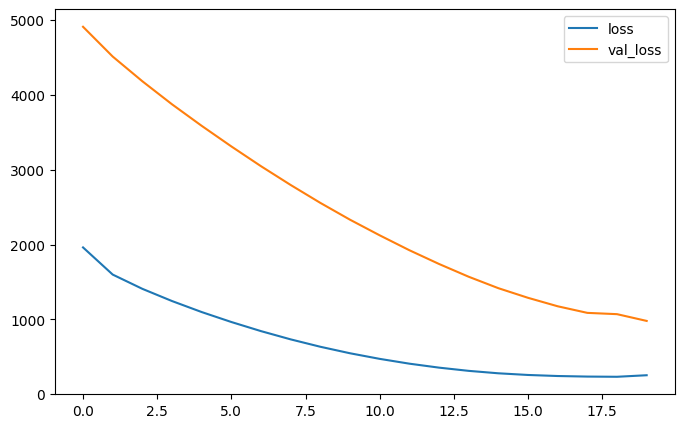

##################################################


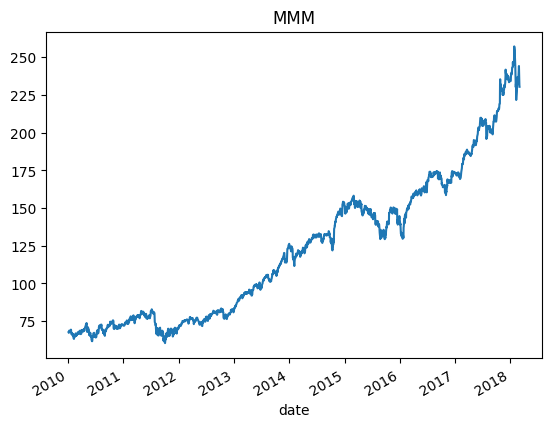

MMM
(2055,)
Epoch 1/20
12/12 [==============================] - 1s 28ms/step - loss: 10345.5615 - val_loss: 25966.5586
Epoch 2/20
12/12 [==============================] - 0s 8ms/step - loss: 9535.7754 - val_loss: 25001.8867
Epoch 3/20
12/12 [==============================] - 0s 10ms/step - loss: 9029.6289 - val_loss: 24186.3750
Epoch 4/20
12/12 [==============================] - 0s 9ms/step - loss: 8577.8779 - val_loss: 23414.8223
Epoch 5/20
12/12 [==============================] - 0s 8ms/step - loss: 8148.1299 - val_loss: 22663.3477
Epoch 6/20
12/12 [==============================] - 0s 8ms/step - loss: 7734.5562 - val_loss: 21929.8418
Epoch 7/20
12/12 [==============================] - 0s 9ms/step - loss: 7334.0825 - val_loss: 21206.1855
Epoch 8/20
12/12 [==============================] - 0s 8ms/step - loss: 6945.0356 - val_loss: 20493.3320
Epoch 9/20
12/12 [==============================] - 0s 8ms/step - loss: 6568.9326 - val_loss: 19796.0801
Epoch 10/20
12/12 [=====================

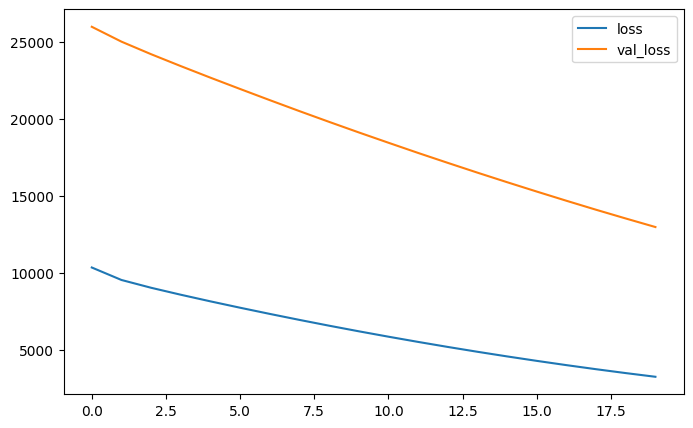

##################################################


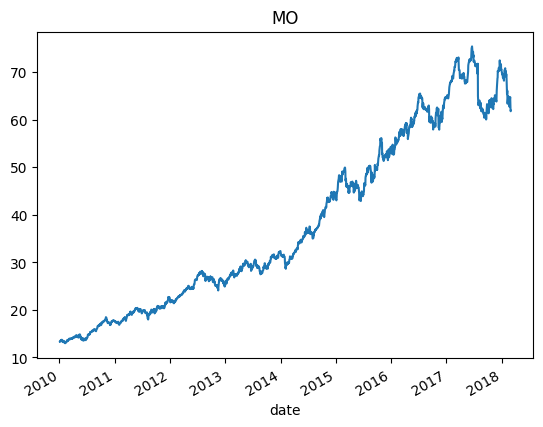

MO
(2055,)
Epoch 1/20
12/12 [==============================] - 2s 26ms/step - loss: 759.8887 - val_loss: 2995.6338
Epoch 2/20
12/12 [==============================] - 0s 8ms/step - loss: 584.3514 - val_loss: 2711.7263
Epoch 3/20
12/12 [==============================] - 0s 9ms/step - loss: 484.2889 - val_loss: 2469.4131
Epoch 4/20
12/12 [==============================] - 0s 9ms/step - loss: 402.1982 - val_loss: 2244.5835
Epoch 5/20
12/12 [==============================] - 0s 9ms/step - loss: 333.0445 - val_loss: 2038.6517
Epoch 6/20
12/12 [==============================] - 0s 9ms/step - loss: 275.9678 - val_loss: 1847.7076
Epoch 7/20
12/12 [==============================] - 0s 9ms/step - loss: 229.6386 - val_loss: 1670.0505
Epoch 8/20
12/12 [==============================] - 0s 9ms/step - loss: 193.4547 - val_loss: 1507.6982
Epoch 9/20
12/12 [==============================] - 0s 8ms/step - loss: 167.4528 - val_loss: 1365.9364
Epoch 10/20
12/12 [==============================] - 0s 8ms/s

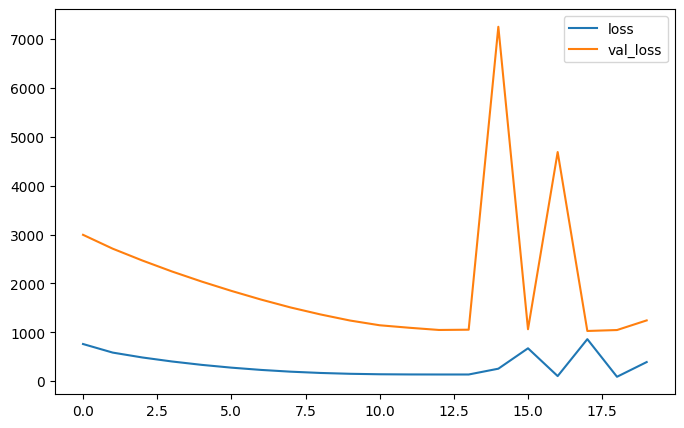

##################################################


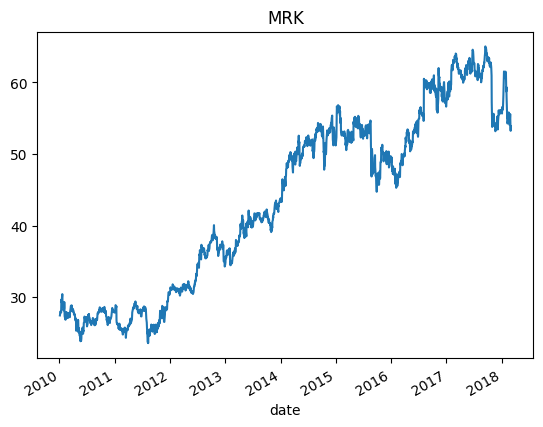

MRK
(2055,)
Epoch 1/20
12/12 [==============================] - 1s 28ms/step - loss: 1196.8413 - val_loss: 2344.5364
Epoch 2/20
12/12 [==============================] - 0s 8ms/step - loss: 934.3690 - val_loss: 2088.4282
Epoch 3/20
12/12 [==============================] - 0s 9ms/step - loss: 792.6307 - val_loss: 1870.5535
Epoch 4/20
12/12 [==============================] - 0s 9ms/step - loss: 672.3065 - val_loss: 1672.1553
Epoch 5/20
12/12 [==============================] - 0s 9ms/step - loss: 565.8616 - val_loss: 1487.2435
Epoch 6/20
12/12 [==============================] - 0s 9ms/step - loss: 471.6444 - val_loss: 1314.8821
Epoch 7/20
12/12 [==============================] - 0s 8ms/step - loss: 389.4188 - val_loss: 1156.3977
Epoch 8/20
12/12 [==============================] - 0s 8ms/step - loss: 318.6439 - val_loss: 1009.9272
Epoch 9/20
12/12 [==============================] - 0s 9ms/step - loss: 258.7116 - val_loss: 875.6219
Epoch 10/20
12/12 [==============================] - 0s 8ms/

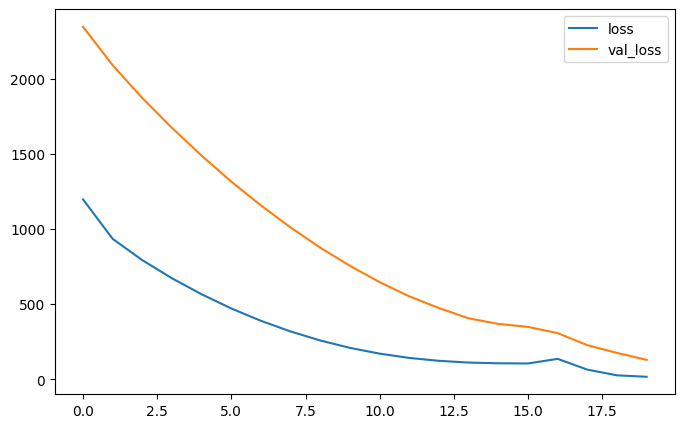

##################################################


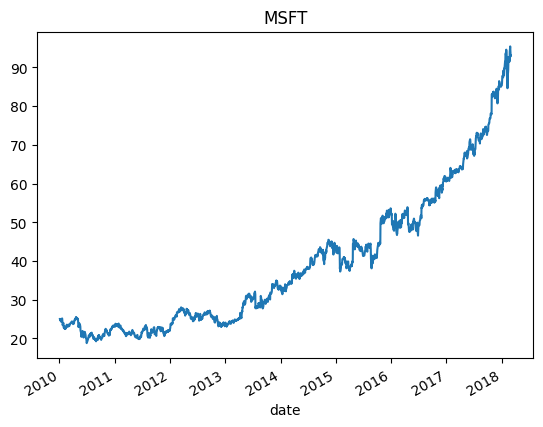

MSFT
(2055,)
Epoch 1/20
12/12 [==============================] - 1s 26ms/step - loss: 782.7684 - val_loss: 2275.7986
Epoch 2/20
12/12 [==============================] - 0s 8ms/step - loss: 542.2416 - val_loss: 2018.9761
Epoch 3/20
12/12 [==============================] - 0s 9ms/step - loss: 437.8714 - val_loss: 1807.8650
Epoch 4/20
12/12 [==============================] - 0s 9ms/step - loss: 354.1417 - val_loss: 1616.6737
Epoch 5/20
12/12 [==============================] - 0s 8ms/step - loss: 284.0736 - val_loss: 1441.9417
Epoch 6/20
12/12 [==============================] - 0s 9ms/step - loss: 226.1965 - val_loss: 1282.0300
Epoch 7/20
12/12 [==============================] - 0s 8ms/step - loss: 179.1893 - val_loss: 1134.9158
Epoch 8/20
12/12 [==============================] - 0s 8ms/step - loss: 142.6364 - val_loss: 1001.7507
Epoch 9/20
12/12 [==============================] - 0s 9ms/step - loss: 116.0948 - val_loss: 885.8852
Epoch 10/20
12/12 [==============================] - 0s 8ms/

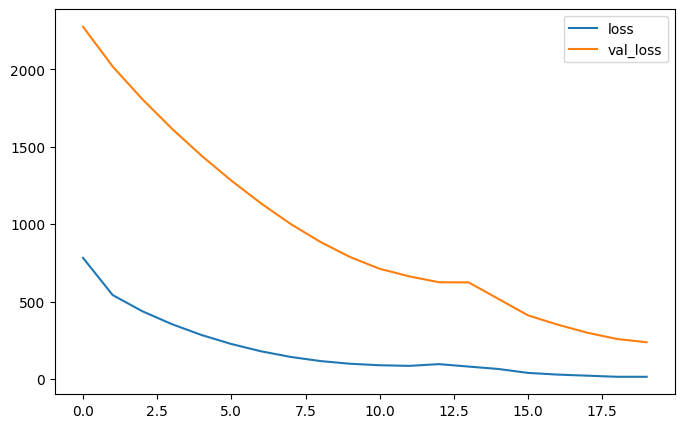

##################################################


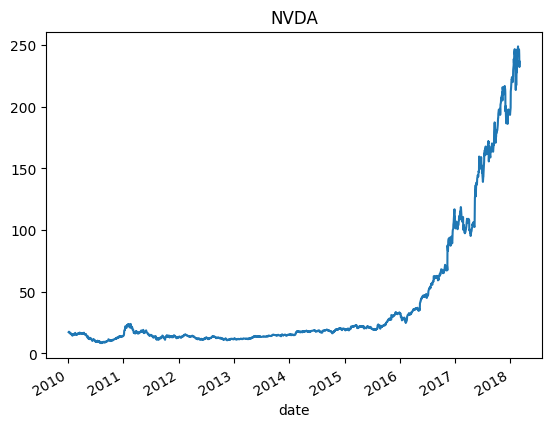

NVDA
(2055,)
Epoch 1/20
12/12 [==============================] - 1s 26ms/step - loss: 169.3105 - val_loss: 4404.5771
Epoch 2/20
12/12 [==============================] - 0s 8ms/step - loss: 89.7767 - val_loss: 4105.1147
Epoch 3/20
12/12 [==============================] - 0s 8ms/step - loss: 58.1012 - val_loss: 3865.7163
Epoch 4/20
12/12 [==============================] - 0s 9ms/step - loss: 39.0419 - val_loss: 3661.8816
Epoch 5/20
12/12 [==============================] - 0s 8ms/step - loss: 28.8906 - val_loss: 3504.1938
Epoch 6/20
12/12 [==============================] - 0s 9ms/step - loss: 24.8623 - val_loss: 3414.0969
Epoch 7/20
12/12 [==============================] - 0s 8ms/step - loss: 23.9598 - val_loss: 3370.1021
Epoch 8/20
12/12 [==============================] - 0s 8ms/step - loss: 23.7068 - val_loss: 3335.2837
Epoch 9/20
12/12 [==============================] - 0s 8ms/step - loss: 21.1321 - val_loss: 3136.7808
Epoch 10/20
12/12 [==============================] - 0s 8ms/step - 

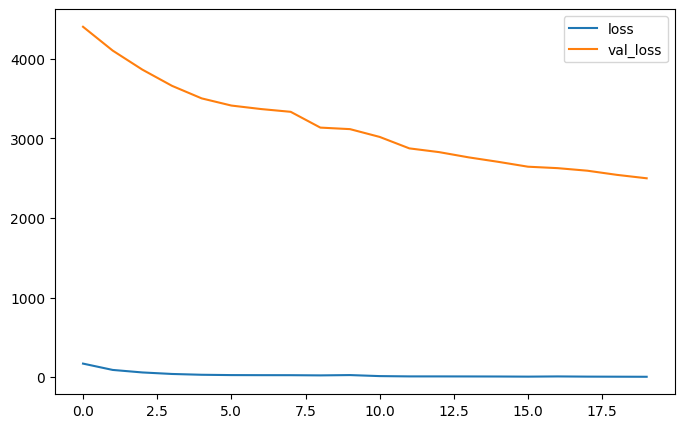

##################################################


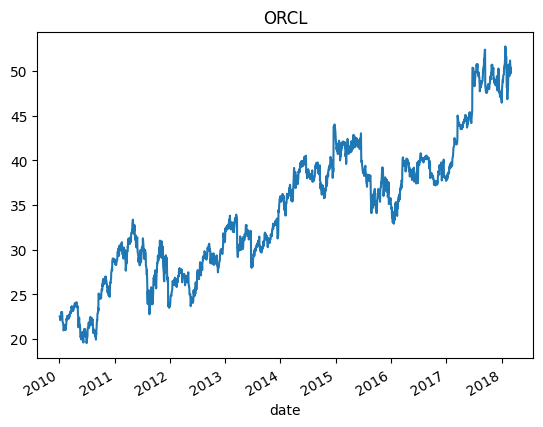

ORCL
(2055,)
Epoch 1/20
12/12 [==============================] - 1s 26ms/step - loss: 723.3134 - val_loss: 929.9857
Epoch 2/20
12/12 [==============================] - 0s 8ms/step - loss: 509.5354 - val_loss: 772.3790
Epoch 3/20
12/12 [==============================] - 0s 9ms/step - loss: 405.0088 - val_loss: 643.8924
Epoch 4/20
12/12 [==============================] - 0s 9ms/step - loss: 319.8097 - val_loss: 532.3465
Epoch 5/20
12/12 [==============================] - 0s 9ms/step - loss: 247.8341 - val_loss: 433.0309
Epoch 6/20
12/12 [==============================] - 0s 8ms/step - loss: 187.5510 - val_loss: 346.3591
Epoch 7/20
12/12 [==============================] - 0s 8ms/step - loss: 138.5772 - val_loss: 271.4301
Epoch 8/20
12/12 [==============================] - 0s 9ms/step - loss: 100.0509 - val_loss: 207.7856
Epoch 9/20
12/12 [==============================] - 0s 9ms/step - loss: 71.4691 - val_loss: 154.8565
Epoch 10/20
12/12 [==============================] - 0s 8ms/step - lo

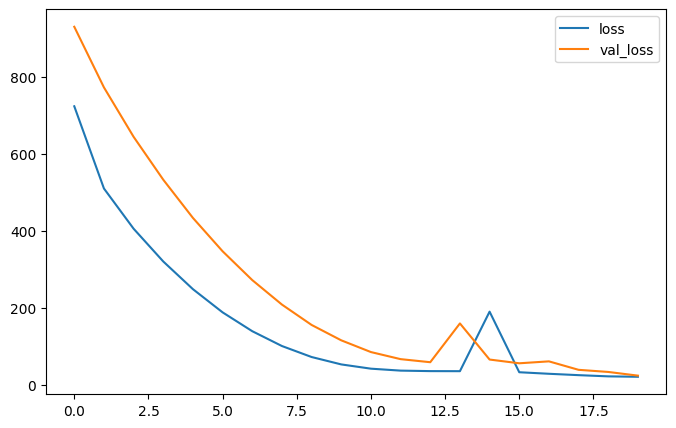

##################################################


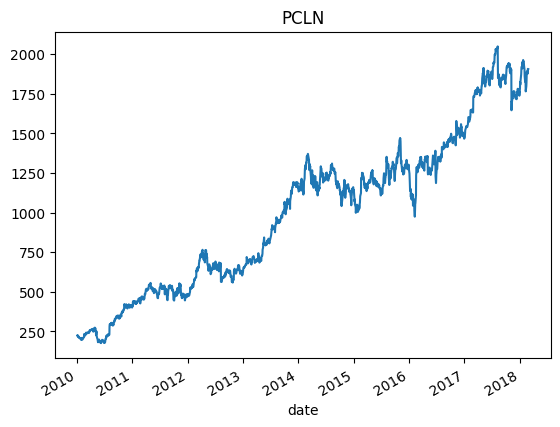

PCLN
(2055,)
Epoch 1/20
12/12 [==============================] - 2s 27ms/step - loss: 758859.3125 - val_loss: 2014446.2500
Epoch 2/20
12/12 [==============================] - 0s 9ms/step - loss: 752149.1875 - val_loss: 2006429.8750
Epoch 3/20
12/12 [==============================] - 0s 9ms/step - loss: 747886.1875 - val_loss: 1999105.1250
Epoch 4/20
12/12 [==============================] - 0s 9ms/step - loss: 743846.3750 - val_loss: 1991952.1250
Epoch 5/20
12/12 [==============================] - 0s 9ms/step - loss: 739872.1250 - val_loss: 1984837.6250
Epoch 6/20
12/12 [==============================] - 0s 10ms/step - loss: 735934.6250 - val_loss: 1977779.6250
Epoch 7/20
12/12 [==============================] - 0s 10ms/step - loss: 732025.2500 - val_loss: 1970771.0000
Epoch 8/20
12/12 [==============================] - 0s 9ms/step - loss: 728130.2500 - val_loss: 1963748.3750
Epoch 9/20
12/12 [==============================] - 0s 9ms/step - loss: 724233.3125 - val_loss: 1956703.3750
Epo

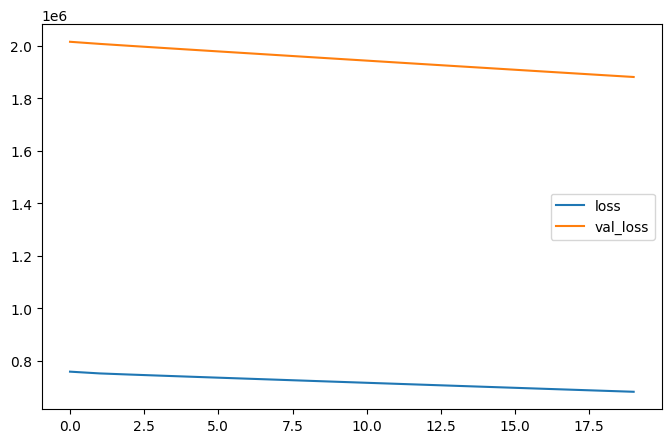

##################################################


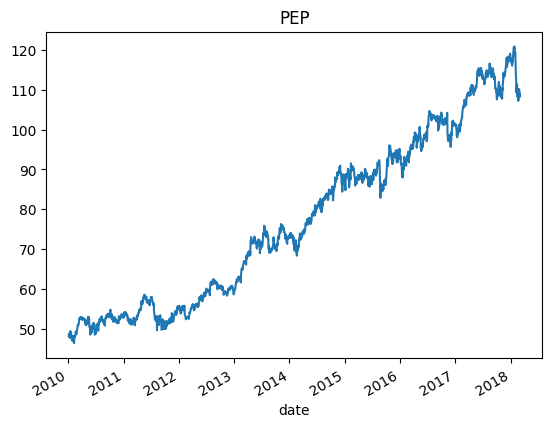

PEP
(2055,)
Epoch 1/20
12/12 [==============================] - 1s 29ms/step - loss: 4150.5879 - val_loss: 8517.7686
Epoch 2/20
12/12 [==============================] - 0s 13ms/step - loss: 3618.2278 - val_loss: 8006.1675
Epoch 3/20
12/12 [==============================] - 0s 11ms/step - loss: 3315.6213 - val_loss: 7560.4385
Epoch 4/20
12/12 [==============================] - 0s 11ms/step - loss: 3043.8396 - val_loss: 7136.4829
Epoch 5/20
12/12 [==============================] - 0s 12ms/step - loss: 2788.9983 - val_loss: 6732.0913
Epoch 6/20
12/12 [==============================] - 0s 13ms/step - loss: 2548.3254 - val_loss: 6339.9902
Epoch 7/20
12/12 [==============================] - 0s 14ms/step - loss: 2319.9670 - val_loss: 5960.1475
Epoch 8/20
12/12 [==============================] - 0s 13ms/step - loss: 2103.6543 - val_loss: 5593.4385
Epoch 9/20
12/12 [==============================] - 0s 13ms/step - loss: 1899.5619 - val_loss: 5238.2773
Epoch 10/20
12/12 [========================

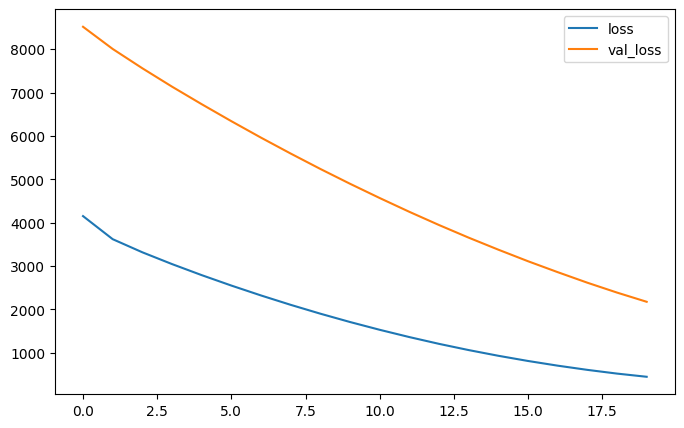

##################################################


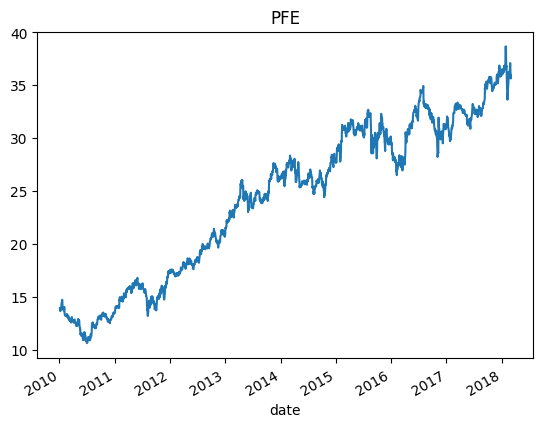

PFE
(2055,)
Epoch 1/20
12/12 [==============================] - 1s 27ms/step - loss: 328.4588 - val_loss: 542.2000
Epoch 2/20
12/12 [==============================] - 0s 9ms/step - loss: 186.4537 - val_loss: 424.5652
Epoch 3/20
12/12 [==============================] - 0s 9ms/step - loss: 132.9678 - val_loss: 335.8174
Epoch 4/20
12/12 [==============================] - 0s 9ms/step - loss: 95.7349 - val_loss: 264.2295
Epoch 5/20
12/12 [==============================] - 0s 9ms/step - loss: 69.8388 - val_loss: 204.5753
Epoch 6/20
12/12 [==============================] - 0s 9ms/step - loss: 53.3543 - val_loss: 160.0978
Epoch 7/20
12/12 [==============================] - 0s 8ms/step - loss: 44.9589 - val_loss: 121.4011
Epoch 8/20
12/12 [==============================] - 0s 9ms/step - loss: 41.1650 - val_loss: 108.0252
Epoch 9/20
12/12 [==============================] - 0s 11ms/step - loss: 40.6843 - val_loss: 98.7496
Epoch 10/20
12/12 [==============================] - 0s 10ms/step - loss: 3

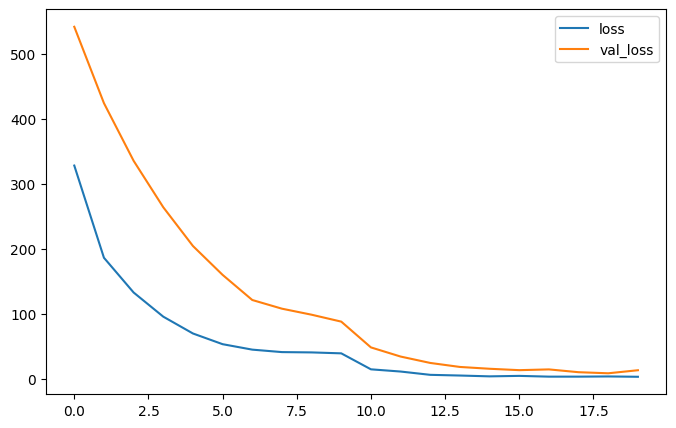

##################################################


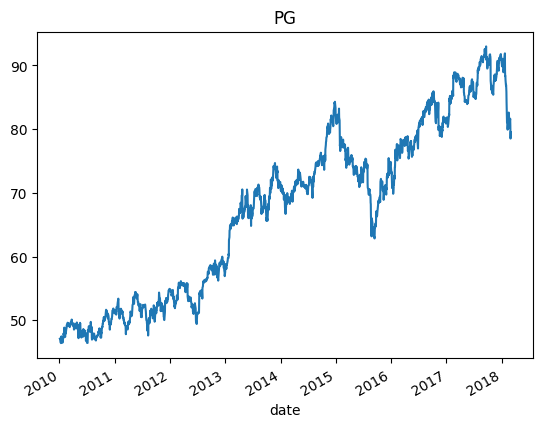

PG
(2055,)
Epoch 1/20
12/12 [==============================] - 1s 26ms/step - loss: 3447.7131 - val_loss: 5451.1299
Epoch 2/20
12/12 [==============================] - 0s 9ms/step - loss: 2948.1809 - val_loss: 5042.5620
Epoch 3/20
12/12 [==============================] - 0s 9ms/step - loss: 2671.3391 - val_loss: 4688.3657
Epoch 4/20
12/12 [==============================] - 0s 8ms/step - loss: 2424.8953 - val_loss: 4358.2334
Epoch 5/20
12/12 [==============================] - 0s 9ms/step - loss: 2195.7620 - val_loss: 4043.3738
Epoch 6/20
12/12 [==============================] - 0s 8ms/step - loss: 1980.0997 - val_loss: 3741.5715
Epoch 7/20
12/12 [==============================] - 0s 8ms/step - loss: 1777.3766 - val_loss: 3454.1106
Epoch 8/20
12/12 [==============================] - 0s 8ms/step - loss: 1587.2039 - val_loss: 3177.8022
Epoch 9/20
12/12 [==============================] - 0s 8ms/step - loss: 1408.3384 - val_loss: 2913.4917
Epoch 10/20
12/12 [==============================] -

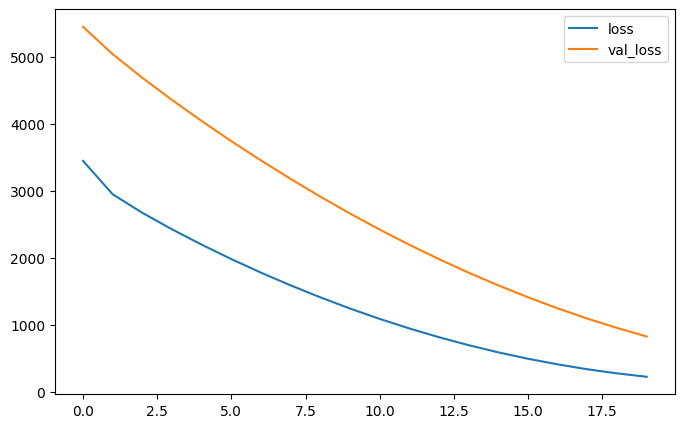

##################################################


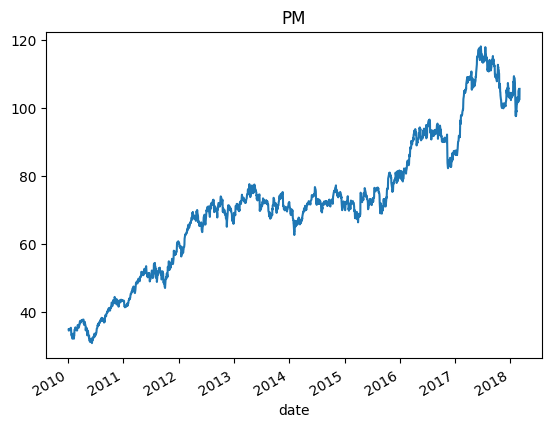

PM
(2055,)
Epoch 1/20
12/12 [==============================] - 1s 31ms/step - loss: 3426.6404 - val_loss: 6778.1035
Epoch 2/20
12/12 [==============================] - 0s 10ms/step - loss: 2963.2173 - val_loss: 6326.1606
Epoch 3/20
12/12 [==============================] - 0s 9ms/step - loss: 2691.8896 - val_loss: 5931.7290
Epoch 4/20
12/12 [==============================] - 0s 9ms/step - loss: 2449.6599 - val_loss: 5561.0898
Epoch 5/20
12/12 [==============================] - 0s 9ms/step - loss: 2223.5417 - val_loss: 5204.9604
Epoch 6/20
12/12 [==============================] - 0s 8ms/step - loss: 2010.9517 - val_loss: 4862.7153
Epoch 7/20
12/12 [==============================] - 0s 10ms/step - loss: 1810.3918 - val_loss: 4531.8940
Epoch 8/20
12/12 [==============================] - 0s 12ms/step - loss: 1622.0402 - val_loss: 4214.9033
Epoch 9/20
12/12 [==============================] - 0s 11ms/step - loss: 1446.5745 - val_loss: 3910.8489
Epoch 10/20
12/12 [=============================

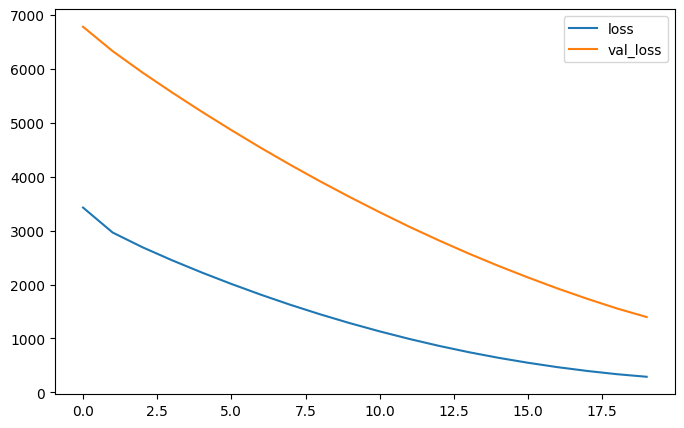

##################################################


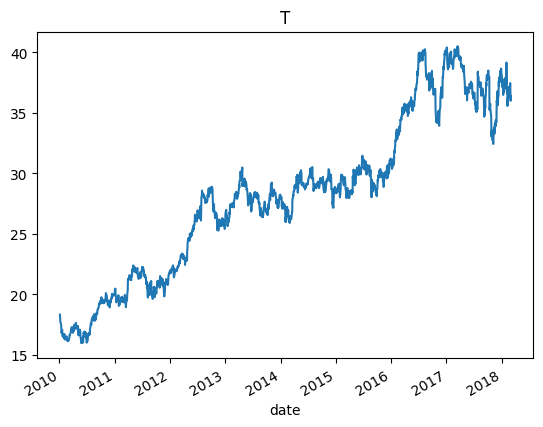

T
(2055,)
Epoch 1/20
12/12 [==============================] - 1s 26ms/step - loss: 511.6487 - val_loss: 937.4213
Epoch 2/20
12/12 [==============================] - 0s 9ms/step - loss: 307.1292 - val_loss: 765.9224
Epoch 3/20
12/12 [==============================] - 0s 9ms/step - loss: 223.1505 - val_loss: 636.6177
Epoch 4/20
12/12 [==============================] - 0s 9ms/step - loss: 161.6813 - val_loss: 527.7125
Epoch 5/20
12/12 [==============================] - 0s 9ms/step - loss: 113.9301 - val_loss: 433.7759
Epoch 6/20
12/12 [==============================] - 0s 9ms/step - loss: 77.5334 - val_loss: 352.9984
Epoch 7/20
12/12 [==============================] - 0s 9ms/step - loss: 52.4165 - val_loss: 283.5654
Epoch 8/20
12/12 [==============================] - 0s 9ms/step - loss: 34.0627 - val_loss: 229.1884
Epoch 9/20
12/12 [==============================] - 0s 8ms/step - loss: 24.7120 - val_loss: 189.3400
Epoch 10/20
12/12 [==============================] - 0s 8ms/step - loss: 20

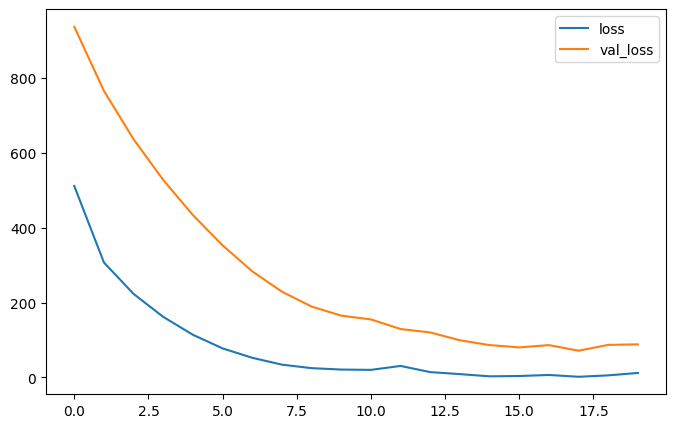

##################################################


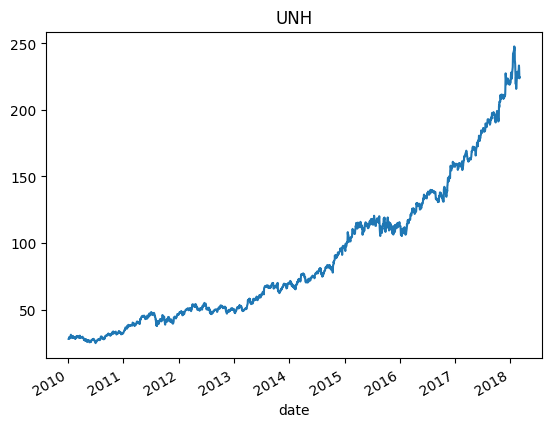

UNH
(2055,)
Epoch 1/20
12/12 [==============================] - 1s 26ms/step - loss: 4413.6650 - val_loss: 17990.0879
Epoch 2/20
12/12 [==============================] - 0s 9ms/step - loss: 3801.0867 - val_loss: 17154.3770
Epoch 3/20
12/12 [==============================] - 0s 8ms/step - loss: 3493.4473 - val_loss: 16466.9883
Epoch 4/20
12/12 [==============================] - 0s 9ms/step - loss: 3232.0320 - val_loss: 15834.9326
Epoch 5/20
12/12 [==============================] - 0s 8ms/step - loss: 2992.9727 - val_loss: 15226.8350
Epoch 6/20
12/12 [==============================] - 0s 9ms/step - loss: 2769.1873 - val_loss: 14636.6582
Epoch 7/20
12/12 [==============================] - 0s 8ms/step - loss: 2558.8584 - val_loss: 14060.9404
Epoch 8/20
12/12 [==============================] - 0s 8ms/step - loss: 2360.2788 - val_loss: 13496.9336
Epoch 9/20
12/12 [==============================] - 0s 8ms/step - loss: 2174.7805 - val_loss: 12950.8584
Epoch 10/20
12/12 [=======================

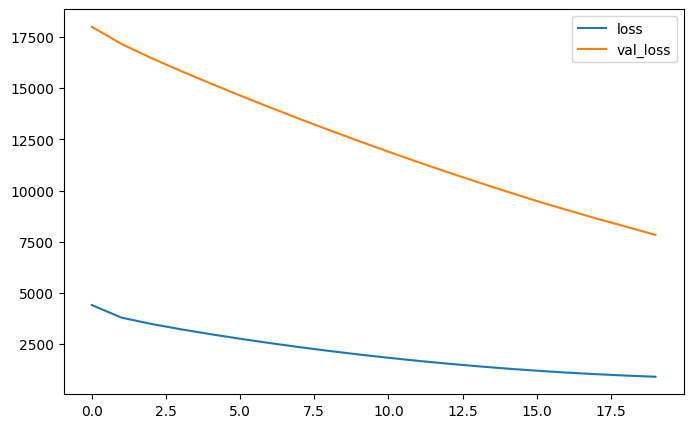

##################################################


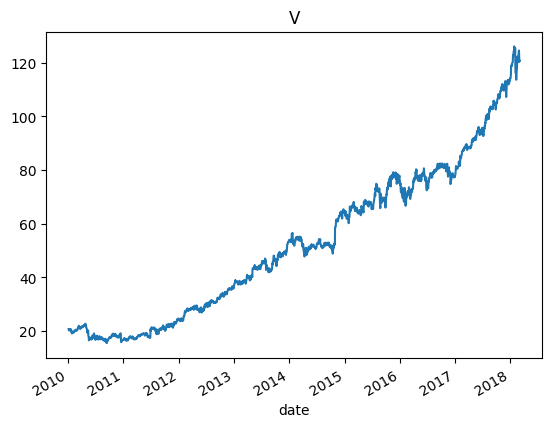

V
(2055,)
Epoch 1/20
12/12 [==============================] - 1s 27ms/step - loss: 1520.7585 - val_loss: 4846.9614
Epoch 2/20
12/12 [==============================] - 0s 8ms/step - loss: 1217.3950 - val_loss: 4471.6914
Epoch 3/20
12/12 [==============================] - 0s 8ms/step - loss: 1073.2487 - val_loss: 4149.8120
Epoch 4/20
12/12 [==============================] - 0s 8ms/step - loss: 950.3077 - val_loss: 3849.4138
Epoch 5/20
12/12 [==============================] - 0s 9ms/step - loss: 842.2391 - val_loss: 3566.3359
Epoch 6/20
12/12 [==============================] - 0s 9ms/step - loss: 746.7515 - val_loss: 3298.9873
Epoch 7/20
12/12 [==============================] - 0s 9ms/step - loss: 662.4423 - val_loss: 3039.8469
Epoch 8/20
12/12 [==============================] - 0s 9ms/step - loss: 589.1978 - val_loss: 2800.4951
Epoch 9/20
12/12 [==============================] - 0s 9ms/step - loss: 527.8818 - val_loss: 2574.1318
Epoch 10/20
12/12 [==============================] - 0s 8ms

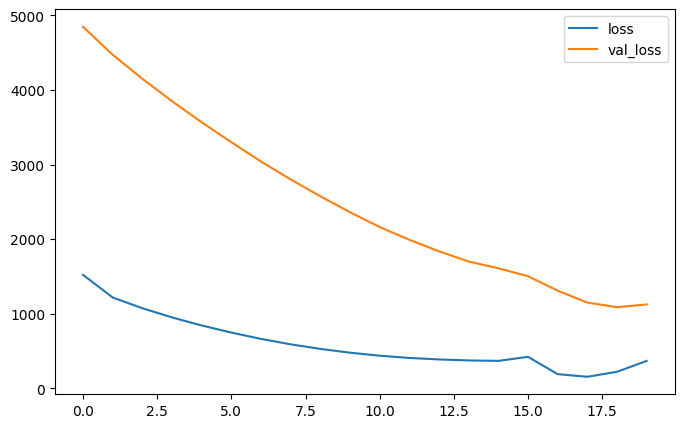

##################################################


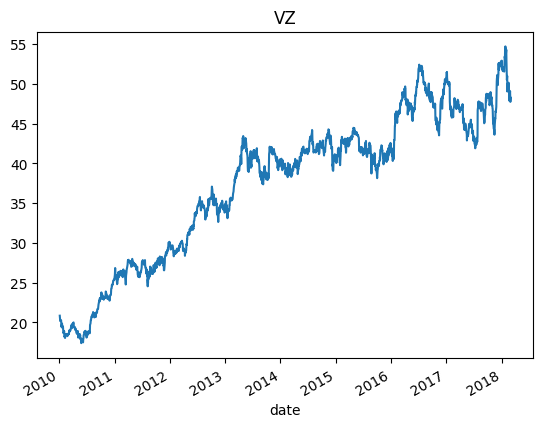

VZ
(2055,)
Epoch 1/20
12/12 [==============================] - 1s 26ms/step - loss: 953.6182 - val_loss: 1625.7371
Epoch 2/20
12/12 [==============================] - 0s 8ms/step - loss: 678.3715 - val_loss: 1396.0179
Epoch 3/20
12/12 [==============================] - 0s 9ms/step - loss: 553.4318 - val_loss: 1217.0505
Epoch 4/20
12/12 [==============================] - 0s 9ms/step - loss: 451.8354 - val_loss: 1059.4049
Epoch 5/20
12/12 [==============================] - 0s 9ms/step - loss: 365.4851 - val_loss: 914.9913
Epoch 6/20
12/12 [==============================] - 0s 9ms/step - loss: 291.5034 - val_loss: 783.9014
Epoch 7/20
12/12 [==============================] - 0s 9ms/step - loss: 228.9715 - val_loss: 665.4958
Epoch 8/20
12/12 [==============================] - 0s 8ms/step - loss: 177.4488 - val_loss: 558.5823
Epoch 9/20
12/12 [==============================] - 0s 9ms/step - loss: 136.5986 - val_loss: 465.2945
Epoch 10/20
12/12 [==============================] - 0s 8ms/step -

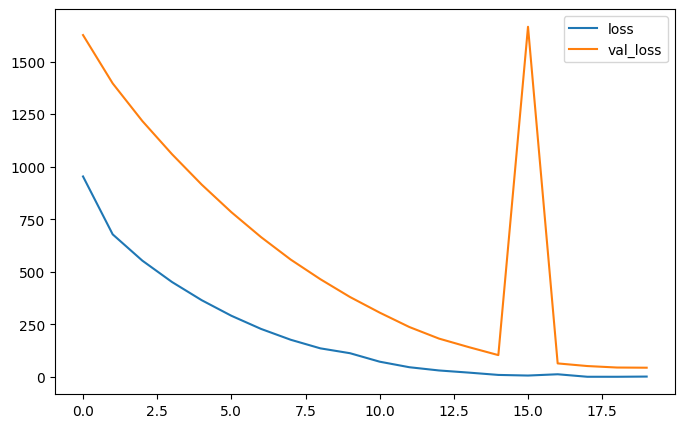

##################################################


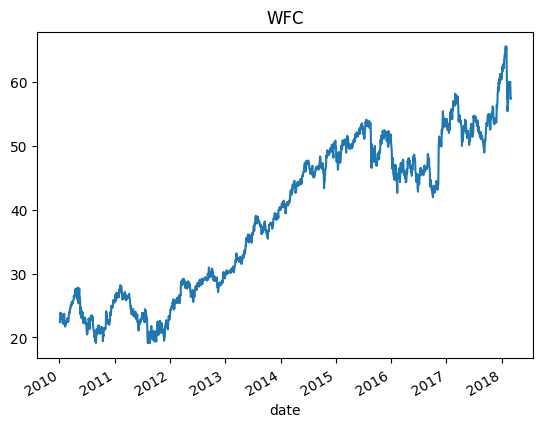

WFC
(2055,)
Epoch 1/20
12/12 [==============================] - 2s 26ms/step - loss: 990.2197 - val_loss: 1631.3254
Epoch 2/20
12/12 [==============================] - 0s 8ms/step - loss: 776.6100 - val_loss: 1420.7566
Epoch 3/20
12/12 [==============================] - 0s 9ms/step - loss: 652.2805 - val_loss: 1245.4431
Epoch 4/20
12/12 [==============================] - 0s 9ms/step - loss: 547.8889 - val_loss: 1086.2684
Epoch 5/20
12/12 [==============================] - 0s 9ms/step - loss: 457.0450 - val_loss: 941.3636
Epoch 6/20
12/12 [==============================] - 0s 8ms/step - loss: 378.3368 - val_loss: 808.6648
Epoch 7/20
12/12 [==============================] - 0s 8ms/step - loss: 310.6661 - val_loss: 687.8163
Epoch 8/20
12/12 [==============================] - 0s 8ms/step - loss: 254.2071 - val_loss: 579.3922
Epoch 9/20
12/12 [==============================] - 0s 9ms/step - loss: 208.6293 - val_loss: 483.0803
Epoch 10/20
12/12 [==============================] - 0s 8ms/step 

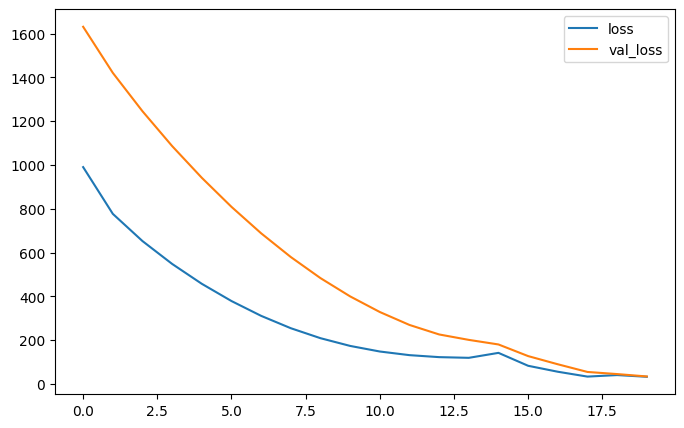

##################################################


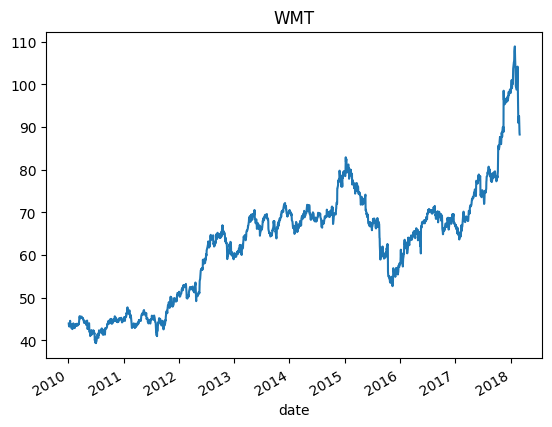

WMT
(2055,)
Epoch 1/20
12/12 [==============================] - 1s 26ms/step - loss: 2993.1707 - val_loss: 3444.3262
Epoch 2/20
12/12 [==============================] - 0s 8ms/step - loss: 2492.0239 - val_loss: 3122.2478
Epoch 3/20
12/12 [==============================] - 0s 9ms/step - loss: 2241.7034 - val_loss: 2846.6633
Epoch 4/20
12/12 [==============================] - 0s 9ms/step - loss: 2019.8759 - val_loss: 2592.2129
Epoch 5/20
12/12 [==============================] - 0s 8ms/step - loss: 1814.8752 - val_loss: 2352.7671
Epoch 6/20
12/12 [==============================] - 0s 9ms/step - loss: 1622.2448 - val_loss: 2124.4404
Epoch 7/20
12/12 [==============================] - 0s 8ms/step - loss: 1441.9716 - val_loss: 1909.7206
Epoch 8/20
12/12 [==============================] - 0s 8ms/step - loss: 1274.1901 - val_loss: 1706.2870
Epoch 9/20
12/12 [==============================] - 0s 8ms/step - loss: 1118.5186 - val_loss: 1516.3036
Epoch 10/20
12/12 [==============================] 

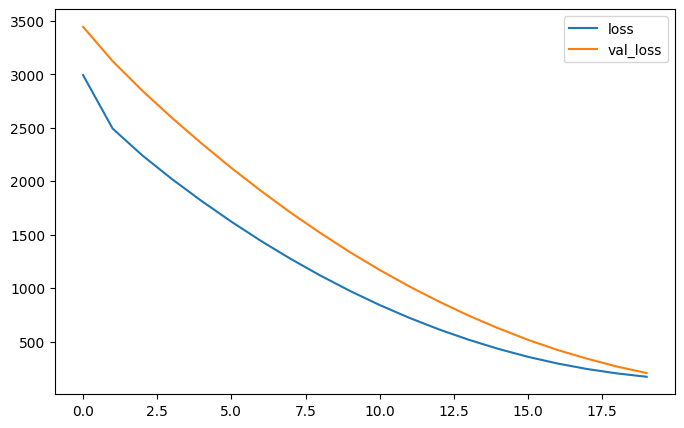

##################################################


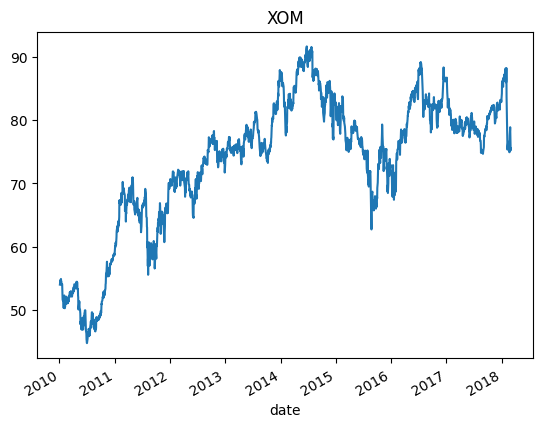

XOM
(2055,)
Epoch 1/20
12/12 [==============================] - 1s 27ms/step - loss: 4467.4502 - val_loss: 5535.8550
Epoch 2/20
12/12 [==============================] - 0s 9ms/step - loss: 3921.3687 - val_loss: 5119.1777
Epoch 3/20
12/12 [==============================] - 0s 9ms/step - loss: 3597.7866 - val_loss: 4760.6309
Epoch 4/20
12/12 [==============================] - 0s 9ms/step - loss: 3308.3833 - val_loss: 4426.5869
Epoch 5/20
12/12 [==============================] - 0s 9ms/step - loss: 3036.8220 - val_loss: 4106.8833
Epoch 6/20
12/12 [==============================] - 0s 8ms/step - loss: 2778.9507 - val_loss: 3801.0391
Epoch 7/20
12/12 [==============================] - 0s 8ms/step - loss: 2534.3206 - val_loss: 3508.3916
Epoch 8/20
12/12 [==============================] - 0s 9ms/step - loss: 2301.6445 - val_loss: 3227.1223
Epoch 9/20
12/12 [==============================] - 0s 8ms/step - loss: 2081.2930 - val_loss: 2958.2288
Epoch 10/20
12/12 [==============================] 

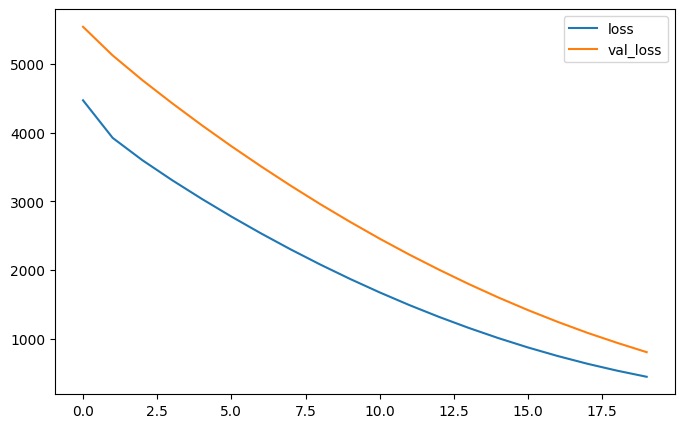

##################################################


In [38]:
model = two_layered_lstm()
training_loop(model)

# Optional: Working on another dataset...

In [ ]:
import pandas as pd
import numpy as np
import os
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import keras
from sklearn.metrics import mean_squared_error
from keras import regularizers
from scipy.ndimage.interpolation import shift


In [ ]:
cls = pd.read_csv('data/closing_prices_tiingo.csv')
cls.set_index('date', inplace=True)


In [ ]:
display(cls.head())
print(cls.iloc[0:1, 1].name)

## Preprocessing
Functions to preprocess data

In [ ]:
def transform_data(x_train, x_dev, x_test, normalize=False):
    """ Do imputing and scaling in two steps. If done in
    pipeline then it is not possible to inverse-transform.
    No need to inverse transform imputing"""

    imputer = SimpleImputer(strategy='median')
    x_train = imputer.fit_transform(x_train)
    x_dev = imputer.transform(x_dev)
    x_test = imputer.transform(x_test)

    if normalize:
        scaler = MinMaxScaler(feature_range=(-1, 1))
        train_x = scaler.fit_transform(x_train)
        dev_x = scaler.transform(x_dev)
        test_x = scaler.transform(x_test)
    else:
        train_x = x_train
        dev_x = x_dev
        test_x = x_test
        scaler = None

    return train_x, dev_x, test_x, scaler

In [ ]:
def split_train_dev_test(seq, dev=0.85,
                         timesteps=30,
                         normalize=False,
                         to_ret=False,
                         differenced=False):

    x_train, x_dev, x_test, names = get_train_dev_test(seq, dev=dev)
    print('shape of train, dev and test sets:',
          x_train.shape, x_dev.shape, x_test.shape)

    # code added 2018-03-23
    if differenced:
        x_train = x_train.diff()
        x_dev = x_dev.diff()
        x_test = x_test.diff()

    if to_ret:
        x_train = x_train.apply(to_return)
        x_dev = x_dev.apply(to_return)
        x_test = x_test.apply(to_return)

    train_x, dev_x, test_x, scaler = transform_data(x_train,
                                                    x_dev, x_test,
                                                    normalize=normalize)

    train_x = to_tensor(train_x, timesteps=timesteps)
    x_train = train_x[:, :-1, :]
    y_train = train_x[:, -1]

    dev_x = to_tensor(dev_x, timesteps=timesteps)
    x_dev = dev_x[:, :-1, :]
    y_dev = dev_x[:, -1]

    test_x = to_tensor(test_x, timesteps=timesteps)
    x_test = test_x[:, :-1, :]
    y_test = test_x[:, -1]
    print('printing from the split-train-dev-test function:')
    print('y_dev raw data:')
#    print(scaler.inverse_transform(y_dev))

    return x_train, y_train, x_dev, y_dev, x_test, y_test, scaler, names


In [ ]:
def to_return(x, period=1):
    """ This function supposes that the input is a
    dataframe"""
    x_shifted = x.shift(periods=period, axis='index')
    return (x - x_shifted)/x_shifted

In [ ]:
def to_tensor(data, timesteps=30):
    x = np.array([data[i:i + timesteps]
                  for i in range(len(data) - timesteps)], dtype=float)
    return x

In [ ]:
def get_train_dev_test(data_x, dev=0.85, drop_col=0.05):
    """ Split data in
    - training,
    - development
    - test data (also called live data)
    """
    """ We choose to keep the last 10 % of the data
    as test data (live trading, live data). The tests
    are performed when the model is finnished training"""

    # Check if 10% or more are NAs if so drop those stocks
    # inform how many are droped and how many are left.
    dropped_stocks = []
    for col in data_x.columns:
        if data_x[col].isnull().sum()/len(data_x) > drop_col:
            dropped_stocks.append(col)
            data_x = data_x.drop(col, axis=1)
            print('Stock {} has been dropped as it had more than {} % Nas'.\
                  format(col, drop_col * 100))

    print('Number of stocks dropped:', len(dropped_stocks))
    print('Number of stocks that are kept: ', len(data_x.columns))

    test_idx = int(0.9 * len(data_x))
    x_test = data_x.iloc[test_idx:, :]

    """Get the first 90% of the data for train-dev"""
    train_dev_x = data_x.iloc[:test_idx]

    dev_idx = int(dev * len(train_dev_x))
    x_train = train_dev_x.iloc[:dev_idx, :]
    x_dev = train_dev_x.iloc[dev_idx:, :]

    return x_train, x_dev, x_test, data_x.columns

## Functions for plotting

In [ ]:
def plot_compare(y_dev, dev_predict):
    k = y_dev.shape[1]
    start = 0
    step = 5
    end = step
    for i in range(0, k, step):
        ax = dev_predict.iloc[:, start:end].plot(
                subplots=True,
                figsize=(15, 20),
                label='Predictions on dev-set', color='DarkBlue')

        y_dev.iloc[:, start:end].plot(ax=ax, subplots=True, figsize=(15, 20),
                  title='Real data together with predictions', label='real data',
                  color='DarkGreen')
        end += i

In [ ]:
def plot_error_curves(history):
    f1, axarr1 = plt.subplots(2, 1, sharex=True, figsize=(8, 10))
    axarr1[0].plot(history.history['loss'])
    axarr1[0].set_title('Training Loss')
    axarr1[1].plot(history.history['val_loss'])
    axarr1[1].set_title('Dev Loss')
    axarr1[1].set_xlabel('Epochs')
#    f1.suptitle('MSE for stock: {}'.format(st_name))
    plt.show()

In [ ]:
import math
import time
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, BatchNormalization
from sklearn.svm import SVR
import tensorflow as tf

## Build the LSTM model

In [ ]:
def build_model(drop_rate, lr, units, decay,
                look_back,
                no_features=1,
                no_outputs=1):
    """ Arguments
    drop_rate -- drop_rate in dropout
    learning_rate -- learning rate
    time_steps -- time steps for the sequence
    units -- number of hidden units or neurons
    decay -- proportion of decay for learning rate
    no_features -- number of features, default 1 for a 1-dim time series
    no_outputs -- number of targets or outputs from the model
    """
    optim = tf.keras.optimizers.Adam(lr=lr,
                            beta_1=0.9,
                            beta_2=0.999,
                            decay=1e-6, 
                            clipnorm=1.0)

    # TODO: how to implement many layers in keras?
    ret_seq = False
    model = Sequential()
    model.add(BatchNormalization(input_shape=(look_back, no_features)))
    model.add(LSTM(units,input_shape=(look_back, no_features),
                   return_sequences=ret_seq,
                   kernel_regularizer=regularizers.l2(0.01),
                   recurrent_regularizer=regularizers.l2(0.01),
                   activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(drop_rate))
    model.add(BatchNormalization())
    model.add(Dense(no_outputs,
                    kernel_regularizer=regularizers.l2(0.01)))
    model.compile(loss='mean_squared_error',
                  optimizer=optim,
                  metrics=['mse'])
    return model

## Function to fit an LSTM
This function returns fitted model as well as history. History object can be used for plotting loss during training for train and test sets.

In [ ]:
def train_lstm(X_train, Y_train, X_dev, Y_dev,
               epochs, drop_rate, batch_size, decay,
               look_back, lr, units):

    num_features = X_train.shape[-1]
    num_outputs = Y_train.shape[-1]
    model = build_model(drop_rate,
                        lr,
                        units,
                        decay,
                        look_back,
                        no_features=num_features,
                        no_outputs=num_outputs)

    history = model.fit(X_train,
                        Y_train,
                        epochs,
                        batch_size,
                        verbose=0,
                        validation_data=(X_dev, Y_dev),
                        shuffle=False)
    return model, history

## Train function
Function to do training with hyperparameter optimization.

In [ ]:
def performance(model, x, y, scaler):
    pred = model.predict(x)
    dim = len(pred.shape)

    if dim < 2:
        pred = pred.reshape(-1, 1)

    pred_reversed = get_inv(pred, scaler)
    ytrue_reversed = get_inv(y, scaler)
    ratio = hit_ratio(ytrue_reversed, pred_reversed)

    return pred_reversed, ytrue_reversed, ratio

In [ ]:
def train(x_train, y_train, x_dev, y_dev,
          scaler, patience=2, normalize=True):
    """ Training function, calls train_lstm and optimizes
    hyperparameters"""
    count = 0
    optimal_parameters = {}

    old_hit = 0
    accepted_hit = 0
    accepted_mse = 0
    old_mse = 1e6

    old_mse_train = 1e6
    old_hit_train = 0
    accepted_hit_train = 0
    accepted_mse_train = 0
    """ Maybe good to save for each new better result?"""
    while  (count < patience): # can be made mor robust
        print('')
        print('.' * 50)
        print('While iteration:', count)
        params = {'drop_rate': np.random.uniform(0.1, 0.5),
                  'lr': 10 ** np.random.uniform(-4, -2),
                  'units': np.random.randint(50, 200),
                  'epochs': np.random.randint(200, 450),
                  'decay': 1e-6,
                  'look_back': x_train.shape[1],
                  'batch_size': np.random.choice(
                          np.array([2**5, 2**6, 2**7, 2**8]))}
        print('')
        print(params)
        print('')
        model, history = train_lstm(x_train, y_train, x_dev, y_dev, **params)
        train_predict = model.predict(x_train)
        dev_predict = model.predict(x_dev)

        if np.any(np.isnan(train_predict)) or np.any(np.isinf(train_predict))\
        or np.any(np.isnan(y_train)) or np.any(np.isinf(y_train)):
            print('')
            print('check if predictions for training dataset are too big!')
            print('are there any Nas or inf? Yes')
            print('train_predict =', train_predict)
            print('y_train =', y_train)
        if np.any(np.isnan(dev_predict)) or np.any(np.isinf(dev_predict))\
        or np.any(np.isinf(y_dev)) or np.any(np.isinf(y_dev)):
            print('')
            print('check if predictions for dev dataset are too big!')
            print('are there any Nas or inf? Yes')
            print('dev_predict =', dev_predict)
            print('y_dev =', y_dev)

        mse_dev = mean_squared_error(y_dev, dev_predict)
        mse_train = mean_squared_error(y_train, train_predict)

        if normalize:
            hit_train = hit_ratio(scaler.inverse_transform(y_train),
                                  scaler.inverse_transform(train_predict),
                                  returns=True)
            hit_dev = hit_ratio(scaler.inverse_transform(y_dev),
                                scaler.inverse_transform(dev_predict),
                                returns=True)

        else:
            hit_train = hit_ratio(y_train, train_predict)
            hit_dev = hit_ratio(y_dev, dev_predict)

        # if diff betwenn train mse and dev mse
        # less than one then no so much overfit
        print('mse for train set:', mse_train)
        print('mse for dev set:', mse_dev)
        print('' )
        print('hit-ratio train:', hit_train)
        print('hit-ratio dev:', hit_dev)

        # TODO: add sequence length as hyper parameter
        # and then pop from optimal parameters
        if (np.abs(mse_train - mse_dev) < .4) and (mse_train < 1. and mse_dev < 1.)\
        and (np.abs(hit_dev - hit_train) < 0.2):
            old_hit = hit_dev
            old_mse = mse_dev
            old_hit_train = hit_train
            old_mse_train = mse_train
            # new code 2018-03-27
            # added if cond and put parameter update under condition
            if accepted_hit < old_hit and accepted_mse < old_mse:
                """Swap accepted and old value"""
                accepted_hit, old_hit = old_hit, accepted_hit
                accepted_mse, old_mse = old_mse, accepted_mse
                accepted_mse_train, old_mse_train = old_mse_train, accepted_mse_train
                accepted_hit_train, old_hit_train = old_hit_train, accepted_hit_train
                print('accepted_hit:', accepted_hit)
                optimal_parameters.update(params)
        del model, history
        model, history = None, None
        if len(optimal_parameters) > 0:
            print('')
            print('The optimal parameters found so far', optimal_parameters)
            print('and the results based on optimal parameters are:')
            print('mse_train: {}, hit_train: {}, mse_dev: {}, hit_dev: {}'.format(
                    accepted_mse_train,
                    accepted_hit_train,
                    accepted_mse,
                    accepted_hit))
        else:
            print('')
            print('No optimal parameters found yet')
        del model
        del history
        count += 1
        
    print('')
    print('The optimal parameters are:', optimal_parameters)
    keras.backend.clear_session()
    """ Has to retrain as the model is deleted during the
    while loop"""

    """ It can happen that the model did not find any optimal
    parameters in that case the dict is empty. You should return
    a message that an error happen"""
    try:
        assert len(optimal_parameters) > 0
        model, history = train_lstm(x_train,
                                    y_train,
                                    x_dev,
                                    y_dev,
                                    **optimal_parameters)
        """" Save model to disk in JSON form """
        # Serialize to JSON
        model_json = model.to_json()
        with open('model.json', 'w') as json_file:
            json_file.write(model_json)
        # serialize weights to HDF5
        model.save_weights('model.h5')


        return optimal_parameters, model, history
    except AssertionError:
        print('No optimal parameters were found, try again but train longer.')
        print(' ')

In [ ]:
def main():
    count = 1
    NORMALIZE = True
    (x_train, y_train, x_dev, y_dev,
     x_test, y_test, scaler, stock_names) = split_train_dev_test(cls,
                                                                 normalize=NORMALIZE,
                                                                 to_ret=True,
                                                                 dev=0.9,
                                                                 differenced=False)
    print('')
    print('training algorithm:')
    print('shape train set:', x_train.shape, y_train.shape)
    print('type of train set:', type(x_train))
    print('shape dev set:', x_dev.shape, y_dev.shape)
    print('shape test set:', x_test.shape, y_test.shape)

    optimal_parameters, model, history = train(x_train,
                                               y_train,
                                               x_dev,
                                               y_dev,
                                               scaler,
                                               patience=20,
                                               normalize=NORMALIZE)

    """Both targets and predictions have to be transformed"""
    dev_predict = model.predict(x_dev)
    arg_pred_dev = dev_predict
    arg_y_dev = y_dev

    if NORMALIZE:
        arg_pred_dev = scaler.inverse_transform(dev_predict)
        arg_y_dev = scaler.inverse_transform(y_dev)

    dev_predict = pd.DataFrame(arg_pred_dev, columns=stock_names)
    y_dev = pd.DataFrame(arg_y_dev, columns=stock_names)

    plot_error_curves(history)

    dev_predict.plot(figsize=(10, 10))

    dev_predict.iloc[:, 0:5]

    y_dev.plot(figsize=(10, 10))

    ax = dev_predict.iloc[:, 0:5].plot(
            subplots=True,
            figsize=(15, 20),
            label='Predictions on dev-set',
            color='DarkBlue')

    y_dev.iloc[:, 0:5].plot(ax=ax,
              subplots=True,
               figsize=(15, 20),
               title='Real data together with predictions',
               label='real data',
               color='DarkGreen')

if __name__ == '__main__':
    main()
